# Amazon Fine Food Reviews

**Data includes**:

* Reviews from Oct 1999 - Oct 2012
* 568,454 reviews
* 256,059 users
* 74,258 products
* 260 users with > 50 reviews

**Columns**
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful (Helpful)
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not (Helpful + not Helpful)
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

**Objective**: In order to train a classifier to detect whether the review is positive or negative we need to have a label column. In the given set such info not available but, fortunately, we got a column of scores/rating which is close approximation of user liked or not liked the product. Scores less than 3 (Rating 2 or 1) we are pretty that label is negative and for more than 3 (Rating 3 or 4) it's positive. But, we are sure about examples with score 3 (kind of neutral). so we drop those rows. 

## Loading packages and data

In [24]:

%load_ext autoreload
%autoreload 2
%autosave 2

%matplotlib inline



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sqlite3
import re
from tqdm.notebook import tqdm
from prettytable import PrettyTable
from modules.Text_transformers import *
from modules.custom_transformers import *

from sklearn.pipeline import Pipeline, FeatureUnion
import pandas as pd
import numpy as np
import nltk
import string
from bs4 import BeautifulSoup
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split,GridSearchCV


from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics import confusion_matrix,roc_curve, auc, accuracy_score

# ML Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV,_CalibratedClassifier, calibration_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering,MiniBatchKMeans

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


Dataset is made available in the RDBMS we need use **SQL** statements to interact with it. Thankfully, *Pandas* library allow us to read data from DB connection using *SQL* query statements. 

In [3]:
# connect to the SQLite Table to read data .
con = sqlite3.connect('./Datasets/database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
filtered_data.Text.head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [5]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  object
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [6]:
print(f"There are {len(filtered_data.ProductId.unique())} unique Products")
print(f"There are {len(filtered_data.UserId.unique())} unique Users")

There are 72005 unique Products
There are 243414 unique Users


## Data Cleaning 

### Duplication

Most of the times public data has duplicate entries or proxies. If not removed these may pose problems such as bias leakage etc. 

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

User with userid *AR5J8UI46CURR* seems to have given same reviews including scores for  multiple products at the same time. Upon verifying on **Amazon**, The products listed belong to **Loacker Quadratini** manufacturer basically cookies of different flavors. 

 For duplicate entries (based on UserId, ProfileName, Score, Time, Text) will keep first entry then drop the rest  

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries based on above mentioned subset of features
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
print(f'Roughly {round(1 - final.shape[0]/525814,3)*100} percent reviews are duplicate')

Roughly 30.7 percent reviews are duplicate


### Clean [HelpfulnessNumerator > HelpfulnessDenominator]

It has been found that few rows have *HelpfulnessNumerator* value greater than *HelpfulnessDenominator* which does make any sense.	

In [10]:
final.loc[final.HelpfulnessNumerator>final.HelpfulnessDenominator]

Id   ProductId          UserId              ProfileName  \
59301  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
41159  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

       HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
59301                     3                       1  positive  1224892800   
41159                     3                       2  positive  1212883200   

                                            Summary  \
59301             Bought This for My Son at College   
41159  Pure cocoa taste with crunchy almonds inside   

                                                    Text  
59301  My son loves spaghetti so I didn't hesitate or...  
41159  It was almost a 'love at first bite' - the per...

In [11]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

positive    0.843178
negative    0.156822
Name: Score, dtype: float64


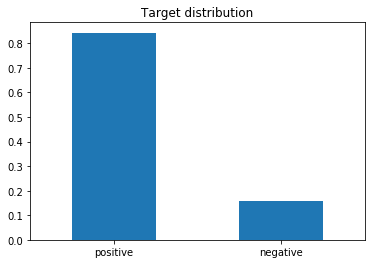

In [12]:
print(final.Score.value_counts(normalize=True))

final.Score.value_counts(normalize=True).plot(kind='bar')
plt.title('Target distribution')
plt.xticks(rotation=0);

Looking at the proportion It can be said that data is highly imbalanced

### Top Users and Products

In [13]:
(final.UserId.value_counts()==1).sum()/final.UserId.value_counts().sum()

0.5411468788014422

Top 10 Users:

AY12DBB0U420B     310
A3OXHLG6DIBRW8    264
A281NPSIMI1C2R    240
A1YUL9PCJR3JTY    205
A1Z54EM24Y40LL    187
A3D6OI36USYOU1    136
A2MUGFV2TDQ47K    136
AZV26LP92E6WU     123
AKMEY1BSHSDG7     118
A2GEZJHBV92EVR    111
Name: UserId, dtype: int64


Top 10 Products:

B007JFMH8M    856
B0026RQTGE    609
B003B3OOPA    598
B001EO5Q64    551
B000NMJWZO    532
B000VK8AVK    516
B005K4Q1YA    512
B000UBD88A    505
B005ZBZLT4    468
B000KV61FC    455
Name: ProductId, dtype: int64


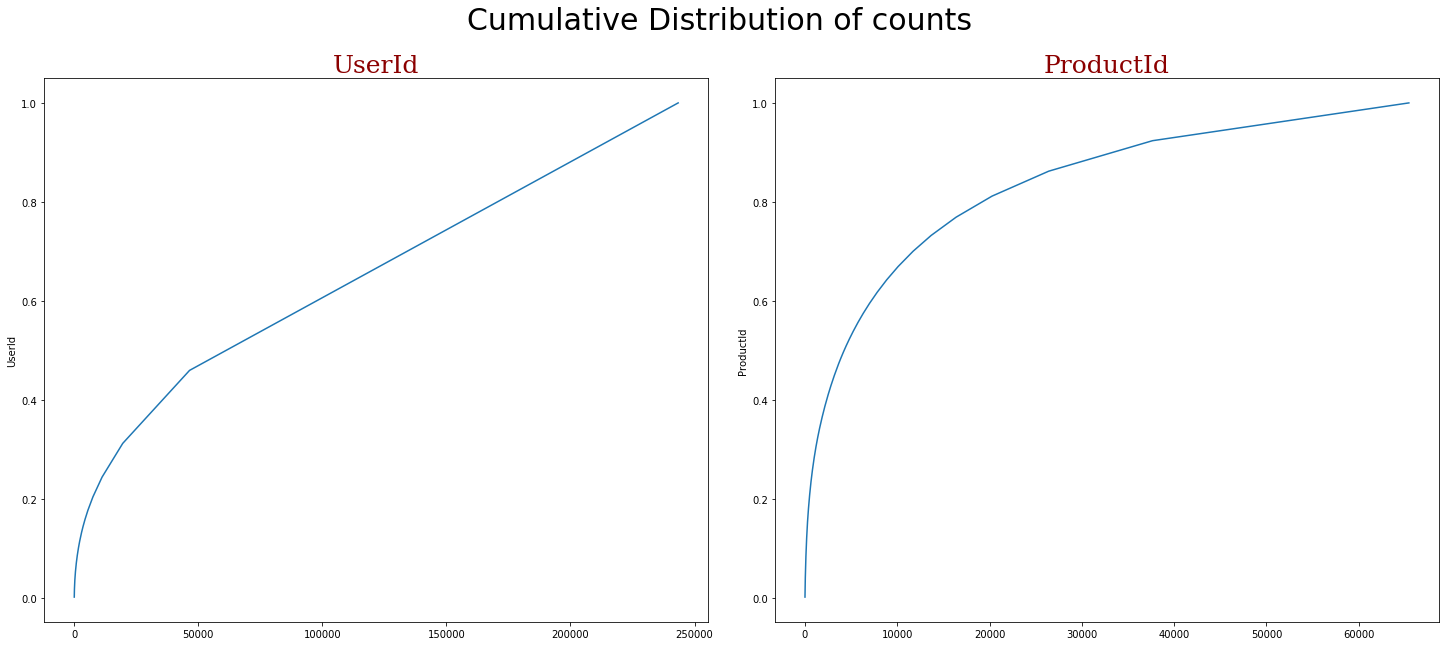

In [14]:
print("Top 10 Users:\n")
print(final.UserId.value_counts().head(10))

print("\n\nTop 10 Products:\n")
print(final.ProductId.value_counts().head(10))
      


fig,axes = plt.subplots(1,2,figsize=(25,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Cumulative Distribution of counts', fontsize=30)
axes = axes.ravel()

for i,var in enumerate(['UserId','ProductId']):
    y = final[var].value_counts(normalize=True).cumsum()
    sns.lineplot(x=range(len(y)), y=y, ax = axes[i]);
    plt.title('Cumsum Plot of Users and Products', fontdict = font)
    axes[i].set_title(var,fontdict = font, fontsize=25)

* Top 50000 users out of 250000(20%) contribute nearly 50% of reviews
* Top 20000 products out of 70000(28%) occupies nearly 80% of reviews

## Text cleaning and preprocessing

Before jumping into analysis we need to clean and preprocess. Let's take a look at sample text

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[85]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I was intially introduced to Pro-Treat Beef Liver Freeze Dried Dog Treats at my veterinarian's office.  Rudy, our Jack Russell Terrior, usually not all that interested in dog treats, responded like I'd never seen before!<br /><br />I bought a couple of cans (they are pretty pricey), but gave them to him sparingly. The tricks he'd do for the Pro-Treats were really entertaining.  Now, Rudy has to take meds. for his glaucoma and thank heavens I found the large size here which is a good value, so he not only takes his medicine, but gives great tricks in return each day! He's a happy camper, despite the loss of sight in one eye.<br /><a href="http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat Beef Liver, Freeze Dried Dog Treats, 21 Ounce</a><br /><br />Rudy says, "They are the best part of my day!"  We think so too!  ~ CJ
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both we

### Cleaning Steps:


* remove unwanted characters and texts like *html tags*, *link address*, *punctuations*
* Check if the word is made up of english letters and is not alpha-numeric
* Check that word length is greater than 2 (no adjective in 2-letter)
* text lowercase
* stopwords remove
* Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

#### **Link address removal**

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039

sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I was intially introduced to Pro-Treat Beef Liver Freeze Dried Dog Treats at my veterinarian's office.  Rudy, our Jack Russell Terrior, usually not all that interested in dog treats, responded like I'd never seen before!<br /><br />I bought a couple of cans (they are pretty pricey), but gave them to him sparingly. The tricks he'd do for the Pro-Treats were really entertaining.  Now, Rudy has to take meds. for his glaucoma and thank heavens I found the large size here which is a good value, so he not only takes his medicine, but gives great tricks in return each day! He's a happy camper, despite the loss of sight in one eye.<br /><a href=" Beef Liver, Freeze Dried Dog Treats, 21 Ounce</a><br /><br />Rudy says, "They are the best part of my day!"  We think so too!  ~ CJ


#### tag removal '< anything>'

In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I was intially introduced to Pro-Treat Beef Liver Freeze Dried Dog Treats at my veterinarian's office.  Rudy, our Jack Russell Terrior, usually not all that interested in dog treats, responded like I'd never seen before!I bought a couple of cans (they are pretty pricey), but gave them to him sparingly. The tricks he'd do for the Pro-Treats were really entertaining.  Now, Rudy has to take meds. for his glaucoma and thank heavens I found the large size here which is a good value, so he not only takes his medicine, but gives great tricks in return each day! He's a happy camper, despite the loss of sight in one eye.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carri

#### Expand language Contractions

In [18]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    #order should not change
    
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

print(text)
text = decontracted(text)
print("="*50)
print(text)

Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...Can you tell I like it? :)
Ca not do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unb

#### Alpha-numeric words

In [19]:
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I was intially introduced to Pro-Treat Beef Liver Freeze Dried Dog Treats at my veterinarian's office.  Rudy, our Jack Russell Terrior, usually not all that interested in dog treats, responded like I'd never seen before!<br /><br />I bought a couple of cans (they are pretty pricey), but gave them to him sparingly. The tricks he'd do for the Pro-Treats were really entertaining.  Now, Rudy has to take meds. for his glaucoma and thank heavens I found the large size here which is a good value, so he not only takes his medicine, but gives great tricks in return each day! He's a happy camper, despite the loss of sight in one eye.<br /><a href=" Beef Liver, Freeze Dried Dog Treats,  Ounce</a><br /><br />Rudy says, "They are the best part of my day!"  We think so too!  ~ CJ


#### Custom STOP words

In [20]:
#1. we are not removing the words from the stop words list: 'no', 'nor', 'not' as these changes the meaning
#2. /<br /><br />" "==>" after the above steps, we are getting "br br": adding 'br'

In [2]:
# NLTK stopwords - https://gist.github.com/sebleier/554280

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

### Compile steps together

Combining preprocessing steps into function  

In [12]:
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = sentance.lower() 
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e for e in sentance.split() if e not in stopwords)
    preprocessed_reviews.append(sentance.strip())

NameError: name 'decontracted' is not defined

In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [27]:
final['Cleaned_text'] = Amaz_textCleaner(stopwords=stopwords).fit_transform(final.Text)
final['Cleaned_summary'] = Amaz_textCleaner(stopwords=stopwords).fit_transform(final.Summary)

#### Write processed into SQL

In [18]:
# connect to database 
con = sqlite3.connect('./Datasets/final.sqlite')
c=con.cursor()  #it allow us to excute std SQL commands 
con.text_factory = str
final.to_sql(name='Reviews',con = con,schema=None,if_exists='replace')
con.close()

In [3]:
con = sqlite3.connect('./Datasets/final.sqlite')

final = pd.read_sql_query("""SELECT * FROM Reviews""", con) 


In [4]:
final.head()

index      Id   ProductId          UserId                  ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
3  138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
4  138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   
3                     1                       1  positive  1076025600   
4                     3                       4  positive  1018396800   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   
3      a good swingy rhythm for reading aloud   
4             A great way to learn the months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ...   
3  This is a great little book to read aloud- it ...   
4  This is a book of poetry about the months of t...   

                                        Cleaned_text  
0  witty little book makes son laugh loud recite ...  
1  grew reading sendak books watching really rosi...  
2  fun way children learn months year learn poems...  
3  great little book read aloud nice rhythm well ...  
4  book poetry months year goes month cute little...

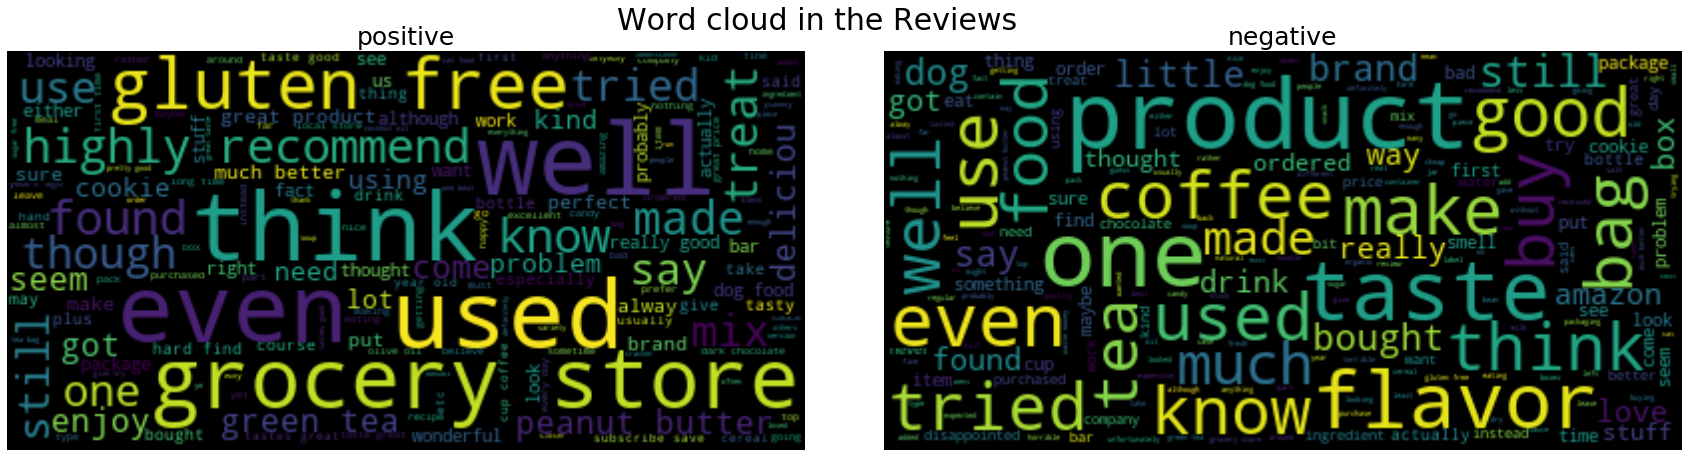

In [15]:
## top frequent words in the 


fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Word cloud in the Reviews', fontsize=30)
plt.subplots_adjust(top=0.99)
axes = axes.ravel()

for i,rev_type in enumerate(final.Score.unique()):
    wordcloud = WordCloud(max_font_size=50, max_words=200
                          , background_color="black",stopwords=None).generate(' '.join(final.Cleaned_text.loc[final.Score==rev_type]))
    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(rev_type,fontsize=25)
    axes[i].axis('off')

### Text summrize

In [8]:
summerizer = Text_Summerizer()

# stats of basic text  
summary = summerizer.fit_transform(final.Cleaned_text)

In [10]:
# filtering out outliers cases > 99 percentile
from tabulate import tabulate

summary_collector = [(i,np.percentile(summary[i][~summary[i].isna()],99), summary[i].max(), (summary[i]>np.percentile(summary[i][~summary[i].isna()],99)).sum()/len(summary)*100) for i in summary.columns]



summary_outlier_summary = pd.DataFrame(summary_collector, columns=['column','99_quantile', 'max_value', 'percent>99_quantile' ]).round(3)
summary_outlier_summary.set_index('column', inplace=True)
print(tabulate(summary_outlier_summary, headers =summary_outlier_summary.columns ))

summary = summary.clip(upper=summary_outlier_summary['99_quantile'], axis=1)

                      99_quantile    max_value    percent>99_quantile
------------------  -------------  -----------  ---------------------
count_letters            1242            11079                  0.999
count_word                187             1596                  0.994
count_unique_word         136              771                  0.978
count_sent                  1                1                  0
count_punctuations          0                0                  0
mean_word_len               6.842           11                  0.995


In [11]:
summary.columns

Index(['count_letters', 'count_word', 'count_unique_word', 'count_sent',
       'count_punctuations', 'mean_word_len'],
      dtype='object')

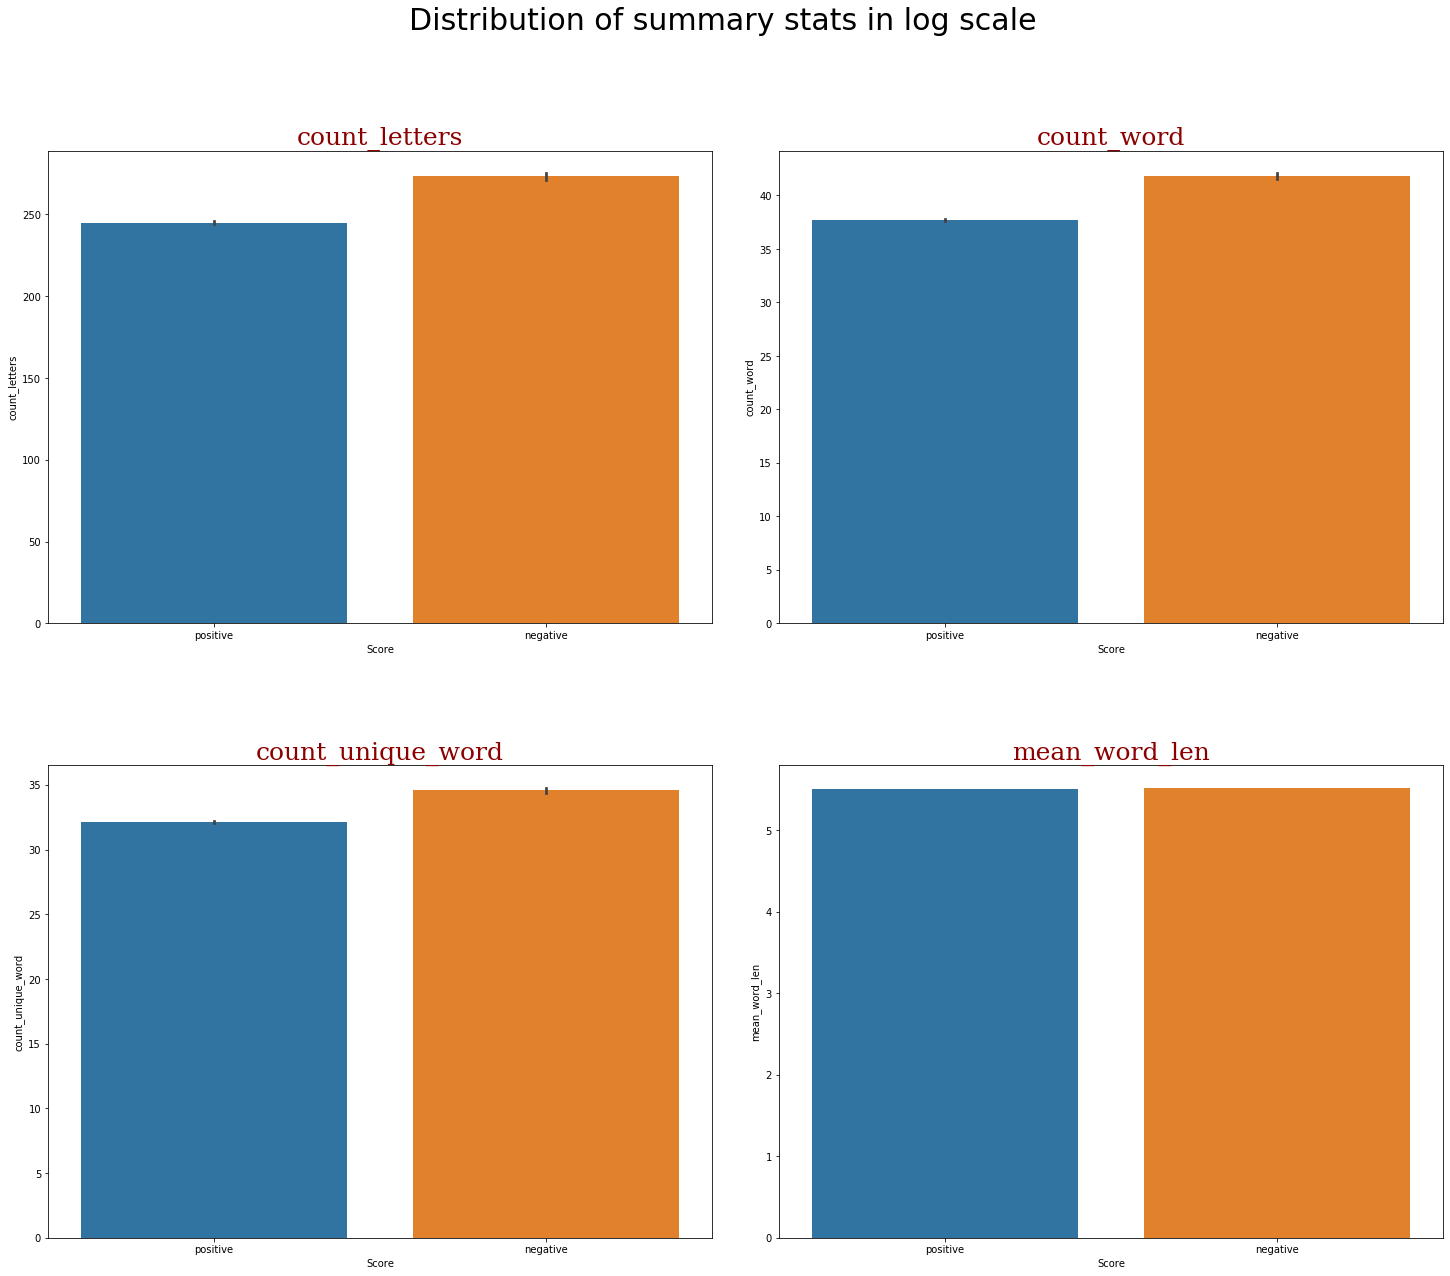

In [14]:
cols = ['count_letters', 'count_word', 'count_unique_word', 'mean_word_len']

fig,axes = plt.subplots(2,2,figsize=(25,20))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of summary stats in log scale', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    sns.barplot(x= final.Score, y =summary[col] , ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)
#fig.delaxes(axes[-1])

## Featurization

### Bag Of Words (BOW)

In [8]:
#BoW
count_vect = CountVectorizer(max_features=5000) #in scikit-learn
final_counts = count_vect.fit_transform(final.Cleaned_text.values)

#### Bi-Grams and n-Grams.

Motivation

Now that we have our list of words describing positive and negative reviews lets analyse them.

We begin analysis by getting the frequency distribution of the words as shown below

### TF-IDF

In [25]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 203012)
the number of unique words including both unigrams and bigrams  203012


### Word2Vec

#### Load pre-trained model

In [4]:
# Using Google News Word2Vectors gensim


# load word embedding pre-trained on GoogleNews news articles in Gensim model
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
model.most_similar('food')

[('foods', 0.6804922223091125),
 ('Food', 0.6538904905319214),
 ('foodstuffs', 0.6425829529762268),
 ('meals', 0.6166686415672302),
 ('food_stuffs', 0.5928642153739929),
 ('nourishing_meals', 0.5847609043121338),
 ('foodstuff', 0.5835224986076355),
 ('staple_foods', 0.5535789132118225),
 ('nutritious', 0.5466451048851013),
 ('meal', 0.5433712601661682)]

In [6]:
model.similarity('India', 'india')

0.50457346

In [21]:
model.similarity('woman', 'man')

0.76640123

In [22]:
model.most_similar('tasty') 

[('delicious', 0.8730389475822449),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856924533843994),
 ('flavorful', 0.7420164346694946),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012300491333008),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857702732086182)]

#### Fine-tine model

Fine model parameter using our text corpus to make it more context(food reviews) specific

In [23]:
# use original text 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
import pickle
import gensim

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

We will take whole sentence including stop words as neighbouring words association is important for word2vec training.

In [24]:
# prepare input for training word2vec
import gensim
i=0
list_of_sent=[]
for sent in tqdm(final['Text'].values): 
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [25]:
# pickle 
with open('w2v_inputs.pkl', 'wb') as f:
    pickle.dump(list_of_sent, f, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# pickle 
with open('w2v_inputs.pkl', 'rb') as f:
    list_of_sent = pickle.load(f)

Since our corpus is less and limited computational power we will keep dimension to 50 from original 300.

In [38]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

In [39]:
words = list(w2v_model.wv.vocab)
print(len(words))

33783


In [32]:
w2v_model.most_similar('delicious')

/home/skumar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('yummy', 0.889825701713562),
 ('delish', 0.8850646018981934),
 ('delicous', 0.8564618229866028),
 ('scrumptious', 0.8476344347000122),
 ('fabulous', 0.8404069542884827),
 ('tasty', 0.8167029619216919),
 ('wonderful', 0.8143588304519653),
 ('delightful', 0.810648500919342),
 ('fantastic', 0.8065598011016846),
 ('delectable', 0.8001806139945984)]

In [34]:
w2v_model.wv.save_word2vec_format('w2v_model.bin', binary=True)

In [4]:
w2v_model = KeyedVectors.load_word2vec_format('w2v_model.bin', binary=True)

## Applying TSNE

Let's see T-sne plots all these features vectors. Since our is huge,  plotting subset (2000 rows) 

### Subset data

In [3]:
# subsetting dataset

#Taking first 1k positive and first 1k negative
data_p=final[final['Score']=='positive'].head(n = 1000)
data_n=final[final['Score']=='negative'].head(n = 1000)

# concatanate into single df
final_2k=pd.concat([data_p, data_n])

### BOW features

In [10]:
x = final_2k.Cleaned_text
y = final_2k.Score

# BOW 
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn

# vectorizer transformation
x = count_vect.fit_transform(x)
print(x.shape)

# standardization
scaler = StandardScaler(with_mean=False) # with mean=false as True does not work on Sparse matrix
x = scaler.fit_transform(x)

(2000, 83400)


/home/skumar/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


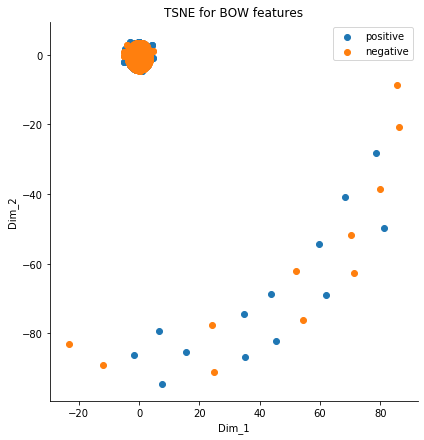

In [11]:
# T-sne model initialization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,n_iter=5000)


#X_embedding = tsne.fit_transform(x)

# convert the sparse matrix into dense matrix then 
X_embedding = tsne.fit_transform(x.toarray())

for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(for_tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1',"Dim_2")
plt.legend()
plt.title('TSNE for BOW features')
plt.show()

### TF-IDF Features

In [4]:
# subsetting data
x = final_2k.Cleaned_text.values
y = final_2k.Score

# BOW with bi-grams
tfidf_vect = TfidfVectorizer(ngram_range=(1,2)) #in scikit-learn

# vectorizer transformation
x = tfidf_vect.fit_transform(x)
print(x.shape)
final_tf_idf = x # later final_tf_idf willbe used for plotting T-nse
# standardization
scaler = StandardScaler(with_mean=False) # with mean=false as True does not work on Sparse matrix
x = scaler.fit_transform(x)

(2000, 83400)


/home/skumar/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


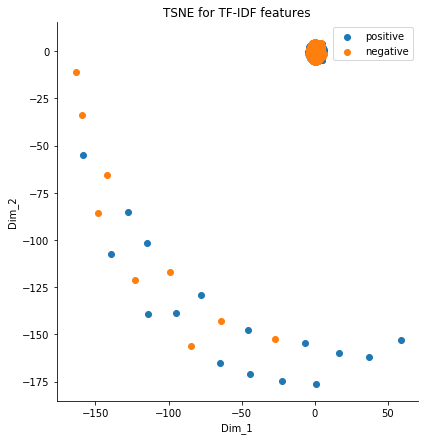

In [13]:
# T-sne model initialization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)


X_embedding = tsne.fit_transform(x)

# convert the sparse matrix into dense matrix then 
X_embedding = tsne.fit_transform(x.toarray())

for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(for_tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1',"Dim_2")
plt.legend()
plt.title('TSNE for TF-IDF features')
plt.show()

There is no way we can separte two groups by passing a hyperplane which means logistic regression won't work 

### Avg-Word2Vec

We will use word2vec trained on our dataset

In [5]:
# use original text 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm
import pickle
import gensim

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

list_of_sent = []

for sent in tqdm(final_2k['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cln_word in cleanpunc(w).split():
            if(cln_word.isalpha()):
                filtered_sentence.append(cln_word.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

KeyboardInterrupt: 

Average w2v compute (average of vectors of all the words found in the sentences )

In [42]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


2000
50


/home/skumar/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


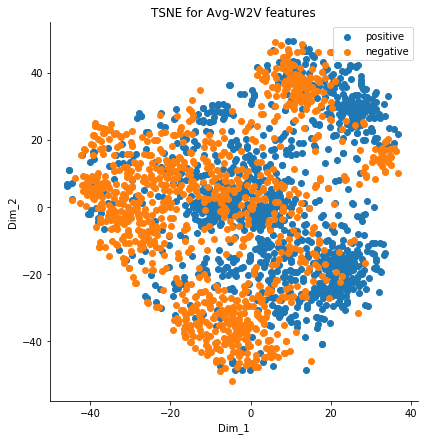

In [48]:
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)

y = final_2k.Score
X_embedding = model.fit_transform(sent_vectors)


for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(for_tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1',"Dim_2")
plt.legend()
plt.title('TSNE for Avg-W2V features')
plt.show()

### TF-IDF weighted Word2Vec

In [61]:
import math
tfidf_features = tfidf_vect.get_feature_names()
#final_tf_idf = final_tf_idf.toarray()

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf =final_tf_idf[row, tfidf_features.index(word)] #cell value Tf-idf 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum!=0: sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

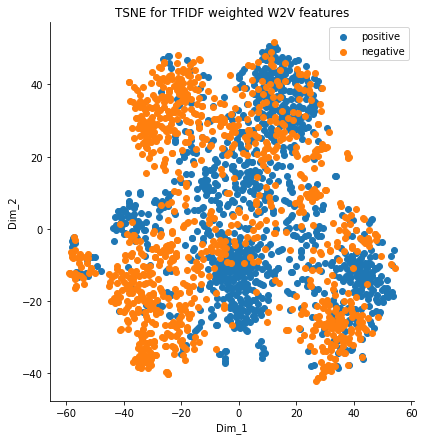

In [64]:
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)

y = final_2k.Score
X_embedding = model.fit_transform(tfidf_sent_vectors)


for_tsne = np.hstack((X_embedding, y.values.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(for_tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1',"Dim_2")
plt.legend()
plt.title('TSNE for TFIDF weighted W2V features')
plt.show()

None of the the above plots give well separated clusters. We have to look for alternative

### Custom Transformers

# Model Building

## K-NN

### Data Preparation

Since the data is huge I sampled around 5000 examples from both Positive and negative reviews and also K-nn is Time and memory intensive.

In [3]:
data_pos = final[final["Score"] == 'positive'].sample(n = 5000)
data_neg = final[final["Score"] == 'negative'].sample(n = 5000)
final_10k = pd.concat([data_pos, data_neg])

X = final_10k.Cleaned_text
Y = final_10k.Score

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
#X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.25,random_state=0)

print("Split size")
X_train.shape,X_test.shape

Split size


((8000,), (2000,))

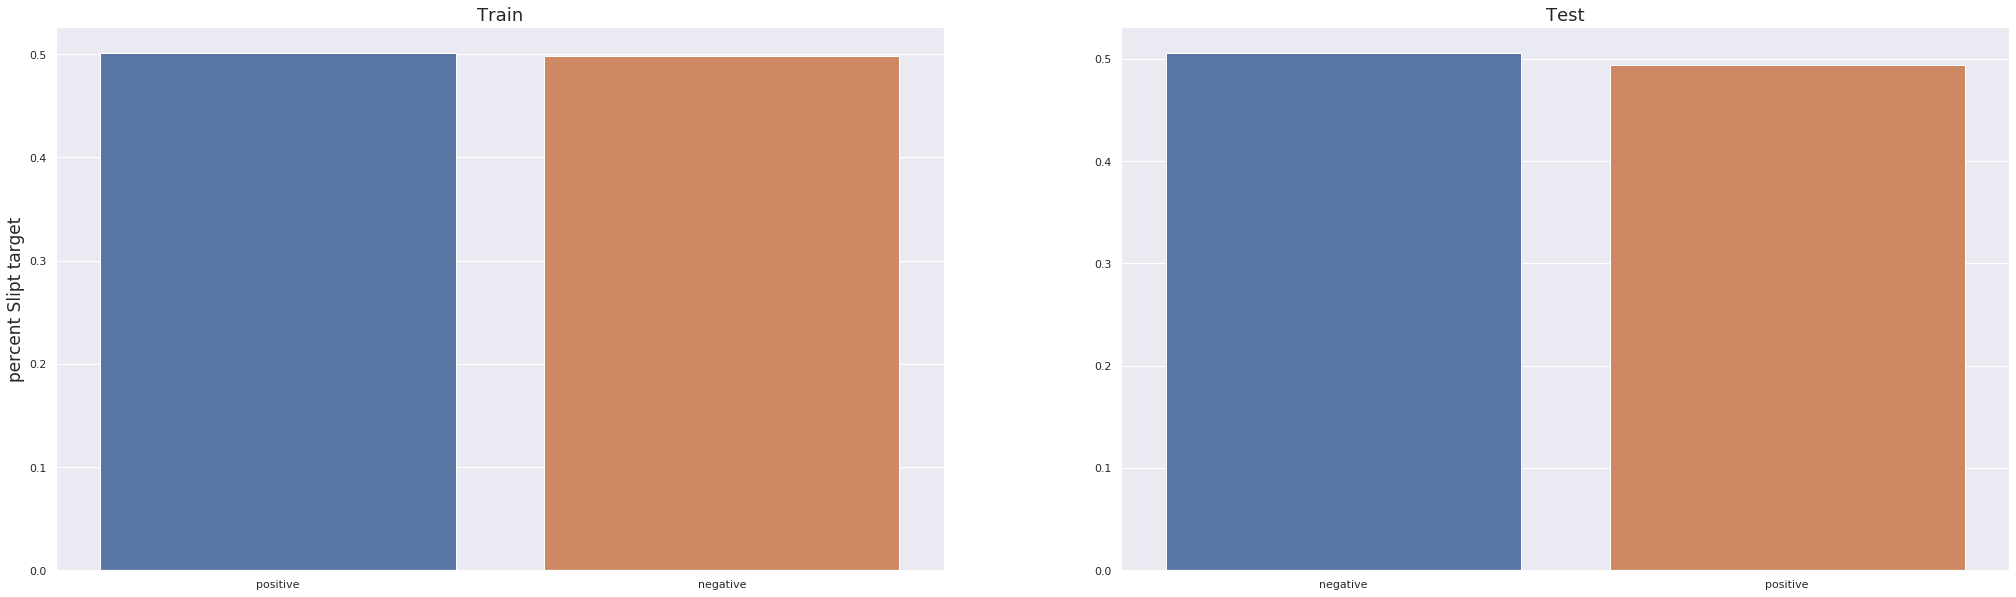

In [5]:
## Check whether the class are properly split among the three sets
%matplotlib inline
sns.set() # setting seaborn default for plots

plt.figure(figsize=(35,10))

# Train
plt.subplot(121)
sns.barplot(x = Y_train.value_counts().index,y = Y_train.value_counts(normalize=True));
plt.title('Train',fontsize = 18)
plt.xlabel('',fontsize = 16)
plt.ylabel('percent Slipt target',fontsize = 17)

## Valid
#plt.subplot(122)
#sns.barplot(x = Y_cv.value_counts().index,y = Y_cv.value_counts(normalize=True));
#plt.title('Valid',fontsize = 18)
#plt.xlabel('',fontsize = 16)
#plt.ylabel(None);

# Test
plt.subplot(122)
sns.barplot(x = Y_test.value_counts().index,y = Y_test.value_counts(normalize=True));
plt.title('Test',fontsize = 18)
plt.xlabel('',fontsize = 16)
plt.ylabel(None);

Looks like perfect split

### BOW

#### Set 1: BOW features & Brute force

In [126]:
## featureization
vectorizer = CountVectorizer() #ngram_range=(1,2)

X_train_bow = vectorizer.fit_transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

X_train_bow.shape,X_test_bow.shape

((8000, 18807), (2000, 18807))

In [130]:

k_params = {'n_neighbors': list(range(10,200,10))}

model = GridSearchCV(KNeighborsClassifier(algorithm='brute'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)
model.fit(X_train_bow,Y_train)

Fitting 10 folds for each of 19 candidates, totalling 190 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   44.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   48.4s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   48.8s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   48.8s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   48.8s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   48.9s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   49.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   52.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   52.9s
[Paralle

[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=6,
             param_grid={'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100, 110, 120, 130, 140, 150, 160, 170,
                                         180, 190]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=50)

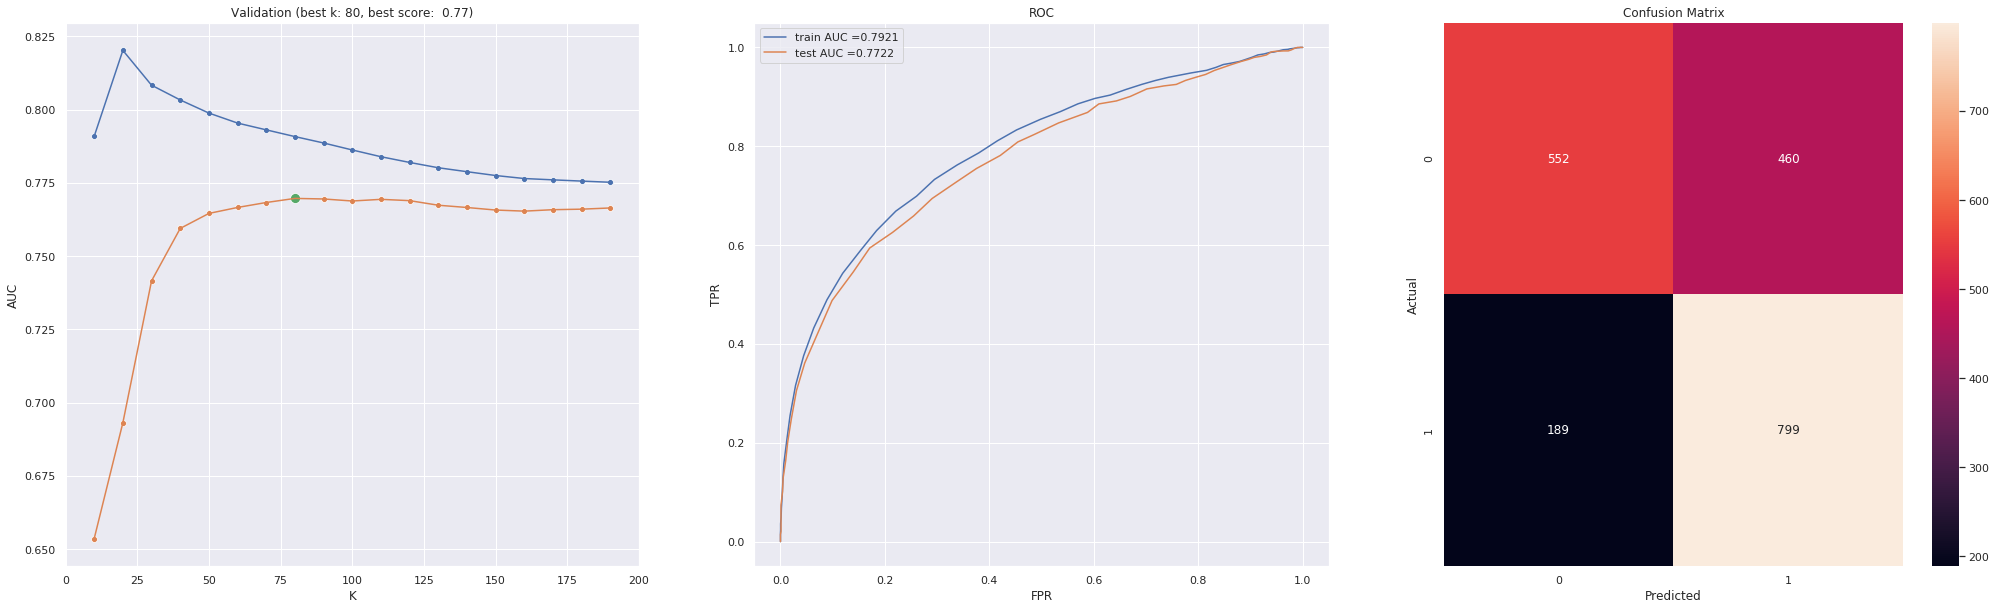

In [131]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Set 5: BOW features & K-d tree

Because of Time and space complexity min_df=10, max_features=500 is considered 

In [133]:
## featureization
vectorizer = CountVectorizer(min_df=10, max_features=500) #ngram_range=(1,2)

X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()

X_train_bow.shape,X_test_bow.shape

((8000, 500), (2000, 500))

In [134]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_params = {'n_neighbors': list(range(10,200,10))}

model = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=4,verbose=50)
model.fit(X_train_bow,Y_train)

Fitting 10 folds for each of 19 candidates, totalling 190 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  4.4min
[Paralle

/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed: 15.3min
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed: 16.4min
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed: 17.3min
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed: 17.4min
[Parallel(n_jobs=4)]: Done  63 tasks      | elapsed: 17.4min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 17.4min
[Parallel(n_jobs=4)]: Done  65 tasks      | elapsed: 18.4min
[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed: 18.5min
[Parallel(n_jobs=4)]: Done  67 tasks      | elapsed: 18.5min
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed: 18.5min
[Parallel(n_jobs=4)]: Do

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                         100, 110, 120, 130, 140, 150, 160, 170,
                                         180, 190]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=50)

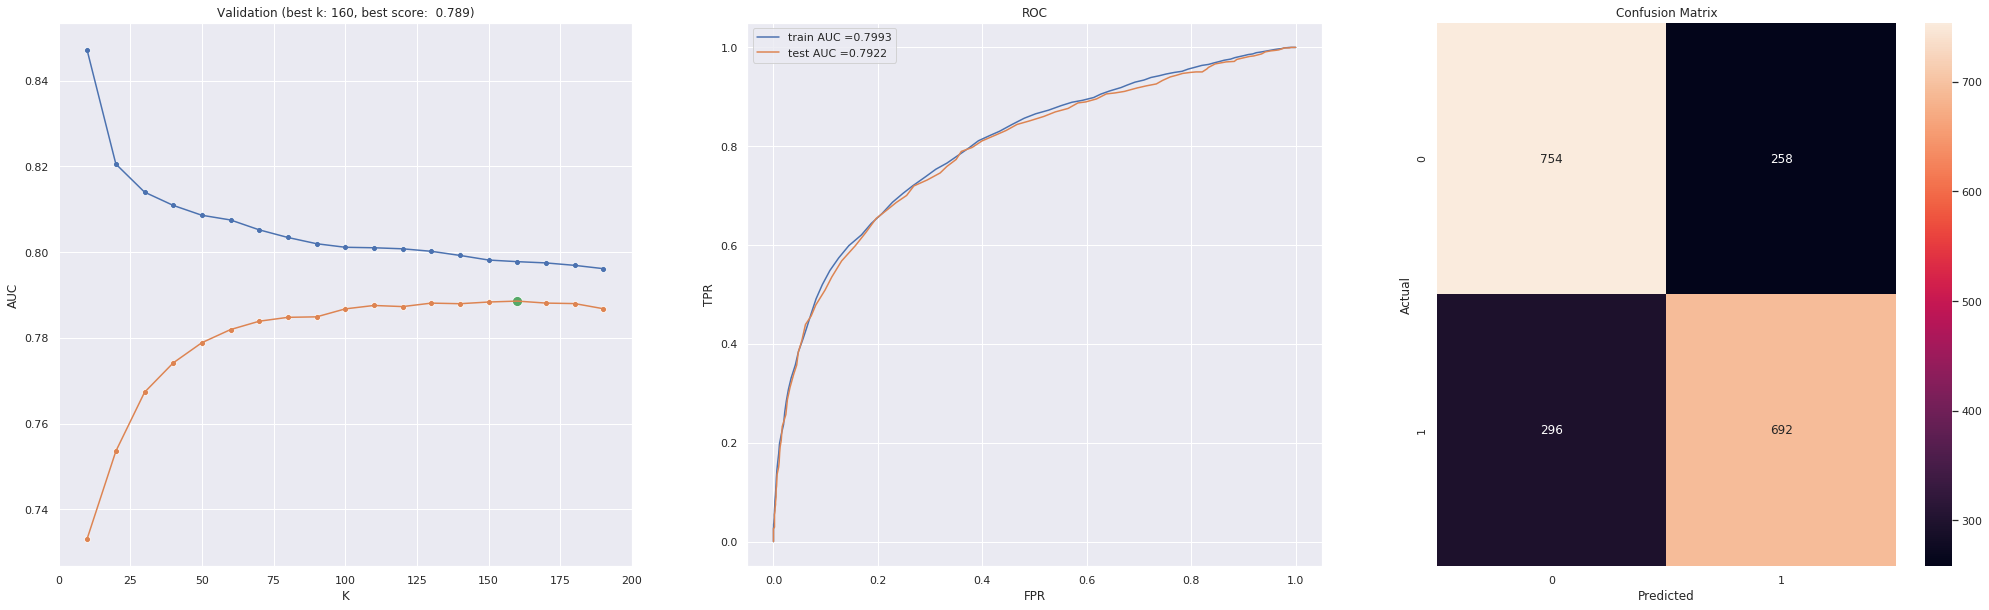

In [136]:



# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### TF-IDF

#### Set 2: TFIDF features & brute

In [139]:
## featureization
vectorizer = TfidfVectorizer() #ngram_range=(1,2)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf.shape,X_test_tfidf.shape

((8000, 18807), (2000, 18807))

In [140]:


k_params = {'n_neighbors': list(range(10,200,10))}

model = GridSearchCV(KNeighborsClassifier(algorithm='brute'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)

model.fit(X_train_tfidf,Y_train);

Fitting 10 folds for each of 19 candidates, totalling 190 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   13.1s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   13.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   13.3s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   17.2s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   17.4s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   17.6s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   17.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   21.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   21.4s
[Paralle

[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Do

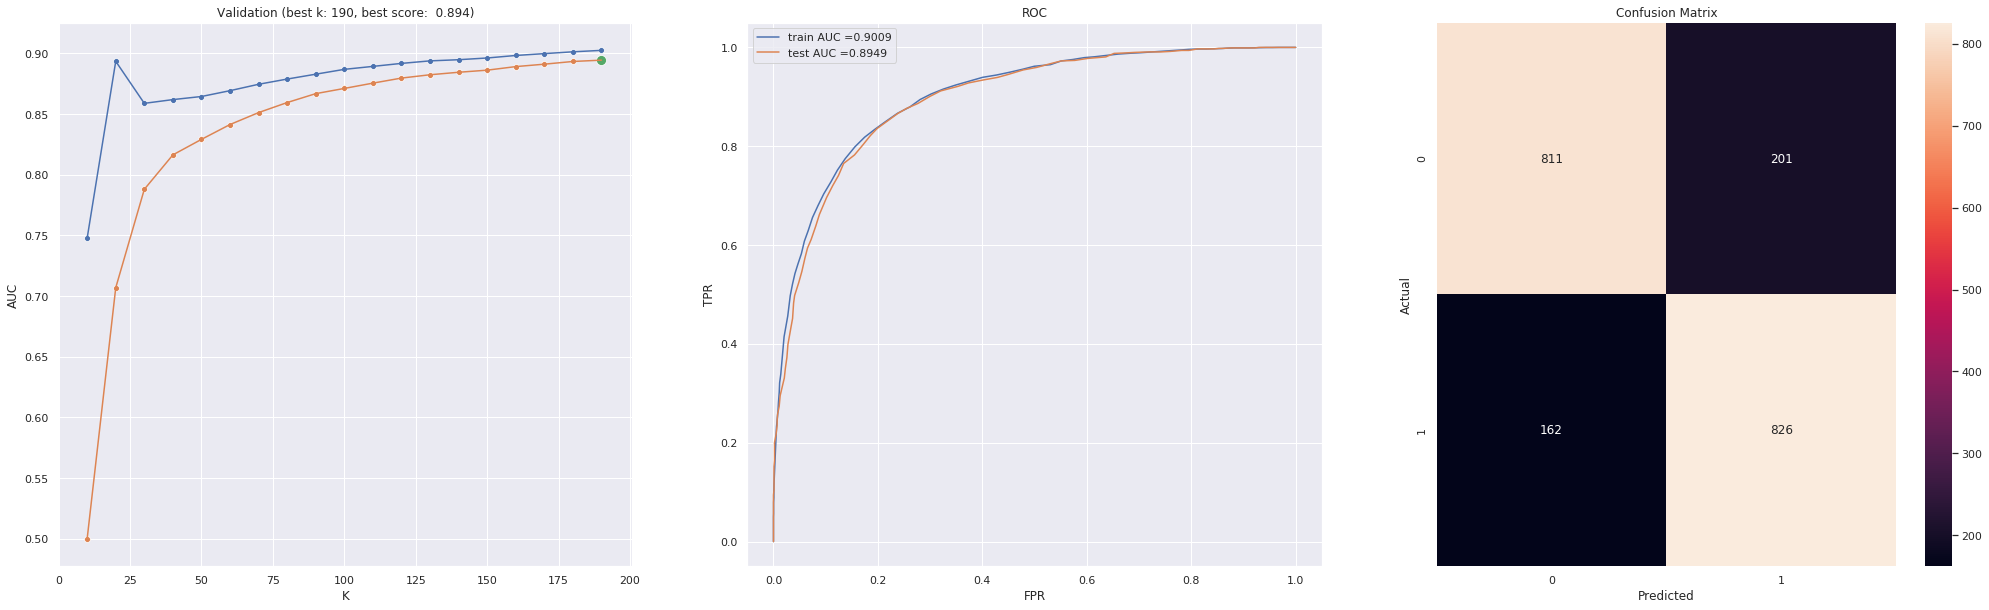

In [141]:
from sklearn.metrics import confusion_matrix

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Set 6: TFIDF features & k-d tree

In [142]:
## featureization
vectorizer = TfidfVectorizer(min_df=10, max_features=500) #ngram_range=(1,2)

X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

X_train_tfidf.shape,X_test_tfidf.shape

((8000, 500), (2000, 500))

In [143]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_params = {'n_neighbors': list(range(10,200,10))}

model = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)

model.fit(X_train_tfidf,Y_train);

Fitting 10 folds for each of 19 candidates, totalling 190 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  5.2min
[Paralle

[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed: 37.9min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed: 37.9min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed: 38.0min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed: 38.0min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed: 38.3min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed: 39.3min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed: 39.5min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed: 39.6min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed: 39.7min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed: 39.7min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed: 39.9min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed: 40.9min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed: 41.2min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed: 41.3min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed: 41.3min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed: 41.3min
[Parallel(n_jobs=6)]: Do

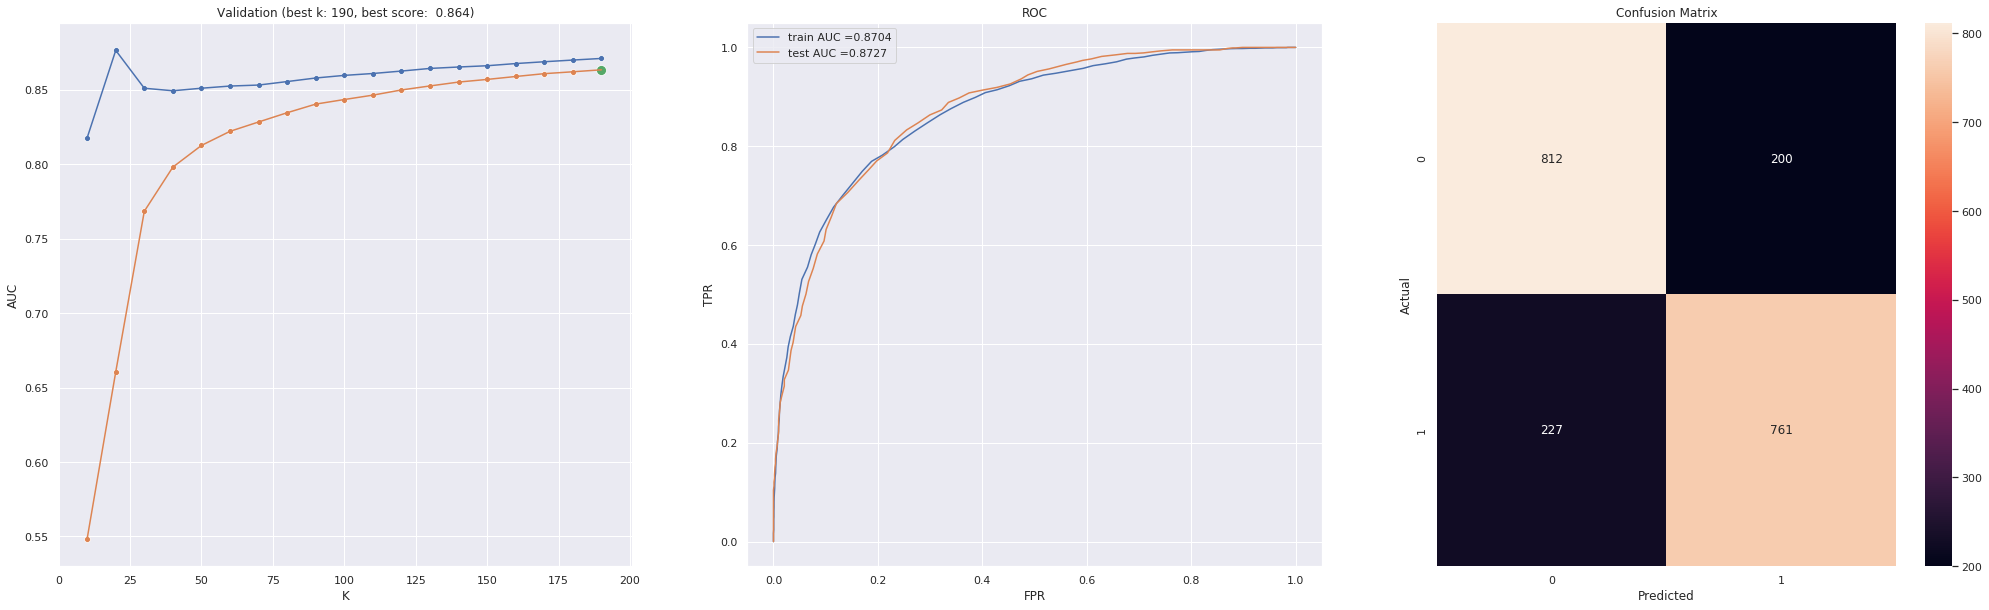

In [148]:
from sklearn.metrics import confusion_matrix

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Word2Vec Features

Since the no of features (300) is far less than the BOW and TFIDF also require more data to learn language semantics I have doubled the size (10000)  

In [4]:
data_pos = final[final["Score"] == 'positive'].sample(n = 10000)
data_neg = final[final["Score"] == 'negative'].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])

X = final_20k.Cleaned_text
Y = final_20k.Score

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
#X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.25,random_state=0)

print("Split size")
X_train.shape,X_test.shape

Split size


((16000,), (4000,))

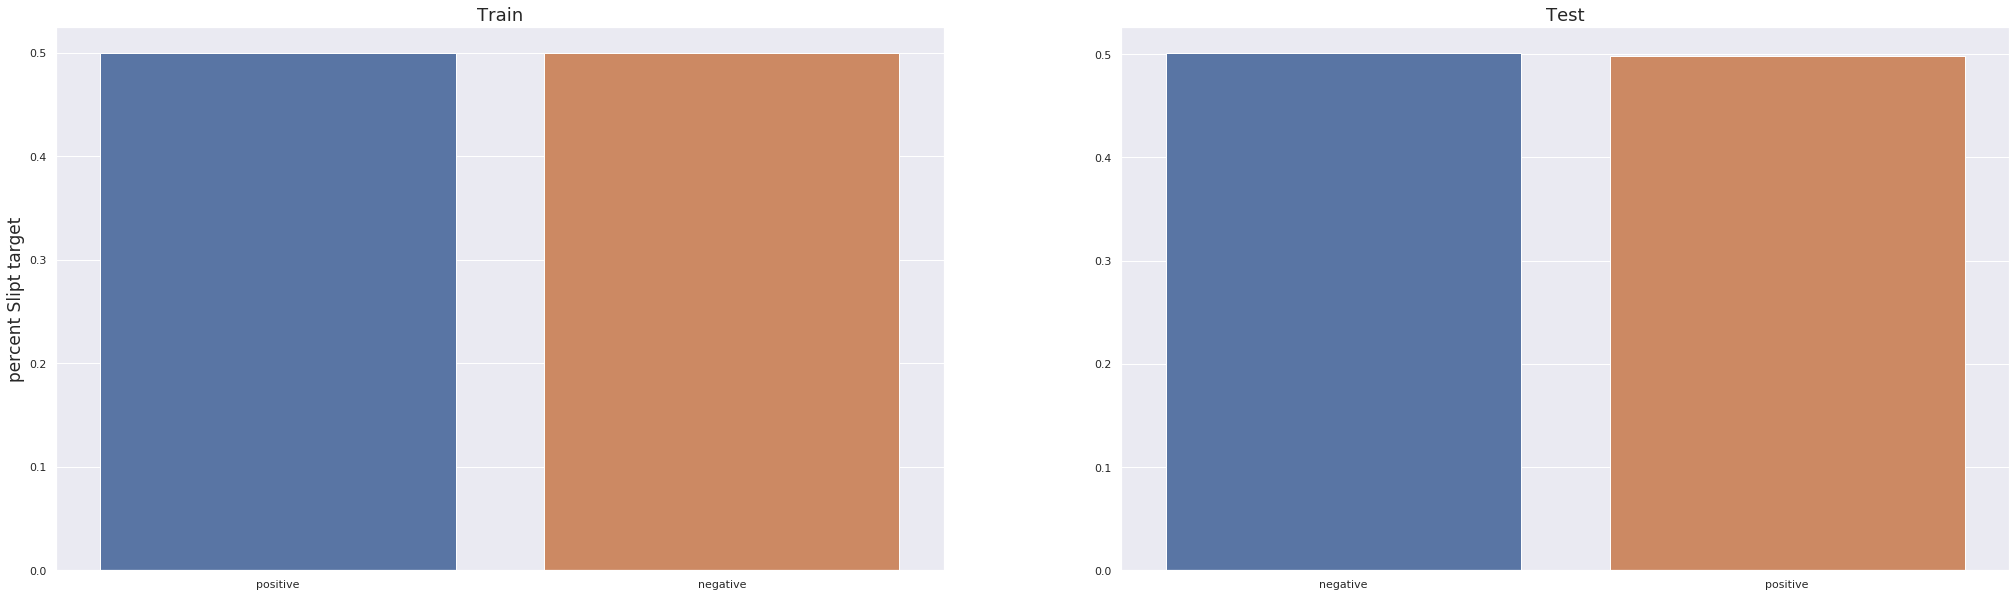

In [23]:
## Check whether the class are properly split among the three sets
%matplotlib inline
sns.set() # setting seaborn default for plots

plt.figure(figsize=(35,10))

# Train
plt.subplot(121)
sns.barplot(x = Y_train.value_counts().index,y = Y_train.value_counts(normalize=True));
plt.title('Train',fontsize = 18)
plt.xlabel('',fontsize = 16)
plt.ylabel('percent Slipt target',fontsize = 17)

## Valid
#plt.subplot(122)
#sns.barplot(x = Y_cv.value_counts().index,y = Y_cv.value_counts(normalize=True));
#plt.title('Valid',fontsize = 18)
#plt.xlabel('',fontsize = 16)
#plt.ylabel(None);

# Test
plt.subplot(122)
sns.barplot(x = Y_test.value_counts().index,y = Y_test.value_counts(normalize=True));
plt.title('Test',fontsize = 18)
plt.xlabel('',fontsize = 16)
plt.ylabel(None);

In [7]:
i=0

list_of_sentance=[]
for sentance in tqdm(X_train):
    list_of_sentance.append(sentance.split())

In [8]:
# this line of code trains your w2v model on the give list of sentances 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [11]:
w2v_model.vector_size

50

#### Avg-W2V Features

In [26]:
## load trained word2vec model and vocabualary
#w2v_model = KeyedVectors.load_word2vec_format('w2v_model.bin', binary=True)



def Avg_W2vgen(X):
    list_of_sentance=[]
    for sentance in tqdm(X):
        list_of_sentance.append(sentance.split())
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors


In [32]:
X_train_avg_wv = Avg_W2vgen(X_train).to_array()
X_test_avg_wv = Avg_W2vgen(X_test).to_array()

/home/skumar/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


AttributeError: 'list' object has no attribute 'to_array'

#### Set 3: Avg - WV features & Brute force

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_params = {'n_neighbors': list(range(5,200,10))}

model = GridSearchCV(KNeighborsClassifier(algorithm='brute'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)
model.fit(X_train_avg_wv,Y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   14.8s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   16.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   16.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   27.1s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   28.9s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   30.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   30.4s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   31.6s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   31.8s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   40.7s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   41.5s
[Paralle

[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=6,
             param_grid={'n_neighbors': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95,
                                         105, 115, 125, 135, 145, 155, 165, 175,
                                         185, 195]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=50)

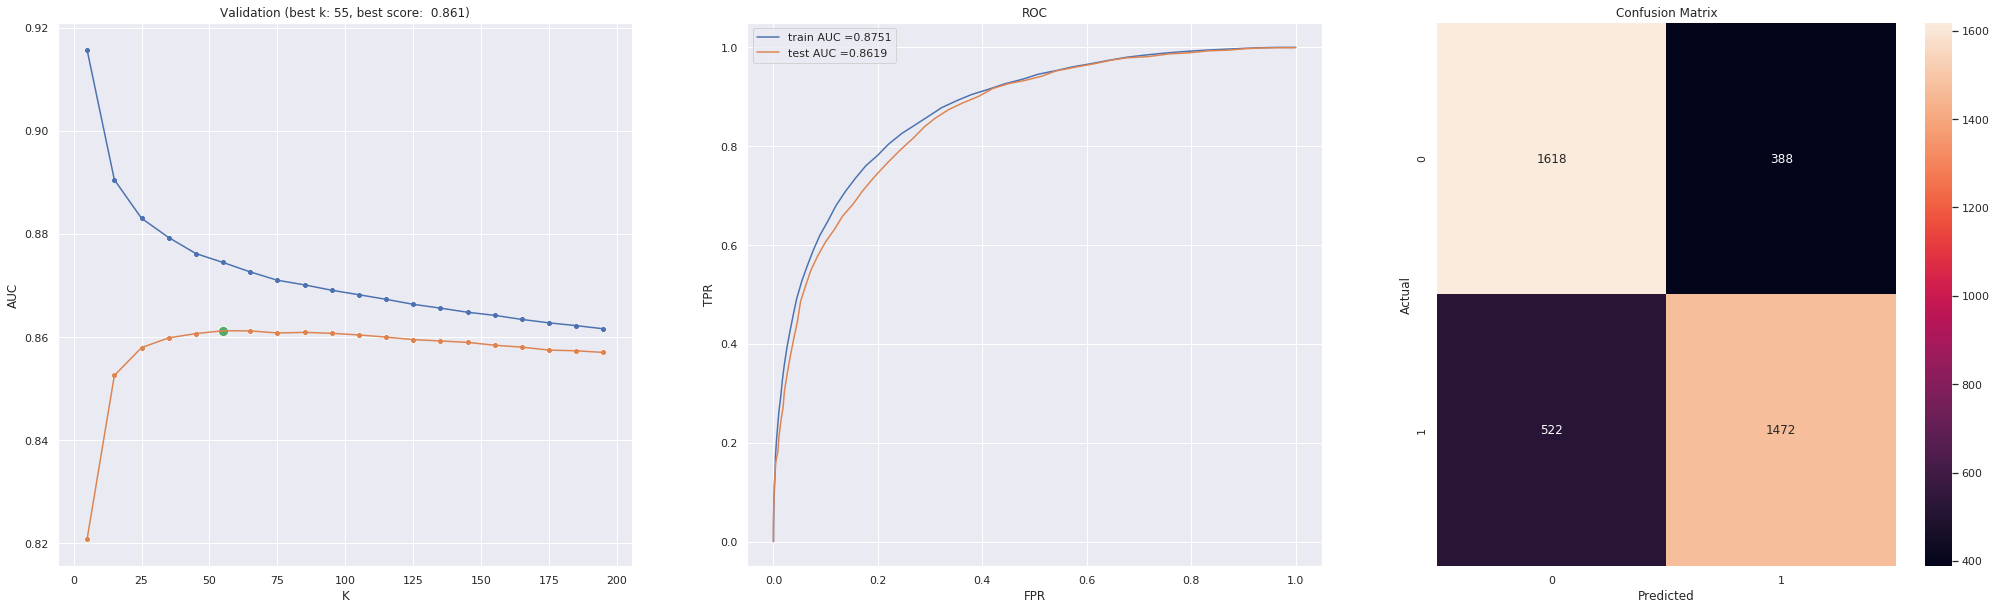

In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_avg_wv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_avg_wv)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_avg_wv))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Set 3: Avg - WV features & kd_tree force

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_params = {'n_neighbors': list(range(10,200,5))}

model = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)
model.fit(X_train_avg_wv,Y_train)

Fitting 10 folds for each of 38 candidates, totalling 380 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   16.6s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   17.0s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   17.2s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   18.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   18.6s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   31.9s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   32.4s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   32.5s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   34.0s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   34.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   48.8s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   49.9s
[Paralle

[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 269 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 270 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 271 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=6,
             param_grid={'n_neighbors': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55,
                                         60, 65, 70, 75, 80, 85, 90, 95, 100,
                                         105, 110, 115, 120, 125, 130, 135, 140,
                                         145, 150, 155, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=50)

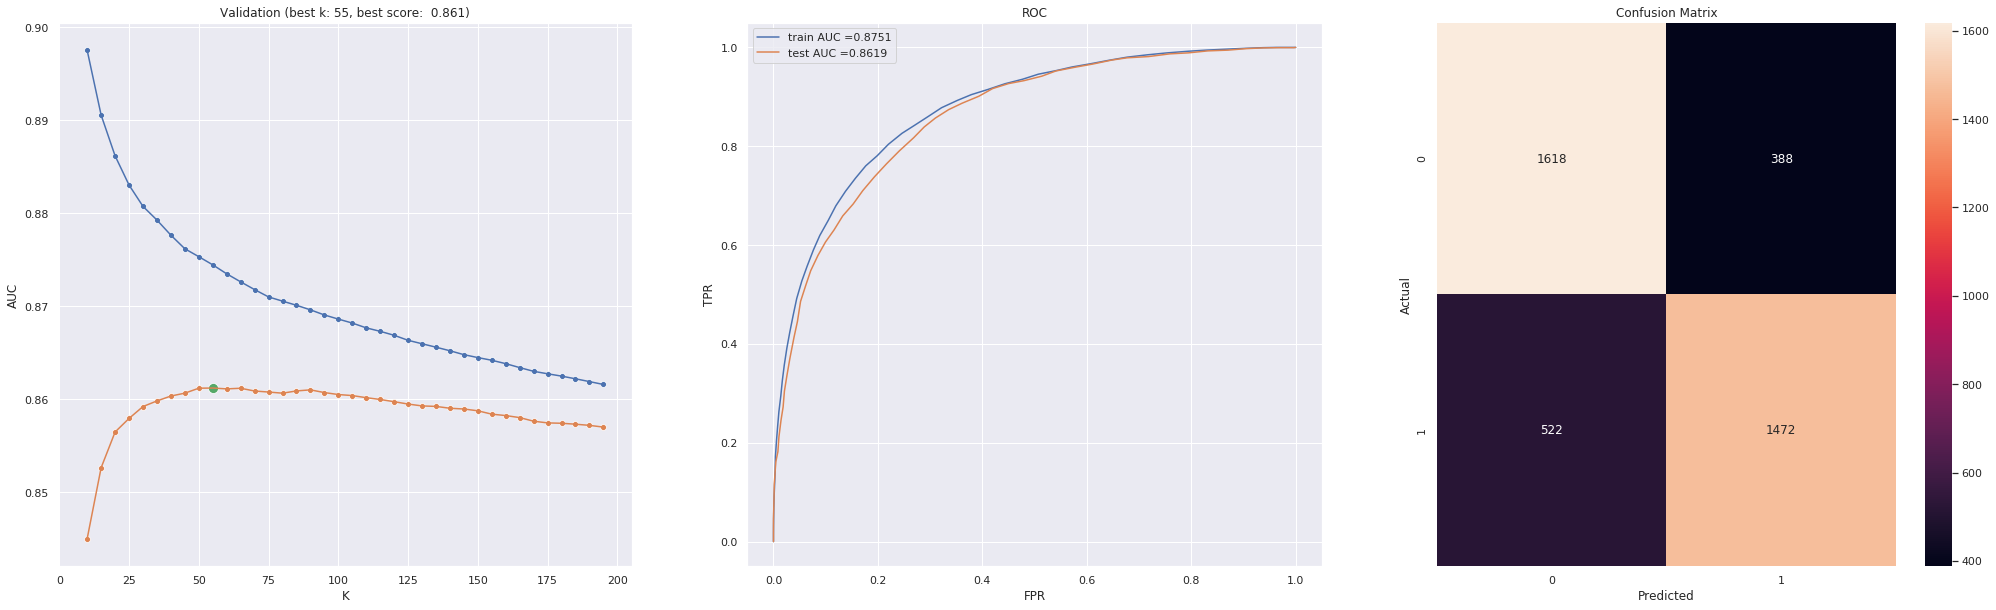

In [51]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_avg_wv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_avg_wv)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_avg_wv))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### TFIDF weighted WV Features

In [13]:
## TFIDF Matrix
tfidf_vectoirizer = TfidfVectorizer()
tf_idf_matrix = tfidf_vectoirizer.fit_transform(X_train)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_vectoirizer.get_feature_names(), list(tfidf_vectoirizer.idf_)))

In [15]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vectoirizer.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf


def tfidf_wt_W2Vgen(X):
    list_of_sentance=[]
    for sentance in tqdm(X):
        list_of_sentance.append(sentance.split())
    
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [16]:
X_train_tfidf_wv = tfidf_wt_W2Vgen(X_train)
X_test_tfidf_wv = tfidf_wt_W2Vgen(X_test)

#### Tfidf-W2v and Brute

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_params = {'n_neighbors': list(range(10,200,5))}

model = GridSearchCV(KNeighborsClassifier(algorithm='brute'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)
model.fit(X_train_tfidf_wv,Y_train)

Fitting 10 folds for each of 38 candidates, totalling 380 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   14.6s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   18.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   19.8s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   27.3s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   32.1s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   32.7s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   33.6s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   34.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   40.6s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   45.0s
[Paralle

[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 269 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 270 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 271 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=6,
             param_grid={'n_neighbors': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55,
                                         60, 65, 70, 75, 80, 85, 90, 95, 100,
                                         105, 110, 115, 120, 125, 130, 135, 140,
                                         145, 150, 155, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=50)

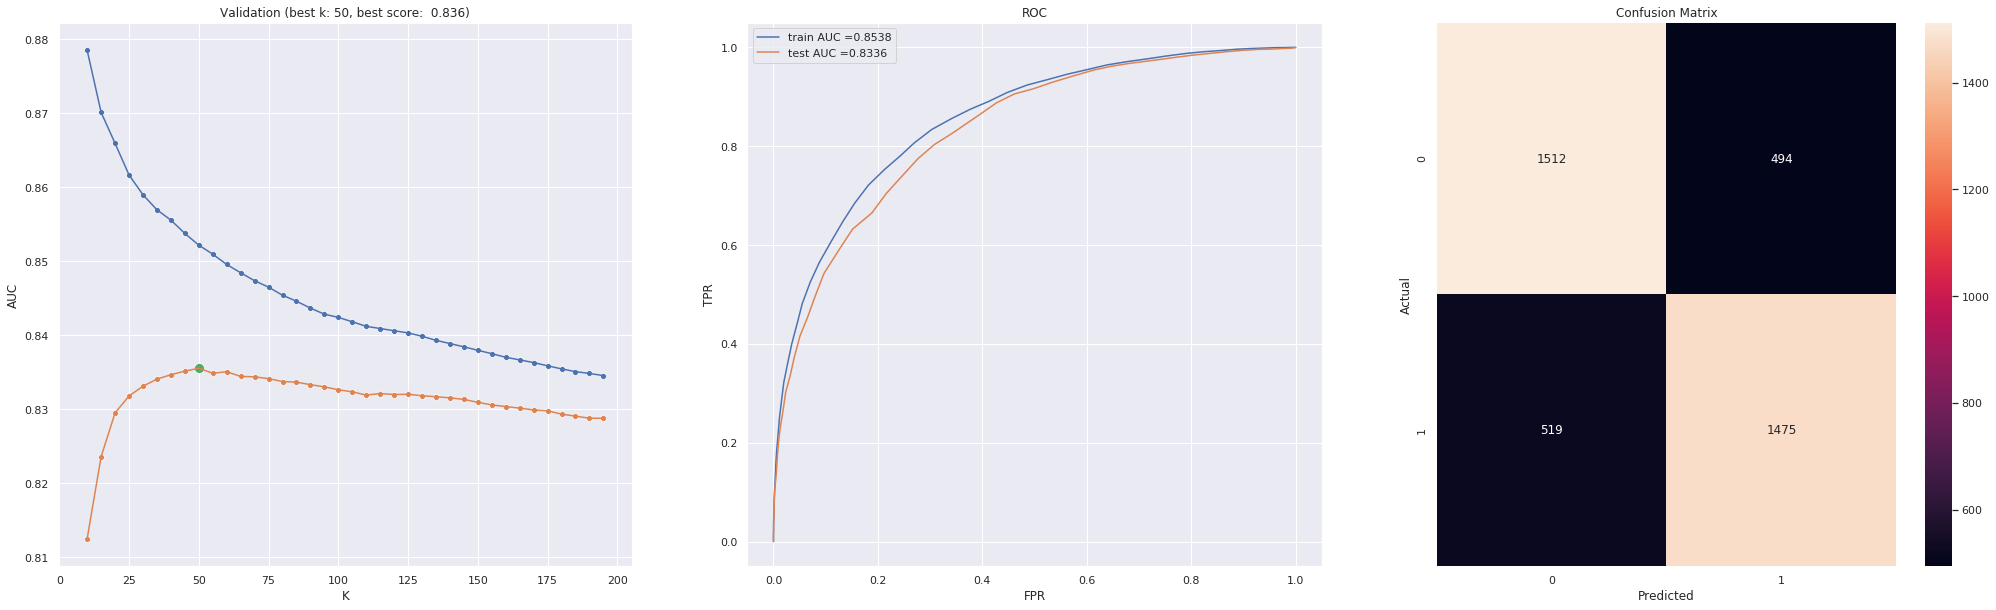

In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf_wv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf_wv)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_tfidf_wv))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Tfidf-W2v and kd-tree

In [48]:
k_params = {'n_neighbors': list(range(10,200,5))}

model = GridSearchCV(KNeighborsClassifier(algorithm='kd_tree'),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)
model.fit(X_train_tfidf_wv,Y_train)

Fitting 10 folds for each of 38 candidates, totalling 380 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   14.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   15.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:   26.2s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:   26.4s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:   26.9s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:   28.1s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:   28.1s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:   29.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   41.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:   41.4s
[Paralle

[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 269 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 270 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 271 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=6,
             param_grid={'n_neighbors': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55,
                                         60, 65, 70, 75, 80, 85, 90, 95, 100,
                                         105, 110, 115, 120, 125, 130, 135, 140,
                                         145, 150, 155, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=50)

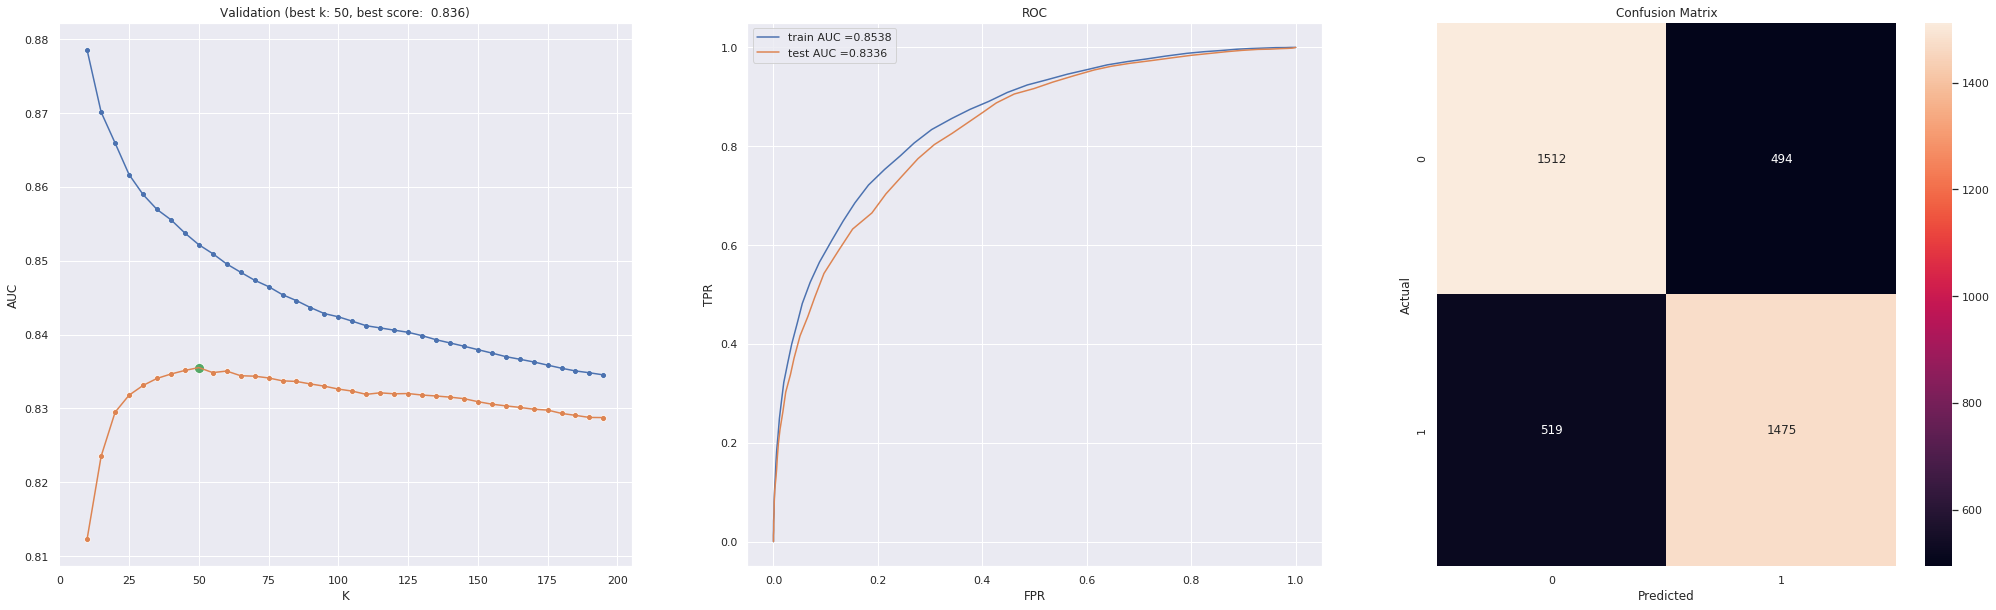

In [49]:

# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(35,10))

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(results.param_n_neighbors,results.mean_train_score)
sns.lineplot(results.param_n_neighbors,results.mean_test_score)

sns.scatterplot(results.param_n_neighbors,results.mean_train_score)
sns.scatterplot(results.param_n_neighbors,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_n_neighbors[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("K")
plt.ylabel("AUC")
plt.title(f"Validation (best k: {results.param_n_neighbors[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf_wv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf_wv)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_tfidf_wv))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### K-NN Validtaion results

In [54]:
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
comparison.add_row(["BOW", 'brute', 80,0.772])
comparison.add_row(["TFIDF", 'brute', 190, 0.895])
comparison.add_row(["AVG W2V", 'brute', 55, 0.861])
comparison.add_row(["TFIDF Weighted W2V", 'brute', 50,0.834])
comparison.add_row(["BOW", 'kd_tree', 160, 0.792])
comparison.add_row(["TFIDF", 'kd_tree', 190, 0.873])
comparison.add_row(["AVG W2V", 'kd_tree', 55, 0.861])
comparison.add_row(["TFIDF Weighted W2V", 'kd_tree', 50, 0.834])
print(comparison)


+--------------------+---------+----------------+-------+
|     Vectorizer     |  Model  | Hyperparameter |  AUC  |
+--------------------+---------+----------------+-------+
|        BOW         |  brute  |       80       | 0.772 |
|       TFIDF        |  brute  |      190       | 0.895 |
|      AVG W2V       |  brute  |       55       | 0.861 |
| TFIDF Weighted W2V |  brute  |       50       | 0.834 |
|        BOW         | kd_tree |      160       | 0.792 |
|       TFIDF        | kd_tree |      190       | 0.873 |
|      AVG W2V       | kd_tree |       55       | 0.861 |
| TFIDF Weighted W2V | kd_tree |       50       | 0.834 |
+--------------------+---------+----------------+-------+


*  KNN with 'brute' algorithm fitted to TFIDF features yeilds max of 0.895 AUC 

## Naive-Bayes Classifier

since naive bayes is not memmory intensive will take upto 10000 example of each class

In [4]:
data_pos = final[final["Score"] == 'positive'].sample(n = 10000)
data_neg = final[final["Score"] == 'negative'].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])

X = final_20k.Cleaned_text
Y = final_20k.Score

In [5]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
#X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.25,random_state=0)

print("Split size")
X_train.shape,X_test.shape

Split size


((16000,), (4000,))

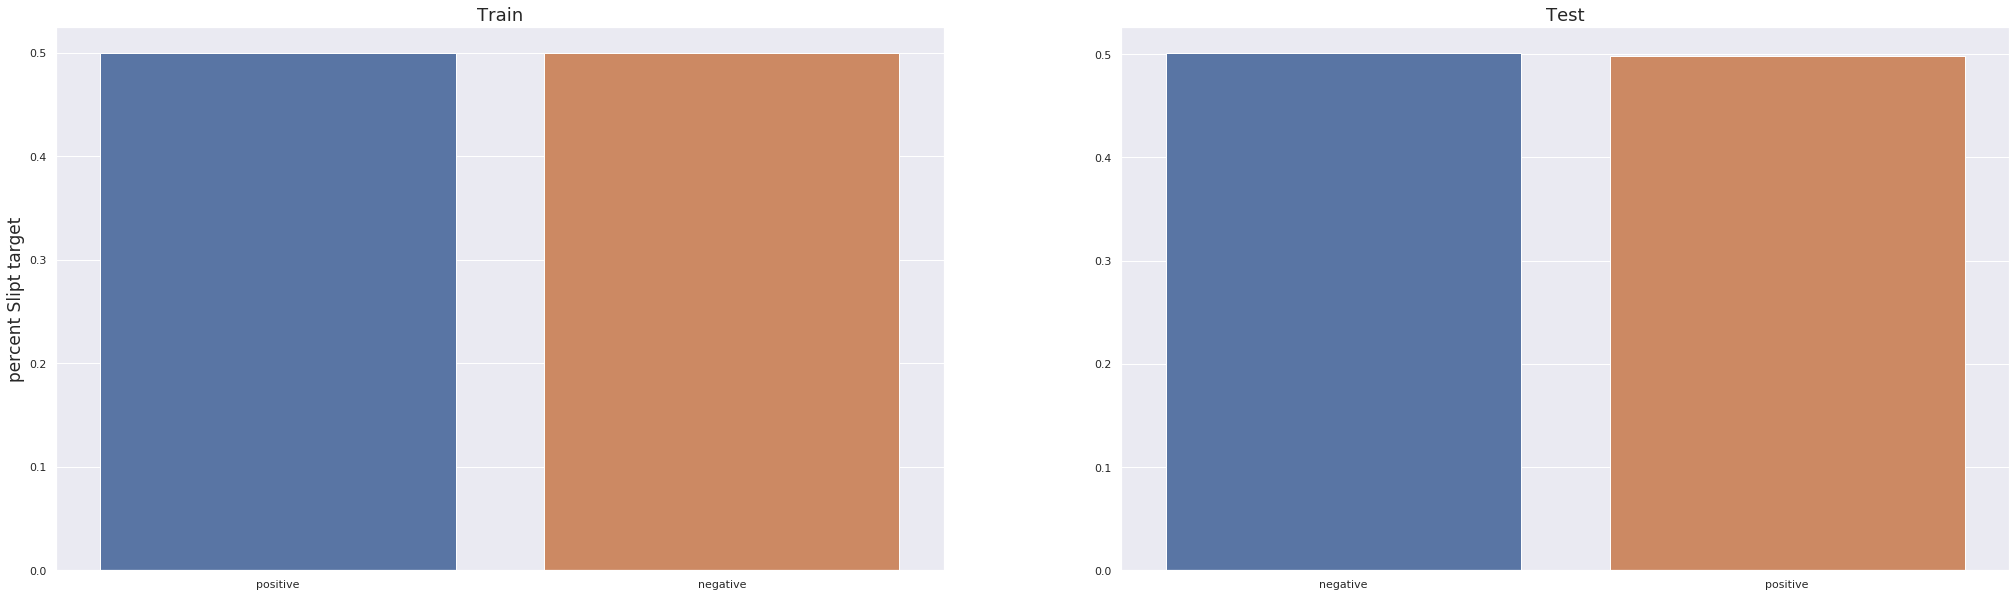

In [25]:
## Check whether the class are properly split among the three sets
%matplotlib inline
sns.set() # setting seaborn default for plots

plt.figure(figsize=(35,10))

# Train
plt.subplot(121)
sns.barplot(x = Y_train.value_counts().index,y = Y_train.value_counts(normalize=True));
plt.title('Train',fontsize = 18)
plt.xlabel('',fontsize = 16)
plt.ylabel('percent Slipt target',fontsize = 17)

## Valid
#plt.subplot(122)
#sns.barplot(x = Y_cv.value_counts().index,y = Y_cv.value_counts(normalize=True));
#plt.title('Valid',fontsize = 18)
#plt.xlabel('',fontsize = 16)
#plt.ylabel(None);

# Test
plt.subplot(122)
sns.barplot(x = Y_test.value_counts().index,y = Y_test.value_counts(normalize=True));
plt.title('Test',fontsize = 18)
plt.xlabel('',fontsize = 16)
plt.ylabel(None);

### SET 1 BOW

#### plain BOW

In [52]:
# Create the pipeline 
clf = Pipeline([('vectorize', CountVectorizer()),
                         ('model', MultinomialNB())])

param_grid = {'model__alpha': list(range(-10,20)),
             'vectorize__binary': [True],
             'vectorize__max_features': [None],
             'vectorize__min_df': [5],
             'vectorize__ngram_range': [(1, 2)]}

param_grid = {'vectorize__binary' : [True, False],
              'vectorize__ngram_range': [(1, 1),(1, 2)],
              'vectorize__min_df':[5,10,25,50,100],
              'vectorize__max_features':[None,5000,7500,10000],
              'model__alpha': [round(0.001*10**i,5) for i in range(7)]+list(range(1,20))}



In [55]:



model = GridSearchCV(clf,param_grid = param_grid, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train)

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   54.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  8.8min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 11.9min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 15.5min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 19.6min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 24.2min
[Paralle

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

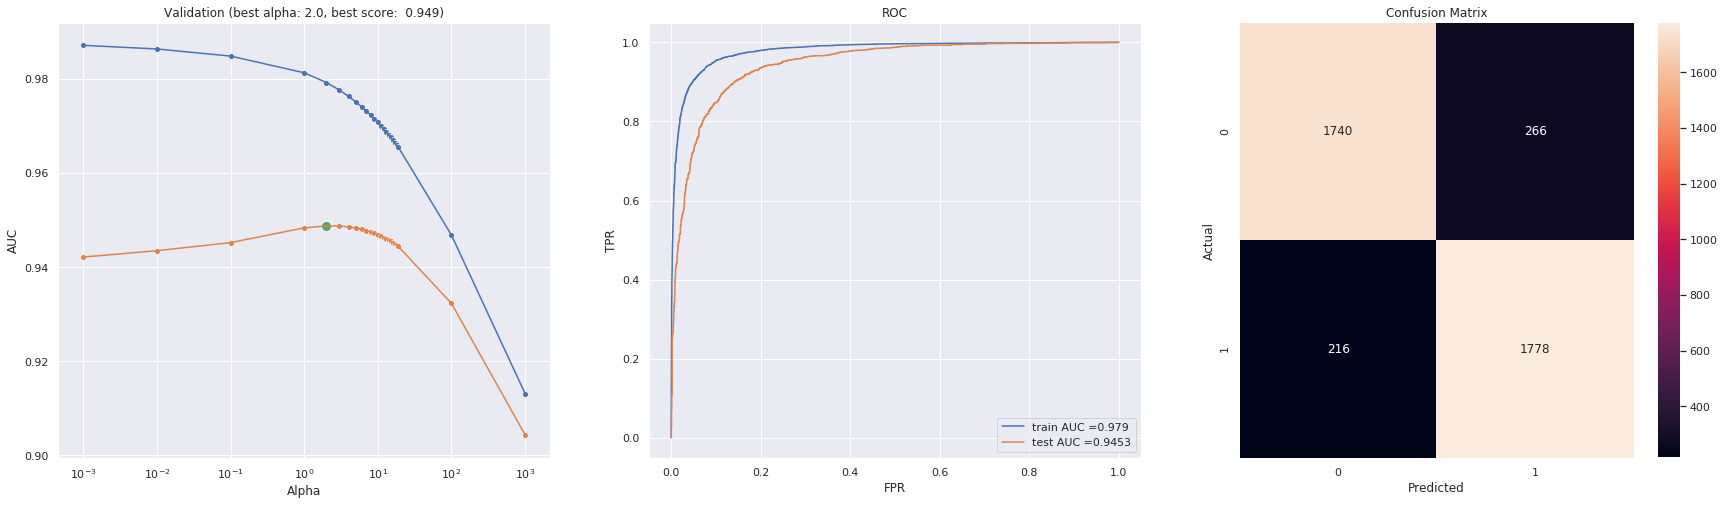

In [56]:


# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)

mean_train_score = results.groupby('param_model__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model__alpha')['mean_test_score'].max()

plt.figure(figsize=(30,8))

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"Validation (best alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [57]:
model.best_params_

{'model__alpha': 2,
 'vectorize__binary': True,
 'vectorize__max_features': None,
 'vectorize__min_df': 5,
 'vectorize__ngram_range': (1, 2)}

In [31]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__alpha', 'param_vectorize__binary',
       'param_vectorize__max_features', 'param_vectorize__min_df',
       'param_vectorize__ngram_range', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [43]:
## Top features ofr both the class
[vectorizer.get_feature_names()[i] for i in  model.[1, :].argsort()[-10:]]

AttributeError: 'Pipeline' object has no attribute 'feature_log_prob_'

In [74]:
[vectorizer.get_feature_names()[i] for i in  model.best_estimator_.feature_log_prob_[0, :].argsort()[-10:]]

['flavor',
 'coffee',
 'no',
 'good',
 'one',
 'would',
 'product',
 'taste',
 'like',
 'not']

### TFIDF

In [58]:
# Create the pipeline 
clf = Pipeline([('vectorize', TfidfVectorizer()),
                         ('model', MultinomialNB())])


param_grid = {'vectorize__binary' : [True, False],
              'vectorize__ngram_range': [(1, 1),(1, 2)],
              'vectorize__min_df':[5,10,25,50,100],
              'vectorize__max_features':[None,5000,7500,10000],
              'model__alpha': [round(0.001*10**i,5) for i in range(7)]+list(range(1,20))}



In [59]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=12,verbose=1)
model.fit(X_train,Y_train)

Fitting 10 folds for each of 2080 candidates, totalling 20800 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   50.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed: 11.5min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 4976 tasks      | elapsed: 23.5min
[Parallel(n_jobs=12)]: Done 6026 tasks      | elapsed: 28.3min
[Parallel(n_jobs=12)]: Done 7176 tasks      | elapsed: 33.5min
[Parallel(n_jobs=12)]: Done 8426 tasks      | elapsed: 39.2min
[Parallel(n_jobs=12)]: Done 9776 tasks      | elapsed: 45.3min
[Parallel(n_jobs=12)]: Done 11226 tasks      

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorize',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

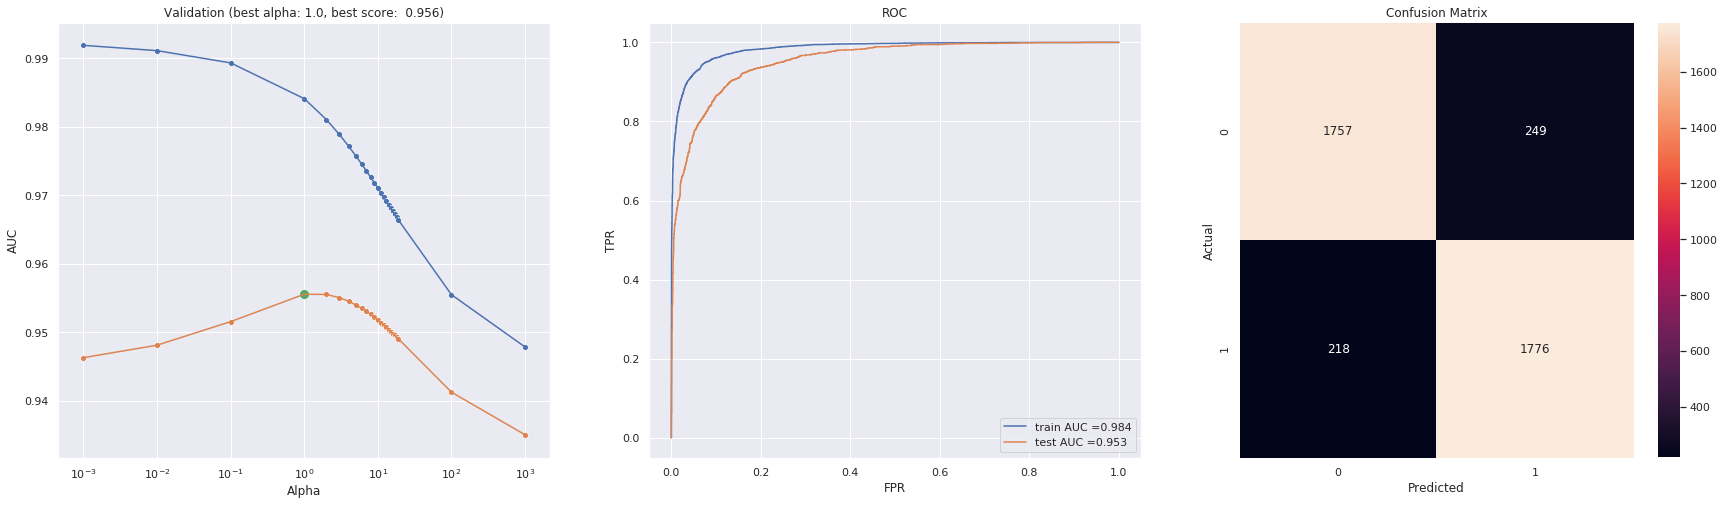

In [60]:

# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)

mean_train_score = results.groupby('param_model__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model__alpha')['mean_test_score'].max()

plt.figure(figsize=(30,8))

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"Validation (best alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
!shutdown -h 5

Shutdown scheduled for Tue 2020-05-19 23:55:26 IST, use 'shutdown -c' to cancel.


In [82]:
## featureization
vectorizer = TfidfVectorizer(ngram_range=(1,2) max_features = 10000) #ngram_range=(1,2)

X_train_tfidf = vectorizer.fit_transform(X_train)
#X_cv_bow = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf.shape,X_test_tfidf.shape

((16000, 400466), (4000, 400466))

In [95]:

#k_params = {'alpha': [round(0.00001*10**i,5) for i in range(10)]+list(range(-10,20))}
k_params = {'alpha': [round(0.00001+5*i,5) for i in range(10**5)]}

model = GridSearchCV(MultinomialNB(),param_grid = k_params, cv = 10, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=50)
model.fit(X_train_tfidf,Y_train)

Fitting 10 folds for each of 100000 candidates, totalling 1000000 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    1.2s


[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:    5.5s
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 152 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 153 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 154 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done 155 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done 156 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 289 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 290 tasks      | elapsed:    9.8s
[Parallel(n_jobs=6)]: Done 291 tasks      | elapsed:    9.8s
[Parallel(n_jobs=6)]: Done 292 tasks      | elapsed:    9.8s
[Parallel(n_jobs=6)]: Done 293 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 294 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 295 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 296 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 297 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Done 298 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 421 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 422 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 423 tasks      | elapsed:   13.6s
[Parallel(n_jobs=6)]: Done 424 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 425 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done 426 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Done 427 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Done 429 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Done 430 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done 431 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done 432 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done 433 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done 434 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done 435 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done 436 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 560 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done 561 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done 562 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done 563 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done 564 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done 565 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done 566 tasks      | elapsed:   18.0s
[Parallel(n_jobs=6)]: Done 567 tasks      | elapsed:   18.1s
[Parallel(n_jobs=6)]: Done 568 tasks      | elapsed:   18.1s
[Parallel(n_jobs=6)]: Done 569 tasks      | elapsed:   18.1s
[Parallel(n_jobs=6)]: Done 570 tasks      | elapsed:   18.1s
[Parallel(n_jobs=6)]: Done 571 tasks      | elapsed:   18.1s
[Parallel(n_jobs=6)]: Done 572 tasks      | elapsed:   18.2s
[Parallel(n_jobs=6)]: Done 573 tasks      | elapsed:   18.2s
[Parallel(n_jobs=6)]: Done 574 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done 575 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 695 tasks      | elapsed:   22.1s
[Parallel(n_jobs=6)]: Done 696 tasks      | elapsed:   22.2s
[Parallel(n_jobs=6)]: Done 697 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 698 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 699 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 700 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 701 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 702 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 703 tasks      | elapsed:   22.5s
[Parallel(n_jobs=6)]: Done 704 tasks      | elapsed:   22.5s
[Parallel(n_jobs=6)]: Done 705 tasks      | elapsed:   22.5s
[Parallel(n_jobs=6)]: Done 706 tasks      | elapsed:   22.5s
[Parallel(n_jobs=6)]: Done 707 tasks      | elapsed:   22.5s
[Parallel(n_jobs=6)]: Done 708 tasks      | elapsed:   22.5s
[Parallel(n_jobs=6)]: Done 709 tasks      | elapsed:   22.6s
[Parallel(n_jobs=6)]: Done 710 tasks      | elapsed:   22.7s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 834 tasks      | elapsed:   26.4s
[Parallel(n_jobs=6)]: Done 835 tasks      | elapsed:   26.4s
[Parallel(n_jobs=6)]: Done 836 tasks      | elapsed:   26.4s
[Parallel(n_jobs=6)]: Done 837 tasks      | elapsed:   26.5s
[Parallel(n_jobs=6)]: Done 838 tasks      | elapsed:   26.5s
[Parallel(n_jobs=6)]: Done 839 tasks      | elapsed:   26.5s
[Parallel(n_jobs=6)]: Done 840 tasks      | elapsed:   26.5s
[Parallel(n_jobs=6)]: Done 841 tasks      | elapsed:   26.6s
[Parallel(n_jobs=6)]: Done 842 tasks      | elapsed:   26.6s
[Parallel(n_jobs=6)]: Done 843 tasks      | elapsed:   26.6s
[Parallel(n_jobs=6)]: Done 844 tasks      | elapsed:   26.7s
[Parallel(n_jobs=6)]: Done 845 tasks      | elapsed:   26.7s
[Parallel(n_jobs=6)]: Done 846 tasks      | elapsed:   26.7s
[Parallel(n_jobs=6)]: Done 847 tasks      | elapsed:   26.8s
[Parallel(n_jobs=6)]: Done 848 tasks      | elapsed:   26.8s
[Parallel(n_jobs=6)]: Done 849 tasks      | elapsed:   26.8s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 970 tasks      | elapsed:   30.4s
[Parallel(n_jobs=6)]: Done 971 tasks      | elapsed:   30.4s
[Parallel(n_jobs=6)]: Done 972 tasks      | elapsed:   30.5s
[Parallel(n_jobs=6)]: Done 973 tasks      | elapsed:   30.5s
[Parallel(n_jobs=6)]: Done 974 tasks      | elapsed:   30.6s
[Parallel(n_jobs=6)]: Done 975 tasks      | elapsed:   30.6s
[Parallel(n_jobs=6)]: Done 976 tasks      | elapsed:   30.6s
[Parallel(n_jobs=6)]: Done 977 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done 978 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done 979 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done 980 tasks      | elapsed:   30.7s
[Parallel(n_jobs=6)]: Done 981 tasks      | elapsed:   30.8s
[Parallel(n_jobs=6)]: Done 982 tasks      | elapsed:   30.8s
[Parallel(n_jobs=6)]: Done 983 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done 984 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Done 985 tasks      | elapsed:   30.9s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 1105 tasks      | elapsed:   34.7s
[Parallel(n_jobs=6)]: Done 1106 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 1107 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 1108 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 1109 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 1110 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 1111 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 1112 tasks      | elapsed:   34.9s
[Parallel(n_jobs=6)]: Done 1113 tasks      | elapsed:   34.9s
[Parallel(n_jobs=6)]: Done 1114 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done 1115 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done 1116 tasks      | elapsed:   35.0s
[Parallel(n_jobs=6)]: Done 1117 tasks      | elapsed:   35.1s
[Parallel(n_jobs=6)]: Done 1118 tasks      | elapsed:   35.1s
[Parallel(n_jobs=6)]: Done 1119 tasks      | elapsed:   35.1s
[Parallel(n_jobs=6)]: Done 1120 tasks      | elapsed:   35.1s
[Paralle

[Parallel(n_jobs=6)]: Done 1244 tasks      | elapsed:   38.9s
[Parallel(n_jobs=6)]: Done 1245 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1246 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1247 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1248 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1249 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1250 tasks      | elapsed:   39.1s
[Parallel(n_jobs=6)]: Done 1251 tasks      | elapsed:   39.1s
[Parallel(n_jobs=6)]: Done 1252 tasks      | elapsed:   39.2s
[Parallel(n_jobs=6)]: Done 1253 tasks      | elapsed:   39.2s
[Parallel(n_jobs=6)]: Done 1254 tasks      | elapsed:   39.2s
[Parallel(n_jobs=6)]: Done 1255 tasks      | elapsed:   39.2s
[Parallel(n_jobs=6)]: Done 1256 tasks      | elapsed:   39.3s
[Parallel(n_jobs=6)]: Done 1257 tasks      | elapsed:   39.3s
[Parallel(n_jobs=6)]: Done 1258 tasks      | elapsed:   39.3s
[Parallel(n_jobs=6)]: Done 1259 tasks      | elapsed:   39.4s
[Paralle

[Parallel(n_jobs=6)]: Done 1384 tasks      | elapsed:   43.2s
[Parallel(n_jobs=6)]: Done 1385 tasks      | elapsed:   43.3s
[Parallel(n_jobs=6)]: Done 1386 tasks      | elapsed:   43.3s
[Parallel(n_jobs=6)]: Done 1387 tasks      | elapsed:   43.3s
[Parallel(n_jobs=6)]: Done 1388 tasks      | elapsed:   43.4s
[Parallel(n_jobs=6)]: Done 1389 tasks      | elapsed:   43.4s
[Parallel(n_jobs=6)]: Done 1390 tasks      | elapsed:   43.4s
[Parallel(n_jobs=6)]: Done 1391 tasks      | elapsed:   43.4s
[Parallel(n_jobs=6)]: Done 1392 tasks      | elapsed:   43.5s
[Parallel(n_jobs=6)]: Done 1393 tasks      | elapsed:   43.5s
[Parallel(n_jobs=6)]: Done 1394 tasks      | elapsed:   43.6s
[Parallel(n_jobs=6)]: Done 1395 tasks      | elapsed:   43.6s
[Parallel(n_jobs=6)]: Done 1396 tasks      | elapsed:   43.6s
[Parallel(n_jobs=6)]: Done 1397 tasks      | elapsed:   43.6s
[Parallel(n_jobs=6)]: Done 1398 tasks      | elapsed:   43.6s
[Parallel(n_jobs=6)]: Done 1399 tasks      | elapsed:   43.7s
[Paralle

[Parallel(n_jobs=6)]: Done 1518 tasks      | elapsed:   47.3s
[Parallel(n_jobs=6)]: Done 1519 tasks      | elapsed:   47.3s
[Parallel(n_jobs=6)]: Done 1520 tasks      | elapsed:   47.3s
[Parallel(n_jobs=6)]: Done 1521 tasks      | elapsed:   47.4s
[Parallel(n_jobs=6)]: Done 1522 tasks      | elapsed:   47.5s
[Parallel(n_jobs=6)]: Done 1523 tasks      | elapsed:   47.5s
[Parallel(n_jobs=6)]: Done 1524 tasks      | elapsed:   47.5s
[Parallel(n_jobs=6)]: Done 1525 tasks      | elapsed:   47.5s
[Parallel(n_jobs=6)]: Done 1526 tasks      | elapsed:   47.5s
[Parallel(n_jobs=6)]: Done 1527 tasks      | elapsed:   47.6s
[Parallel(n_jobs=6)]: Done 1528 tasks      | elapsed:   47.6s
[Parallel(n_jobs=6)]: Done 1529 tasks      | elapsed:   47.7s
[Parallel(n_jobs=6)]: Done 1530 tasks      | elapsed:   47.7s
[Parallel(n_jobs=6)]: Done 1531 tasks      | elapsed:   47.7s
[Parallel(n_jobs=6)]: Done 1532 tasks      | elapsed:   47.7s
[Parallel(n_jobs=6)]: Done 1533 tasks      | elapsed:   47.7s
[Paralle

[Parallel(n_jobs=6)]: Done 1654 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done 1655 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done 1656 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done 1657 tasks      | elapsed:   51.7s
[Parallel(n_jobs=6)]: Done 1658 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 1659 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 1660 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 1661 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 1662 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 1663 tasks      | elapsed:   51.9s
[Parallel(n_jobs=6)]: Done 1664 tasks      | elapsed:   52.0s
[Parallel(n_jobs=6)]: Done 1665 tasks      | elapsed:   52.0s
[Parallel(n_jobs=6)]: Done 1666 tasks      | elapsed:   52.1s
[Parallel(n_jobs=6)]: Done 1667 tasks      | elapsed:   52.1s
[Parallel(n_jobs=6)]: Done 1668 tasks      | elapsed:   52.1s
[Parallel(n_jobs=6)]: Done 1669 tasks      | elapsed:   52.2s
[Paralle

[Parallel(n_jobs=6)]: Done 1791 tasks      | elapsed:   55.9s
[Parallel(n_jobs=6)]: Done 1792 tasks      | elapsed:   55.9s
[Parallel(n_jobs=6)]: Done 1793 tasks      | elapsed:   55.9s
[Parallel(n_jobs=6)]: Done 1794 tasks      | elapsed:   55.9s
[Parallel(n_jobs=6)]: Done 1795 tasks      | elapsed:   56.0s
[Parallel(n_jobs=6)]: Done 1796 tasks      | elapsed:   56.0s
[Parallel(n_jobs=6)]: Done 1797 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done 1798 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done 1799 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done 1800 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done 1801 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done 1802 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done 1803 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done 1804 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done 1805 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done 1806 tasks      | elapsed:   56.3s
[Paralle

[Parallel(n_jobs=6)]: Done 1927 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1928 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1929 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1930 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1931 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1932 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1933 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1934 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1935 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1936 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1937 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1938 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1939 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1940 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1941 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1942 tasks      | elapsed:  1.0min
[Paralle

[Parallel(n_jobs=6)]: Done 2063 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2064 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2065 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2066 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2067 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2068 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2069 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2070 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2071 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2073 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2074 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2075 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2076 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2077 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2078 tasks      | elapsed:  1.1min
[Paralle

[Parallel(n_jobs=6)]: Done 2200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2201 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2202 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2203 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2204 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2205 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2206 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2207 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2208 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2209 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2210 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2211 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2212 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2213 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2214 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2215 tasks      | elapsed:  1.1min
[Paralle

[Parallel(n_jobs=6)]: Done 2338 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2339 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2340 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2341 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2342 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2343 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2344 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2345 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2346 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2347 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2348 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2350 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2351 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2352 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2353 tasks      | elapsed:  1.2min
[Paralle

[Parallel(n_jobs=6)]: Done 2479 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2480 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2481 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2482 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2483 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2484 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2485 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2486 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2487 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2488 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2489 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2490 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2491 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2492 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2493 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2494 tasks      | elapsed:  1.3min
[Paralle

[Parallel(n_jobs=6)]: Done 2620 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2621 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2622 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2623 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2625 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2626 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2627 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2628 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2629 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2630 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2631 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2633 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 2634 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2635 tasks      | elapsed:  1.4min
[Paralle

[Parallel(n_jobs=6)]: Done 2754 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2755 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2756 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2757 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2758 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2759 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2760 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2761 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2762 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2763 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2764 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2765 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2766 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2767 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2769 tasks      | elapsed:  1.4min
[Paralle

[Parallel(n_jobs=6)]: Done 2889 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2890 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2891 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2892 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2893 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2894 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2895 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2896 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2897 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2898 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2899 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2900 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2901 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2902 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2903 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 2904 tasks      | elapsed:  1.5min
[Paralle

[Parallel(n_jobs=6)]: Done 3028 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3029 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3030 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3031 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3032 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3033 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3034 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3035 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3036 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3037 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3038 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3039 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3040 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3041 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3042 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3043 tasks      | elapsed:  1.6min
[Paralle

[Parallel(n_jobs=6)]: Done 3164 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3165 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3166 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3167 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3168 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3169 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3170 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3171 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3172 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3173 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3174 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3175 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3177 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3178 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 3179 tasks      | elapsed:  1.6min
[Paralle

[Parallel(n_jobs=6)]: Done 3302 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3303 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3304 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3305 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3306 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3307 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3308 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3309 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3310 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3311 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3312 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3313 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3314 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3315 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3316 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3317 tasks      | elapsed:  1.7min
[Paralle

[Parallel(n_jobs=6)]: Done 3435 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3436 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3437 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3438 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3439 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3440 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3441 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3443 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3444 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3445 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3447 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3448 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3449 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3450 tasks      | elapsed:  1.8min
[Paralle

[Parallel(n_jobs=6)]: Done 3569 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3570 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3571 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3572 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3573 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3574 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3575 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3577 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3578 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3579 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3580 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3581 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3582 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3583 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3584 tasks      | elapsed:  1.9min
[Paralle

[Parallel(n_jobs=6)]: Done 3710 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3711 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3712 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3713 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3714 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3715 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3716 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3717 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3718 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3719 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3720 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3721 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3722 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3723 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3724 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 3725 tasks      | elapsed:  1.9min
[Paralle

[Parallel(n_jobs=6)]: Done 3845 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3846 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3847 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3848 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3849 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3850 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3851 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3852 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3853 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3854 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3855 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3856 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3857 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3858 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3859 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed:  2.0min
[Paralle

[Parallel(n_jobs=6)]: Done 3978 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3979 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3980 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3981 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3982 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3983 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3984 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3985 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3986 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3987 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3988 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3989 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3990 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3991 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3992 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 3993 tasks      | elapsed:  2.1min
[Paralle

[Parallel(n_jobs=6)]: Done 4114 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4115 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4116 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4117 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4118 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4119 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4120 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 4121 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4122 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4123 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4124 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4125 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4126 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4127 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4128 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4129 tasks      | elapsed:  2.2min
[Paralle

[Parallel(n_jobs=6)]: Done 4252 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4253 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4254 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4255 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4256 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4257 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4258 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4259 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4260 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4261 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4262 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4263 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4264 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4265 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4266 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 4267 tasks      | elapsed:  2.2min
[Paralle

[Parallel(n_jobs=6)]: Done 4388 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4389 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4390 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4391 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4392 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4393 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4394 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4395 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4396 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4397 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4398 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4399 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4400 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4401 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4402 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 4403 tasks      | elapsed:  2.3min
[Paralle

[Parallel(n_jobs=6)]: Done 4521 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4522 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4523 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4524 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4525 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4526 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4527 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4528 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4529 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4530 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4531 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4532 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4533 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4534 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4535 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4536 tasks      | elapsed:  2.4min
[Paralle

[Parallel(n_jobs=6)]: Done 4659 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4660 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4661 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4662 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4663 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4664 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4665 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4666 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4667 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4668 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4669 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4670 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4671 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4673 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4674 tasks      | elapsed:  2.4min
[Paralle

[Parallel(n_jobs=6)]: Done 4796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4797 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4798 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4799 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4800 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4801 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4802 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4803 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4804 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4805 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4806 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4807 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4808 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4809 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4810 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4811 tasks      | elapsed:  2.5min
[Paralle

[Parallel(n_jobs=6)]: Done 4931 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4932 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4933 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4934 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4935 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4936 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4937 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4938 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4939 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4940 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4941 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4942 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4943 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4944 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4945 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 4946 tasks      | elapsed:  2.6min
[Paralle

[Parallel(n_jobs=6)]: Done 5065 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5066 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5067 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5068 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5069 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5070 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5071 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5072 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5073 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5074 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5075 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5076 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5077 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5078 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5079 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 5080 tasks      | elapsed:  2.6min
[Paralle

[Parallel(n_jobs=6)]: Done 5199 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5201 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5202 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5203 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5204 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5205 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5206 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5207 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5208 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5209 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5210 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5211 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5212 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5213 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 5214 tasks      | elapsed:  2.7min
[Paralle

[Parallel(n_jobs=6)]: Done 5333 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5334 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5335 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5336 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5337 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5338 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5339 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5340 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5341 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5342 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5343 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5344 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5345 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5346 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5347 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5348 tasks      | elapsed:  2.8min
[Paralle

[Parallel(n_jobs=6)]: Done 5470 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5471 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5472 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5473 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5474 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5475 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5476 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5477 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5478 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5479 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5480 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 5481 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5482 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5483 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5484 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5485 tasks      | elapsed:  2.9min
[Paralle

[Parallel(n_jobs=6)]: Done 5603 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5604 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5605 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5606 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5607 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5608 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5609 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5610 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5611 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5612 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5613 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5614 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5615 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5616 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5617 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 5618 tasks      | elapsed:  2.9min
[Paralle

[Parallel(n_jobs=6)]: Done 5741 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5742 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5743 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5744 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5745 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5746 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5747 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5748 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5749 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5750 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5751 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5752 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5753 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5754 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5755 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5756 tasks      | elapsed:  3.0min
[Paralle

[Parallel(n_jobs=6)]: Done 5878 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5879 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5880 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5881 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5882 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5883 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5884 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5885 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5886 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5887 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5888 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5889 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5890 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5891 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5892 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5893 tasks      | elapsed:  3.1min
[Paralle

[Parallel(n_jobs=6)]: Done 6013 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6014 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6015 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6016 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6017 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6018 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6019 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6020 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6021 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6022 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6023 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6024 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6025 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6026 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6027 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 6028 tasks      | elapsed:  3.1min
[Paralle

[Parallel(n_jobs=6)]: Done 6151 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6152 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6153 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6155 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6156 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6157 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6158 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6159 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6160 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6161 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6162 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6163 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6164 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 6166 tasks      | elapsed:  3.2min
[Paralle

[Parallel(n_jobs=6)]: Done 6289 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6290 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6291 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6292 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6293 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6294 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6295 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6296 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6297 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6298 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6299 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6300 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6301 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6302 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6303 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6304 tasks      | elapsed:  3.3min
[Paralle

[Parallel(n_jobs=6)]: Done 6425 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6426 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6427 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6428 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6429 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6430 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6431 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6432 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6433 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6435 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6436 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6437 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6438 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6439 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 6440 tasks      | elapsed:  3.3min
[Paralle

[Parallel(n_jobs=6)]: Done 6559 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6560 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6561 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6562 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6563 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6564 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6565 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6566 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6567 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6568 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6569 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6570 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6571 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6572 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6573 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 6574 tasks      | elapsed:  3.4min
[Paralle

[Parallel(n_jobs=6)]: Done 6694 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6695 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6696 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6697 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6698 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6699 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6700 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6701 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6702 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6703 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6704 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6705 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6706 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6707 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6708 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6709 tasks      | elapsed:  3.5min
[Paralle

[Parallel(n_jobs=6)]: Done 6830 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6831 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6832 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6833 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6834 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6835 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6836 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6837 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6838 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6839 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6840 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6841 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6842 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6843 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6844 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 6845 tasks      | elapsed:  3.5min
[Paralle

[Parallel(n_jobs=6)]: Done 6966 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6967 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6968 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6969 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6970 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6971 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6972 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6973 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6974 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6975 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6976 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6977 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6978 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6979 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6980 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 6981 tasks      | elapsed:  3.6min
[Paralle

[Parallel(n_jobs=6)]: Done 7105 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7106 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7107 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7108 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7109 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7110 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7111 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7112 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7113 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7114 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7115 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7116 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7117 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7118 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7119 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7120 tasks      | elapsed:  3.7min
[Paralle

[Parallel(n_jobs=6)]: Done 7244 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7245 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7246 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7247 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7248 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7249 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7250 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7251 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7252 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7253 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7254 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7255 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7256 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7257 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7258 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 7259 tasks      | elapsed:  3.7min
[Paralle

[Parallel(n_jobs=6)]: Done 7379 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7380 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7381 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7382 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7383 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7384 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7385 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7386 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7387 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7388 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7389 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7390 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7391 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7392 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7393 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 7394 tasks      | elapsed:  3.8min
[Paralle

[Parallel(n_jobs=6)]: Done 7517 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7518 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7519 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7520 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7521 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7522 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7523 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7524 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7525 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7526 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7527 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7528 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7529 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7530 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7531 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7532 tasks      | elapsed:  3.9min
[Paralle

[Parallel(n_jobs=6)]: Done 7654 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7655 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7656 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7657 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7658 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 7659 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7660 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7661 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7662 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7663 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7664 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7665 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7666 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7667 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7668 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7669 tasks      | elapsed:  4.0min
[Paralle

[Parallel(n_jobs=6)]: Done 7792 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7793 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7794 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7795 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7796 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7797 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7798 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7799 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7800 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7801 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7802 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7803 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7804 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7805 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7806 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 7807 tasks      | elapsed:  4.0min
[Paralle

[Parallel(n_jobs=6)]: Done 7930 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7931 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7932 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7933 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7934 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7935 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7936 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7937 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7938 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7939 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7940 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7941 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7942 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7943 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7944 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 7945 tasks      | elapsed:  4.1min
[Paralle

[Parallel(n_jobs=6)]: Done 8069 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8070 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8071 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8072 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8073 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8074 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8075 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8076 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8077 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8078 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8079 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8080 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8081 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8082 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8083 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8084 tasks      | elapsed:  4.2min
[Paralle

[Parallel(n_jobs=6)]: Done 8203 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8204 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8205 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8206 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8207 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8208 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8209 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8210 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8211 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8212 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8213 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8214 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8215 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8216 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8217 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 8218 tasks      | elapsed:  4.2min
[Paralle

[Parallel(n_jobs=6)]: Done 8339 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8340 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8341 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8342 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8343 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8344 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8345 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8346 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8347 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8348 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8349 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8350 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8351 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8352 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8353 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 8354 tasks      | elapsed:  4.3min
[Paralle

[Parallel(n_jobs=6)]: Done 8475 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8476 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8477 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8478 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8479 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8480 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8481 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8482 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8483 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8484 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8485 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8486 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8487 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8488 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8489 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8490 tasks      | elapsed:  4.4min
[Paralle

[Parallel(n_jobs=6)]: Done 8611 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8612 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8613 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8614 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8615 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8616 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8617 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8618 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8619 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8620 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8621 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8622 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8623 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8624 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8625 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 8626 tasks      | elapsed:  4.4min
[Paralle

[Parallel(n_jobs=6)]: Done 8746 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8747 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8748 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8749 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8750 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8751 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8752 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8753 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8754 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8755 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8756 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8757 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8758 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8759 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8760 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 8761 tasks      | elapsed:  4.5min
[Paralle

[Parallel(n_jobs=6)]: Done 8883 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8884 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8885 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8886 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8887 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8888 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8889 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8890 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8891 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8892 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8893 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8894 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8895 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8896 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8897 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 8898 tasks      | elapsed:  4.6min
[Paralle

[Parallel(n_jobs=6)]: Done 9023 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9024 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9025 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9026 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9027 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9028 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9029 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9030 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9031 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9032 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 9033 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9035 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9036 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9037 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9038 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=6)]: Done 9162 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9163 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9164 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9165 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9166 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9167 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9168 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9169 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9170 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9171 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9172 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9173 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9174 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9175 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 9177 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=6)]: Done 9295 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9296 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9297 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9298 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9299 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9300 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9301 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9302 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9303 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9304 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9305 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9306 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9307 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9308 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9309 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9310 tasks      | elapsed:  4.8min
[Paralle

[Parallel(n_jobs=6)]: Done 9431 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 9432 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9433 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9435 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9436 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9437 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9438 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9439 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9440 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9441 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9442 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9443 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9444 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9445 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9446 tasks      | elapsed:  4.9min
[Paralle

[Parallel(n_jobs=6)]: Done 9568 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9569 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9570 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9571 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9572 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9573 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9574 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9575 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9576 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9577 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9578 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9579 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9580 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9581 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9582 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 9583 tasks      | elapsed:  4.9min
[Paralle

[Parallel(n_jobs=6)]: Done 9701 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9702 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9703 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9704 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9705 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9706 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9707 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9708 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9709 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9710 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9711 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9712 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9713 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9714 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9715 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 9716 tasks      | elapsed:  5.0min
[Paralle

[Parallel(n_jobs=6)]: Done 9836 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9837 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9838 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9839 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9840 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9841 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9842 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9843 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9844 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9845 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9846 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9847 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9848 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9849 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9850 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9851 tasks      | elapsed:  5.1min
[Paralle

[Parallel(n_jobs=6)]: Done 9975 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9976 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9977 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9978 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9979 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9980 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9981 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9982 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9983 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9984 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9985 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9986 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9987 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9988 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9989 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 9990 tasks      | elapsed:  5.1min
[Paralle

[Parallel(n_jobs=6)]: Done 10112 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10113 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10114 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10115 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10116 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10117 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10118 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10119 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10120 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10121 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10122 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10123 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10124 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10125 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10126 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done 10127 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 10244 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10245 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10246 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10247 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10248 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10249 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10250 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10251 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10252 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10253 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10254 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10255 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10256 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10257 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10258 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10259 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 10376 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10377 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10378 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10379 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10380 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10381 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10382 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10383 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10384 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10385 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10386 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10387 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10388 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10389 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10390 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 10391 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 10511 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10512 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10513 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10514 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10515 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10516 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10517 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10518 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10519 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10520 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10521 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10522 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10523 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10524 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10525 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done 10526 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 10642 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10643 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10644 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10645 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10646 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10647 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10648 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10649 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10650 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10651 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10652 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10653 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10654 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10655 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10656 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10657 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 10774 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10775 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10776 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10777 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10778 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10779 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10780 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10781 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10782 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10783 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10784 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10785 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10786 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10787 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10788 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done 10789 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 10911 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10912 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10913 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10914 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10915 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10916 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10917 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10918 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10919 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10920 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10921 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10922 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10923 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10924 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10925 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 10926 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11042 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11043 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11044 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11045 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11046 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11047 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11048 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11049 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11050 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11051 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11052 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11053 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11054 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11055 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11056 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11057 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11176 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11177 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11178 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11179 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11180 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11181 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11182 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11183 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11185 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11186 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11187 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11188 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11189 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11190 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 11191 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11309 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11310 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11311 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11312 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11313 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11314 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11315 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11316 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11317 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11318 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11319 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11320 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11321 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11322 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11323 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 11324 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11441 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11443 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11444 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11445 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11446 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11447 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11448 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11449 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11450 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11451 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11452 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11453 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11454 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11455 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11456 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11572 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11573 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11574 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11575 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11576 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11577 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11578 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11579 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11580 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11581 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11582 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11583 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11584 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11585 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11586 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 11587 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11706 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11707 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11708 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11709 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11710 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11711 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11712 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11713 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11714 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11715 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11716 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11717 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11718 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11719 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11720 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 11721 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11839 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11840 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11841 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11842 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11843 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11844 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11845 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11846 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11847 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11848 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11849 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11850 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11851 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11852 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11853 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11854 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 11970 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11971 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11972 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11973 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11974 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11975 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11976 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11977 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11978 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11979 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11980 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11981 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11982 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11983 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11984 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done 11985 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12104 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12105 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12106 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12107 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12108 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12109 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12110 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12111 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12112 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12113 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12114 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12115 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12116 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12117 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12118 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 12119 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12239 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12240 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12241 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12242 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12243 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12244 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12245 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12246 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12247 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12248 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12249 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12250 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12251 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12252 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12253 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12254 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12377 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12378 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12379 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12380 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12381 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12382 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12383 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12384 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12385 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12386 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12387 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12388 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12389 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12390 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12391 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 12392 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12513 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12514 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12515 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12516 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12517 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12518 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12519 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12520 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12521 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12522 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12523 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12524 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12525 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12526 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12527 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 12528 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12651 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12652 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12653 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12654 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12655 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12656 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12657 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12658 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12659 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12660 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12661 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12662 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12663 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12664 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12665 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12666 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12785 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12786 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12787 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12788 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12789 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12790 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12791 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12793 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12794 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12795 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12796 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12797 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12798 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 12799 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 12918 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12919 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12920 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12921 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12922 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12923 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12924 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12925 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12926 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12927 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12928 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12929 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12930 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12931 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12932 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 12933 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13050 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13051 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13052 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13053 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13054 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13055 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13056 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13057 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13058 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13059 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13060 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13061 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13062 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13063 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13064 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13065 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13181 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13182 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13183 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13184 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13185 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13186 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13187 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13188 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13189 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13190 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13191 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13193 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13194 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13195 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 13196 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13316 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13317 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13318 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13319 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13320 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13321 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13322 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13323 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13324 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13325 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13326 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13327 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13328 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13329 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13330 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 13331 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13451 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13452 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13453 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13454 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13455 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13456 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13457 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13458 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13459 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13460 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13461 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13462 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13463 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13464 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13465 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13466 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13587 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13588 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13589 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13590 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13591 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 13592 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13593 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13594 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13595 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13596 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13597 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13598 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13599 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13600 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13601 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13602 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13723 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13724 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13725 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13726 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13727 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13728 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13729 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13730 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13731 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13732 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13733 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13734 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13735 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13736 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13737 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 13738 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13856 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13857 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13858 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13859 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13860 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13861 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13862 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13863 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13864 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13865 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13866 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13867 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13868 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13869 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13870 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 13871 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 13987 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13988 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13989 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13990 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13991 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13992 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13993 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13994 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13995 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13996 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13997 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13998 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 13999 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14000 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14001 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14002 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14120 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14121 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14122 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14123 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14124 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14125 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14126 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14127 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14128 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14129 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14130 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14131 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14132 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14133 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14134 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 14135 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14256 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14257 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14258 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14259 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14260 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14261 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14262 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14263 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14264 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14265 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14266 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14267 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14268 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14269 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14270 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 14271 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14388 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14389 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14390 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14391 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14392 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14393 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14394 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14395 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14396 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14397 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14398 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14399 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14400 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14401 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14402 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14403 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14524 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14525 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14526 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14527 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14528 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14529 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14530 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14531 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14532 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14533 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14534 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14535 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14536 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14537 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14538 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 14539 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14655 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14656 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14657 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14658 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14659 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14660 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14661 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14662 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14663 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14664 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14665 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14666 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14667 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14668 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14669 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 14670 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14789 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14790 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14791 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14792 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14793 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14794 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14795 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14796 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14797 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14798 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14799 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14800 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14801 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14802 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14803 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14804 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 14922 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14923 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14924 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14925 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14926 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14927 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14928 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14929 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14930 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14931 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14932 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14933 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14934 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14935 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14936 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 14937 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15059 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15060 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15061 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15062 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15063 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15064 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15065 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15066 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15067 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15068 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15069 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15070 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15071 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15072 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15073 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 15074 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15193 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15194 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15195 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15196 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15197 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15198 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15199 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15200 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15201 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15202 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15203 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15204 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15205 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15206 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15207 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15326 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15327 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15328 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15329 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15330 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15331 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15332 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15333 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15334 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15335 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15336 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15337 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15338 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15339 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15340 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 15341 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15463 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15464 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15465 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15466 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15467 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15468 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15469 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15470 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15471 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15472 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15473 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15474 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15475 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15476 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15477 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 15478 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15595 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15596 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15597 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15598 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15599 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15600 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15601 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15602 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15603 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15604 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15605 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15606 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15607 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15608 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15609 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15610 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15727 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15728 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15729 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15730 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15731 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15732 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15733 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15734 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15735 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15736 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15737 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15738 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15739 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15740 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15741 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 15742 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15860 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15861 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15862 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15863 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15864 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15865 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15866 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15867 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15868 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15869 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15870 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15871 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15872 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15873 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15874 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 15875 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 15998 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 15999 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16000 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16001 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16002 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16003 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16004 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16005 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16006 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16007 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16008 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16009 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16010 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16011 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16012 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16013 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16133 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16134 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16135 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16136 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16137 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16138 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16139 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16140 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16141 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16142 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16143 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16144 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16145 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16146 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16147 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 16148 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16264 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16265 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16266 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16267 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16268 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16269 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16270 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16271 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16272 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16273 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16274 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16275 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16276 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16277 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16278 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 16279 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16399 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16400 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16401 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16402 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16403 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16404 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16405 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16406 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16407 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16408 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16409 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16410 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16411 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16412 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16413 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16414 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16531 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16532 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16533 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16534 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16535 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16536 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16537 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16538 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16539 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16540 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16541 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16542 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16543 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16544 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16545 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 16546 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16663 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16664 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16665 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16666 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16667 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16668 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16669 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16670 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16671 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16672 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16673 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16674 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16675 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16676 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16677 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 16678 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16798 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16799 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16800 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16801 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16802 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16803 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16804 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16805 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16806 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16807 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16808 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16809 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16810 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16811 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16812 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16813 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 16931 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16932 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16933 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16934 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16935 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16936 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16937 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16938 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16939 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16940 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16941 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16942 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16943 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16944 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16945 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 16946 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17067 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17068 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17069 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17070 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17071 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17072 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17073 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17074 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17075 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17076 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17077 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17078 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17079 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17080 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17081 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 17082 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17202 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17203 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17204 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17205 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17206 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17207 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17208 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17209 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17210 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17211 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17212 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17213 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17214 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17215 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17216 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17217 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17335 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17336 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17337 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17338 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17339 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17340 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17341 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17342 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17343 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17344 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17345 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 17346 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17347 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17348 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17349 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17350 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17466 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17467 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17468 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17469 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17470 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17471 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17472 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17473 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17474 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17475 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17476 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17477 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17478 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17479 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17480 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 17481 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17600 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17601 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17602 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17603 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17604 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17605 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17606 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17607 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17608 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17609 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17610 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17611 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17612 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17613 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17614 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17615 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17733 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17734 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17735 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17736 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17737 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17738 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17739 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17740 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 17741 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17742 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17743 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17744 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17745 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17746 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17747 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17748 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 17864 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17865 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17866 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17867 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17868 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17869 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17870 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17871 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17872 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17873 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17874 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17875 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17876 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17877 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17878 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 17879 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18003 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18004 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18005 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18006 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18007 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18008 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18009 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18010 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18011 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18012 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18013 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18014 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18015 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18016 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18017 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 18018 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18136 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18137 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18138 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18139 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18140 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18141 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18142 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18143 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18144 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18145 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18146 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18147 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18148 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18149 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18150 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18151 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18268 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18269 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18270 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18271 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18272 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18273 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18274 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18275 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18276 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18277 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18278 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18279 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18280 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18281 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18282 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 18283 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18406 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18407 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18408 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18409 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18410 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18411 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18412 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18413 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18414 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18415 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18416 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18417 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18418 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18419 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18420 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 18421 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18537 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18538 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18539 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18540 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18541 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18542 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18543 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18544 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18545 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18546 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18547 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18548 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18549 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18550 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18551 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18552 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18673 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18674 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18675 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18676 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18677 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18678 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18679 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18680 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18681 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18682 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18683 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18684 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18685 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18686 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18687 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 18688 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18809 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18810 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18811 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18812 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18813 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18814 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18815 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18816 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18817 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18818 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18819 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18820 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18821 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18822 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18823 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 18824 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 18947 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18948 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18949 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18950 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18951 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18952 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18953 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18954 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18955 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18956 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18957 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18958 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18959 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18960 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18961 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 18962 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19080 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19081 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19082 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19083 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19084 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19085 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19086 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19087 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19088 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19089 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19090 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19091 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19092 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19093 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19094 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 19095 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19212 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19213 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19214 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19215 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19216 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19217 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19218 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19219 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19220 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19221 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19222 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19223 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19224 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19225 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19226 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 19227 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19347 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19348 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19349 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19350 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19351 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19352 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19353 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19354 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19355 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19356 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19357 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19358 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19359 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19360 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19361 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19362 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19479 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19480 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19481 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19482 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19483 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19484 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19485 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19486 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19487 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19488 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19489 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19490 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19491 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19492 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19493 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 19494 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19614 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19615 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19616 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19617 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19618 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19619 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19620 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19621 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19622 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19623 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19624 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19625 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19626 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19627 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19628 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 19629 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19748 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19749 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19750 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19751 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19752 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19753 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19754 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19755 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19756 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19757 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19758 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19759 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19760 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19761 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19762 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19763 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 19881 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19882 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19883 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19884 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19885 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19886 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19887 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19888 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19889 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19890 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19891 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19892 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19893 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19894 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19895 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 19896 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20016 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20017 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20018 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20019 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20020 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20021 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20022 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20023 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20024 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20025 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20026 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20027 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20028 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20029 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20030 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 20031 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20147 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20148 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20149 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20150 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20151 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20152 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20153 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20154 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20155 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20156 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20157 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20158 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20159 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20160 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20161 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20162 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20279 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20280 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20281 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20282 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20283 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20284 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20285 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20286 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20287 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20288 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20289 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20290 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20291 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20292 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20293 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 20294 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20412 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20413 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20414 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20415 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20416 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20417 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20418 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20419 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20420 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20421 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20422 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20423 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20424 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20425 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20426 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 20427 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20544 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20545 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20546 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20547 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20548 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20549 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20550 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20551 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20552 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20553 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20554 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20555 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20556 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20557 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20558 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20559 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20681 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20682 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20683 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20684 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20685 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20686 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20687 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20688 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20689 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20690 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20691 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20692 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20693 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20694 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20695 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 20696 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20815 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20816 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20817 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20818 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20819 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20820 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20821 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20822 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20823 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20824 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20825 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20826 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20827 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20828 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20829 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 20830 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 20950 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20951 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20952 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20953 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20954 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20955 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20956 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20957 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20958 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20959 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20960 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20961 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20962 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20963 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20964 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 20965 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21083 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21084 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21085 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21086 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21087 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21088 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21089 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21090 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 21091 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21092 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21093 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21094 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21095 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21096 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21097 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21098 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21218 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21219 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21220 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21221 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21222 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21223 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21224 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21225 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21226 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21227 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21228 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21229 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21230 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21231 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21232 tasks      | elapsed: 10.8min
[Parallel(n_jobs=6)]: Done 21233 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21351 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21352 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21353 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21354 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21355 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21356 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21357 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21358 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21359 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21360 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21361 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21362 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21363 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21364 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21365 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21366 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21483 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21484 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 21485 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21486 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21487 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21488 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21489 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21490 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21491 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21492 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21493 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21494 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21495 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21496 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21497 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21498 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21620 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21621 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21622 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21623 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21624 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21625 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21626 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21627 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21628 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21629 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21630 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21631 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21632 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21633 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21634 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 21635 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21755 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21756 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21757 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21758 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21759 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21760 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21761 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21762 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21763 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21764 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21765 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21766 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21767 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21768 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21769 tasks      | elapsed: 11.1min
[Parallel(n_jobs=6)]: Done 21770 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 21887 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21888 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21889 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21890 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21891 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21892 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21893 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21894 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21895 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21896 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21897 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21898 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21899 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21900 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21901 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 21902 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22022 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22023 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22024 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22025 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22026 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22027 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22028 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22029 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22030 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22031 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22032 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22033 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22034 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22035 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22036 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 22037 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22155 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22156 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22157 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22158 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22159 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22160 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22161 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22162 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22163 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22164 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22165 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22166 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22167 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22168 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22169 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 22170 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22290 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22291 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22292 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22293 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22294 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22295 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22296 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22297 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22298 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22299 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22300 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22301 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22302 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22303 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22304 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22305 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22425 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22426 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22427 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22428 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22429 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22430 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22431 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22432 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22433 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22434 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22435 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22436 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22437 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22438 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22439 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 22440 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22559 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22560 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22561 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22562 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22563 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22564 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22565 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22566 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22567 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22568 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22569 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22570 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22571 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22572 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22573 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 22574 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22698 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22699 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22700 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22701 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22702 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22703 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22704 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22705 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22706 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22707 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22708 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22709 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22710 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22711 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22712 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22713 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22831 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22832 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22833 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22834 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22835 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22836 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22837 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22838 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22839 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22840 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22841 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22842 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22843 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22844 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22845 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 22846 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 22967 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22968 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22969 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22970 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22971 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22972 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22973 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22974 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22975 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22976 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22977 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22978 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22979 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22980 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22981 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 22982 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23098 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23099 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23100 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23101 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23102 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23103 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23104 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23105 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23106 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23107 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23108 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23109 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23110 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23111 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23112 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23113 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23234 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23235 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23236 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23237 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23238 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23239 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23240 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23241 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23242 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23243 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23244 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23245 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23246 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23247 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23248 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 23249 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23368 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23369 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23370 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23371 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23372 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23373 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23374 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23375 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23376 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23377 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23378 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23379 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23380 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23381 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23382 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 23383 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23504 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23505 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23506 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23507 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23508 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23509 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23510 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23511 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23512 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23513 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23514 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23515 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23516 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23517 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23518 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23519 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23642 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23643 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23644 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23645 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23646 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23647 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23648 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23649 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23650 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23651 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23652 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23653 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23654 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23655 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23656 tasks      | elapsed: 12.0min
[Parallel(n_jobs=6)]: Done 23657 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23775 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23776 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23777 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23778 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23779 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23780 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23781 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23782 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23783 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23785 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23786 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23787 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23788 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23789 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 23790 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 23912 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23913 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23914 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23915 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23916 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23917 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23918 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23919 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23920 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23921 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23922 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23923 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23924 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23925 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23926 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 23927 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24047 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24048 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24049 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24050 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24051 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24052 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24053 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24054 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24055 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24056 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24057 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24058 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24059 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24060 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24061 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done 24062 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24183 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24184 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24185 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24186 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24187 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24188 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24189 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24190 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24191 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24192 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24193 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24194 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24195 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24196 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24197 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 24198 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24319 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24320 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24321 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24322 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24323 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24324 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24325 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24326 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24327 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24328 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24329 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24330 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24331 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24332 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24333 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24334 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24455 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24456 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24457 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24458 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24459 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24460 tasks      | elapsed: 12.4min
[Parallel(n_jobs=6)]: Done 24461 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24462 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24463 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24464 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24465 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24466 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24467 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24468 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24469 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24470 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24591 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24592 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24593 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24594 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24595 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24596 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24597 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24598 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24599 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24600 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24601 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24602 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24603 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24604 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24605 tasks      | elapsed: 12.5min
[Parallel(n_jobs=6)]: Done 24606 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24727 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24728 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24729 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24730 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24731 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24732 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24733 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24734 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24735 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24736 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24737 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24738 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24739 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24740 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24741 tasks      | elapsed: 12.6min
[Parallel(n_jobs=6)]: Done 24742 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24864 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24865 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24866 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24867 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24868 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24869 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24870 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24871 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24872 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24873 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24874 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24875 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24876 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24877 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24878 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24879 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 24996 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24997 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24998 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 24999 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25000 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25001 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25002 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25003 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25004 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25005 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25006 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25007 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25008 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25009 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25010 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 25011 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25134 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25135 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25136 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25137 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25138 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25139 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25140 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25141 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25142 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25143 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25144 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25145 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25146 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25147 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25148 tasks      | elapsed: 12.8min
[Parallel(n_jobs=6)]: Done 25149 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25269 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25270 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25271 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25272 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25273 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25274 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25275 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25276 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25277 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25278 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25279 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25280 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25281 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25282 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25283 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25284 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25400 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25401 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25402 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25403 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25404 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25405 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25406 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25407 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25408 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25409 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25410 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25411 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25412 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25413 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25414 tasks      | elapsed: 12.9min
[Parallel(n_jobs=6)]: Done 25415 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25532 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25533 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25534 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25535 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25536 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25537 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25538 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25539 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25540 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25541 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25542 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25543 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25544 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25545 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25546 tasks      | elapsed: 13.0min
[Parallel(n_jobs=6)]: Done 25547 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25670 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25671 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25672 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25673 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25674 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25675 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25676 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25677 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25678 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25679 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25680 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25681 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25682 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25683 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25684 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25685 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25805 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25806 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25807 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25808 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25809 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25810 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25811 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25812 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25813 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25814 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25815 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25816 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25817 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25818 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25819 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 25820 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 25943 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25944 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25945 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25946 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25947 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25948 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25949 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25950 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25951 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25952 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25953 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25954 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25955 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25956 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25957 tasks      | elapsed: 13.2min
[Parallel(n_jobs=6)]: Done 25958 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26080 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26081 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26082 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26083 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26084 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26085 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26086 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26087 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26088 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26089 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26090 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26091 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26092 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26093 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26094 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26095 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26212 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26213 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26214 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26215 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26216 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26217 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26218 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26219 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26220 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26221 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26222 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26223 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26224 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26225 tasks      | elapsed: 13.3min
[Parallel(n_jobs=6)]: Done 26226 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26227 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26344 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26345 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26346 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26347 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26348 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26349 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26350 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26351 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26352 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26353 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26354 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26355 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26356 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26357 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26358 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 26359 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26475 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26476 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26477 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26478 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26479 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26480 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26481 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26482 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26483 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26484 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26485 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26486 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26487 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26488 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26489 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26490 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26611 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26612 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26613 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26614 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26615 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26616 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26617 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done 26618 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26619 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26620 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26621 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26622 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26623 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26624 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26625 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26626 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26742 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26743 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26744 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26745 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26746 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26747 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26748 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26749 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26750 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26751 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26752 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26753 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26754 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26755 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26756 tasks      | elapsed: 13.6min
[Parallel(n_jobs=6)]: Done 26757 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 26873 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26874 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26875 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26876 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26877 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26878 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26879 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26880 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26881 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26882 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26883 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26884 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26885 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26886 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26887 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 26888 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27009 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 27010 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 27011 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 27012 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 27013 tasks      | elapsed: 13.7min
[Parallel(n_jobs=6)]: Done 27014 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27015 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27016 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27017 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27018 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27019 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27020 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27021 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27022 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27023 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27024 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27145 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27146 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27147 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27148 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27149 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27150 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27151 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27152 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27153 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27154 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27155 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27156 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27157 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27158 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27159 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done 27160 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27277 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27278 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27279 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27280 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27281 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27282 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27283 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27284 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27285 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27286 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27287 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27288 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27289 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27290 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27291 tasks      | elapsed: 13.9min
[Parallel(n_jobs=6)]: Done 27292 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27412 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27413 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27414 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27415 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27416 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27417 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27418 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27419 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27420 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27421 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27422 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27423 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27424 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27425 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27426 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27427 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27545 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27546 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27547 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27548 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27549 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27550 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27551 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27552 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27553 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27554 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27555 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27556 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27557 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27558 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27559 tasks      | elapsed: 14.0min
[Parallel(n_jobs=6)]: Done 27560 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27679 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27680 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27681 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27682 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27683 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27684 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27685 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27686 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27687 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27688 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27689 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27690 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27691 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27692 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27693 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 27694 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27818 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27819 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27820 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27821 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27822 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27823 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27824 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27825 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27826 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27827 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27828 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27829 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27830 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27831 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27832 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27833 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 27951 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27952 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27953 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27954 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27955 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27956 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27957 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27958 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27959 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27960 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27961 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27962 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27963 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27964 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27965 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 27966 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28088 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28089 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28090 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28091 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28092 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28093 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28094 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28095 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28096 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28097 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28098 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28099 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28100 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28101 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28102 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 28103 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28222 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28223 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28224 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28225 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28226 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28227 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28228 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28229 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28230 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28231 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28232 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28233 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28234 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28235 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28236 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28237 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28358 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28359 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28360 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28361 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28362 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28363 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28364 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28365 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28366 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28367 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28368 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28369 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28370 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28371 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28372 tasks      | elapsed: 14.4min
[Parallel(n_jobs=6)]: Done 28373 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28491 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28492 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28493 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28494 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28495 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28496 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28497 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28498 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28499 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28500 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28501 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28502 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28503 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28504 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28505 tasks      | elapsed: 14.5min
[Parallel(n_jobs=6)]: Done 28506 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28629 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28630 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28631 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28632 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28633 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28634 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28635 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28636 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28637 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28638 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28639 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28640 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28641 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28642 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28643 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28644 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28761 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28762 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28763 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28764 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28765 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28766 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28767 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28768 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28769 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28770 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28771 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28772 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28773 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28774 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28775 tasks      | elapsed: 14.6min
[Parallel(n_jobs=6)]: Done 28776 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 28893 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28894 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28895 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28896 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28897 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28898 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28899 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28900 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28901 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28902 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28903 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28904 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28905 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28906 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28907 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 28908 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29030 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29031 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29032 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29033 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29034 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29035 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29036 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29037 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29038 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29039 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29040 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29041 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29042 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29043 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29044 tasks      | elapsed: 14.8min
[Parallel(n_jobs=6)]: Done 29045 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29167 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29168 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29169 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29170 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29171 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29172 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29173 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29174 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29175 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29176 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29177 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29178 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29179 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29180 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29181 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29182 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29303 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29304 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29305 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29306 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29307 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29308 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29309 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29310 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29311 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29312 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29313 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29314 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29315 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29316 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29317 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 29318 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29437 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29438 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29439 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29440 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29441 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29442 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29443 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29444 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29445 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29446 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29447 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29448 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29449 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29450 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29451 tasks      | elapsed: 15.0min
[Parallel(n_jobs=6)]: Done 29452 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29574 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29575 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29576 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29577 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29578 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29579 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29580 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29581 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29582 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29583 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29585 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29586 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29587 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29588 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29589 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29707 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29708 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29709 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29710 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29711 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29712 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29713 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29714 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29715 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29716 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29717 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29718 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29719 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29720 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29721 tasks      | elapsed: 15.1min
[Parallel(n_jobs=6)]: Done 29722 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29841 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29842 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29843 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29844 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29845 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29846 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29847 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29848 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29849 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29850 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29851 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29852 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29853 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29854 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29855 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done 29856 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 29974 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29975 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29976 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29977 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29978 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29979 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29980 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29981 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29982 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29983 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29984 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29985 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29986 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29987 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29988 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 29989 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30112 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30113 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30114 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30115 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30116 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30117 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30118 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30119 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30120 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30121 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30122 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30123 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30124 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30125 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30126 tasks      | elapsed: 15.3min
[Parallel(n_jobs=6)]: Done 30127 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30247 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30248 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30249 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30250 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30251 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30252 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30253 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30254 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30255 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30256 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30257 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30258 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30259 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30260 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30261 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done 30262 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30381 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30382 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30383 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30384 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30385 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30386 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30387 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30388 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30389 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30390 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30391 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30392 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30393 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30394 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30395 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30396 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30519 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30520 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30521 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30522 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30523 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30524 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30525 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30526 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30527 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30528 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30529 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30530 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30531 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30532 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30533 tasks      | elapsed: 15.5min
[Parallel(n_jobs=6)]: Done 30534 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30652 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30653 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30654 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30655 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30656 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30657 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30658 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30659 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30660 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30661 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30662 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30663 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30664 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30665 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30666 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done 30667 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30784 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30785 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30786 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30787 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30788 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30789 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30790 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30791 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30792 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30793 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30794 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30795 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30796 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30797 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30798 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30799 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 30916 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30917 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30918 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30919 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30920 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30921 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30922 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30923 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30924 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30925 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30926 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30927 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30928 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30929 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30930 tasks      | elapsed: 15.7min
[Parallel(n_jobs=6)]: Done 30931 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31050 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31051 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31052 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31053 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31054 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31055 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31056 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31057 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31058 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31059 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31060 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31061 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31062 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31063 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31064 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 31065 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31182 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31183 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31184 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31185 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31186 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31187 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31188 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31189 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31190 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31191 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31192 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31193 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31194 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31195 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31196 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31197 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31316 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31317 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31318 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31319 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31320 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31321 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31322 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31323 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31324 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31325 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31326 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31327 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31328 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31329 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31330 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 31331 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31447 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31448 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31449 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31450 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31451 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31452 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31453 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31454 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31455 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31456 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31457 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31458 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31459 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31460 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31461 tasks      | elapsed: 16.0min
[Parallel(n_jobs=6)]: Done 31462 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31584 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31585 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31586 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31587 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31588 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31589 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31590 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31591 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31592 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31593 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31594 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31595 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31596 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31597 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31598 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31599 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31720 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31721 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31722 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31723 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31724 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31725 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31726 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31727 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31728 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31729 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 31730 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31731 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31732 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31733 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31734 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31735 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31852 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31853 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31854 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31855 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31856 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31857 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31858 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31859 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31860 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31861 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31862 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31863 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31864 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31865 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31866 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 31867 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 31990 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31991 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31992 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31993 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31994 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31995 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31996 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31997 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31998 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 31999 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32000 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32001 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32002 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32003 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32004 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32005 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32125 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done 32126 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32127 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32128 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32129 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32130 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32131 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32132 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32133 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32134 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32135 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32136 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32137 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32138 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32139 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32140 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32262 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32263 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32264 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32265 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32266 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32267 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32268 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32269 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32270 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32271 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32272 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32273 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32274 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32275 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32276 tasks      | elapsed: 16.4min
[Parallel(n_jobs=6)]: Done 32277 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32393 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32394 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32395 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32396 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32397 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32398 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32399 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32400 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32401 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32402 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32403 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32404 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32405 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32406 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32407 tasks      | elapsed: 16.5min
[Parallel(n_jobs=6)]: Done 32408 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32526 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32527 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32528 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32529 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32530 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32531 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32532 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32533 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32534 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32535 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32536 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32537 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32538 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32539 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32540 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32541 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32662 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32663 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32664 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32665 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32666 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32667 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32668 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32669 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32670 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32671 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32672 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32673 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32674 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32675 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32676 tasks      | elapsed: 16.6min
[Parallel(n_jobs=6)]: Done 32677 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32795 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32796 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32797 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32798 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32799 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32800 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32801 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32802 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32803 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32804 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32805 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32806 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32807 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32808 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32809 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 32810 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 32931 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32932 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32933 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32934 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32935 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32936 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32937 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32938 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32939 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32940 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32941 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32942 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32943 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32944 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32945 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 32946 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33064 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33065 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33066 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33067 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33068 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33069 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33070 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33071 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33072 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33073 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33074 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33075 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33076 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33077 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33078 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 33079 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33202 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33203 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33204 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33205 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33206 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33207 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33208 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33209 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33210 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33211 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33212 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33213 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33214 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33215 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33216 tasks      | elapsed: 16.9min
[Parallel(n_jobs=6)]: Done 33217 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33333 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33334 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33335 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33336 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33337 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33338 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33339 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33340 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33341 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33342 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33343 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33344 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33345 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33346 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33347 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33348 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33471 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33472 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33473 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33474 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33475 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33476 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33477 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33478 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33479 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33480 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33481 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33482 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33483 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33484 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33485 tasks      | elapsed: 17.0min
[Parallel(n_jobs=6)]: Done 33486 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33608 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33609 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33610 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33611 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33612 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33613 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33614 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33615 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33616 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33617 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33618 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33619 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33620 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33621 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33622 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done 33623 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33742 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33743 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33744 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33745 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33746 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33747 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33748 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33749 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33750 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33751 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33752 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33753 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33754 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33755 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33756 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33757 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 33873 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33874 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33875 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33876 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33877 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33878 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33879 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33880 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33881 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33882 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33883 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33884 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33885 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33886 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33887 tasks      | elapsed: 17.2min
[Parallel(n_jobs=6)]: Done 33888 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34006 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34007 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34008 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34009 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34010 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34011 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34012 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34013 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34014 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34015 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34016 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34017 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34018 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34019 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34020 tasks      | elapsed: 17.3min
[Parallel(n_jobs=6)]: Done 34021 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34137 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34138 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34139 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34140 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34141 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34142 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34143 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34144 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34145 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34146 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34147 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34148 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34149 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34150 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34151 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34152 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34273 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34274 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34275 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34276 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34277 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34278 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34279 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34280 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34281 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34282 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34283 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34284 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34285 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34286 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34287 tasks      | elapsed: 17.4min
[Parallel(n_jobs=6)]: Done 34288 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34406 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34407 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34408 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34409 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34410 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34411 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34412 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34413 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34414 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34415 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34416 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34417 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34418 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34419 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34420 tasks      | elapsed: 17.5min
[Parallel(n_jobs=6)]: Done 34421 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34541 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34542 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34543 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34544 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34545 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34546 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34547 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34548 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34549 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34550 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34551 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34552 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34553 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34554 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34555 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34556 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34677 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34678 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34679 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34680 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34681 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34682 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34683 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34684 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34685 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34686 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34687 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34688 tasks      | elapsed: 17.6min
[Parallel(n_jobs=6)]: Done 34689 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34690 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34691 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34692 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34814 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34815 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34816 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34817 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34818 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34819 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34820 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34821 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34822 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34823 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34824 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34825 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34826 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34827 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34828 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done 34829 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 34953 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34954 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34955 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34956 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34957 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34958 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34959 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34960 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34961 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34962 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34963 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34964 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34965 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34966 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34967 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 34968 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35087 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 35088 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 35089 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35090 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35091 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35092 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35093 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35094 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35095 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35096 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35097 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35098 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35099 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35100 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35101 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35102 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35225 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35226 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35227 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35228 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35229 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35230 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35231 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35232 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35233 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35234 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35235 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35236 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35237 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35238 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35239 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 35240 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35361 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35362 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35363 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35364 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35365 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35366 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35367 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35368 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35369 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35370 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35371 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35372 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35373 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35374 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35375 tasks      | elapsed: 18.0min
[Parallel(n_jobs=6)]: Done 35376 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35499 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35500 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35501 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35502 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35503 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35504 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35505 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35506 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35507 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35508 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35509 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35510 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35511 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35512 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35513 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35514 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35634 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35635 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35636 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35637 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35638 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35639 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35640 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35641 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35642 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35643 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35644 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35645 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35646 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35647 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35648 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done 35649 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35765 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35766 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35767 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35768 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35769 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35770 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35771 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35772 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35773 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35774 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35775 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35776 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35777 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35778 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35779 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 35780 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 35897 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35898 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35899 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35900 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35901 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35902 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35903 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35904 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35905 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35906 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35907 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35908 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35909 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35910 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35911 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 35912 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36032 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36033 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36034 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36035 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36036 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36037 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36038 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36039 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36040 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36041 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36042 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36043 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36044 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36045 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36046 tasks      | elapsed: 18.3min
[Parallel(n_jobs=6)]: Done 36047 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36163 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36164 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36165 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36166 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36167 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36168 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36169 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36170 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36171 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36172 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36173 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36174 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36175 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36176 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36177 tasks      | elapsed: 18.4min
[Parallel(n_jobs=6)]: Done 36178 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36299 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36300 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36301 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36302 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36303 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36304 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36305 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36306 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36307 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36308 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36309 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36310 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36311 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36312 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36313 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36314 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36430 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36431 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36432 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36433 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36434 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36435 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36436 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36437 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36438 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36439 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36440 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36441 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36442 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36443 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36444 tasks      | elapsed: 18.5min
[Parallel(n_jobs=6)]: Done 36445 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36564 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36565 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36566 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36567 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36568 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36569 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36570 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36571 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36572 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36573 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36574 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36575 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36576 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36577 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36578 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done 36579 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36701 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36702 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36703 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36704 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36705 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36706 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36707 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36708 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36709 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36710 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36711 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36712 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36713 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36714 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36715 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36716 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36839 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36840 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36841 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36842 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36843 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36844 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36845 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36846 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36847 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36848 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36849 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36850 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36851 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36852 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36853 tasks      | elapsed: 18.7min
[Parallel(n_jobs=6)]: Done 36854 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 36977 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36978 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36979 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36980 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36981 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36982 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36983 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36984 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36985 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36986 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36987 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36988 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36989 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36990 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36991 tasks      | elapsed: 18.8min
[Parallel(n_jobs=6)]: Done 36992 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37112 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37113 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37114 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37115 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37116 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37117 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37118 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37119 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37120 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37121 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37122 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37123 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37124 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37125 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37126 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37127 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37246 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37247 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37248 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37249 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37250 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37251 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37252 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37253 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37254 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37255 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37256 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37257 tasks      | elapsed: 18.9min
[Parallel(n_jobs=6)]: Done 37258 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37259 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37260 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37261 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37380 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37381 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37382 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37383 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37384 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37385 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37386 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37387 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37388 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37389 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37390 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37391 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37392 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37393 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37394 tasks      | elapsed: 19.0min
[Parallel(n_jobs=6)]: Done 37395 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37511 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37512 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37513 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37514 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37515 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37516 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37517 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37518 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37519 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37520 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37521 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37522 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37523 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37524 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37525 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37526 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37645 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37646 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37647 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37648 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37649 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37650 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37651 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37652 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37653 tasks      | elapsed: 19.1min
[Parallel(n_jobs=6)]: Done 37654 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37655 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37656 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37657 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37658 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37659 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37660 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37777 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37778 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37779 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37780 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37781 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37782 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37783 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37784 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37785 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37786 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37787 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37788 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37789 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37790 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37791 tasks      | elapsed: 19.2min
[Parallel(n_jobs=6)]: Done 37792 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 37909 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37910 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37911 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37912 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37913 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37914 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37915 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37916 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37917 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37918 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37919 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37920 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37921 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37922 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37923 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 37924 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38041 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38042 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38043 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38044 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38045 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38046 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38047 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38048 tasks      | elapsed: 19.3min
[Parallel(n_jobs=6)]: Done 38049 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38050 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38051 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38052 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38053 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38054 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38055 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38056 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38174 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38175 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38176 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38177 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38178 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38179 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38180 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38181 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38182 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38183 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38184 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38185 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38186 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38187 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38188 tasks      | elapsed: 19.4min
[Parallel(n_jobs=6)]: Done 38189 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38308 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38309 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38310 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38311 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38312 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38313 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38314 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38315 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38316 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38317 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38318 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38319 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38320 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38321 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38322 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38323 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38446 tasks      | elapsed: 19.5min
[Parallel(n_jobs=6)]: Done 38447 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38448 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38449 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38450 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38451 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38452 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38453 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38454 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38455 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38456 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38457 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38458 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38459 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38460 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38461 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38583 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38584 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38585 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38586 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38587 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38588 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38589 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38590 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38591 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38592 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38593 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38594 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38595 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38596 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38597 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 38598 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38720 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38721 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38722 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38723 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38724 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38725 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38726 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38727 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38728 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38729 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38730 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38731 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38732 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38733 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38734 tasks      | elapsed: 19.7min
[Parallel(n_jobs=6)]: Done 38735 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38856 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38857 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38858 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38859 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38860 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38861 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38862 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38863 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38864 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38865 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38866 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38867 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38868 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38869 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38870 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38871 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 38992 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38993 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38994 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38995 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38996 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38997 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38998 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 38999 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39000 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39001 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39002 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39003 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39004 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39005 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39006 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done 39007 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39128 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39129 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39130 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39131 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39132 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39133 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39134 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39135 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39136 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39137 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39138 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39139 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39140 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39141 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39142 tasks      | elapsed: 19.9min
[Parallel(n_jobs=6)]: Done 39143 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39264 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39265 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39266 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39267 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39268 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39269 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39270 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39271 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39272 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39273 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39274 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39275 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39276 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39277 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39278 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39279 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39400 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39401 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39402 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39403 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39404 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39405 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39406 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39407 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39408 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39409 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39410 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39411 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39412 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39413 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39414 tasks      | elapsed: 20.0min
[Parallel(n_jobs=6)]: Done 39415 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39537 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39538 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39539 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39540 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39541 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39542 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39543 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39544 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39545 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39546 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39547 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39548 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39549 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39550 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39551 tasks      | elapsed: 20.1min
[Parallel(n_jobs=6)]: Done 39552 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39668 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39669 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39670 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39671 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39672 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39673 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39674 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39675 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39676 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39677 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39678 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39679 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39680 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39681 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39682 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39683 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39807 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39808 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39809 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39810 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39811 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39812 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39813 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39814 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39815 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39816 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39817 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39818 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39819 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39820 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39821 tasks      | elapsed: 20.2min
[Parallel(n_jobs=6)]: Done 39822 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 39938 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39939 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39940 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39941 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39942 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39943 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39944 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39945 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39946 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39947 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39948 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39949 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39950 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39951 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39952 tasks      | elapsed: 20.3min
[Parallel(n_jobs=6)]: Done 39953 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40069 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40070 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40071 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40072 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40073 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40074 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40075 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40076 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40077 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40078 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40079 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40080 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40081 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40082 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40083 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40084 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40201 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40202 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40203 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40204 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40205 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40206 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40207 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40208 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40209 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40210 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40211 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40212 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40213 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40214 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40215 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 40216 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40332 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40333 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40334 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40335 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40336 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40337 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40338 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40339 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40340 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40341 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40342 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40343 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40344 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40345 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40346 tasks      | elapsed: 20.5min
[Parallel(n_jobs=6)]: Done 40347 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40466 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40467 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40468 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40469 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40470 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40471 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40472 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40473 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40474 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40475 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40476 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40477 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40478 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40479 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40480 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40481 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40601 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40602 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40603 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40604 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40605 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40606 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40607 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40608 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40609 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40610 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40611 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40612 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40613 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40614 tasks      | elapsed: 20.6min
[Parallel(n_jobs=6)]: Done 40615 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40616 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40732 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40733 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40734 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40735 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40736 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40737 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40738 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40739 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40740 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40741 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40742 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40743 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40744 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40745 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40746 tasks      | elapsed: 20.7min
[Parallel(n_jobs=6)]: Done 40747 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40865 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40866 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40867 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40868 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40869 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40870 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40871 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40872 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40873 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40874 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40875 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40876 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40877 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40878 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40879 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40880 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 40996 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40997 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40998 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 40999 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 41000 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 41001 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 41002 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 41003 tasks      | elapsed: 20.8min
[Parallel(n_jobs=6)]: Done 41004 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41005 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41006 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41007 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41008 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41009 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41010 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41011 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41130 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41131 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41132 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41133 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41134 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41135 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41136 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41137 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41138 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41139 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41140 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41141 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41142 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41143 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41144 tasks      | elapsed: 20.9min
[Parallel(n_jobs=6)]: Done 41145 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41267 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41268 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41269 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41270 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41271 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41272 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41273 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41274 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41275 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41276 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41277 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41278 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41279 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41280 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41281 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 41282 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41398 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41399 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41400 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41401 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41402 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41403 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41404 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41405 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41406 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41407 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41408 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41409 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41410 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41411 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41412 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41413 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41535 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41536 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41537 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41538 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41539 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41540 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41541 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41542 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41543 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41544 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41545 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41546 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41547 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41548 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41549 tasks      | elapsed: 21.1min
[Parallel(n_jobs=6)]: Done 41550 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41672 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41673 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41674 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41675 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41676 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41677 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41678 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41679 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41680 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41681 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41682 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41683 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41684 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41685 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41686 tasks      | elapsed: 21.2min
[Parallel(n_jobs=6)]: Done 41687 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41809 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41810 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41811 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41812 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41813 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41814 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41815 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41816 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41817 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41818 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41819 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41820 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41821 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41822 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41823 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41824 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 41942 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41943 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41944 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41945 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41946 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41947 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41948 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41949 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41950 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41951 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41952 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41953 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41954 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41955 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41956 tasks      | elapsed: 21.3min
[Parallel(n_jobs=6)]: Done 41957 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42076 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42077 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42078 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42079 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42080 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42081 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42082 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42083 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42084 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42085 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42086 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42087 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42088 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42089 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42090 tasks      | elapsed: 21.4min
[Parallel(n_jobs=6)]: Done 42091 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42215 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42216 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42217 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42218 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42219 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42220 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42221 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42222 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42223 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42224 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42225 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42226 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42227 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42228 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42229 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42230 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42348 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42349 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42350 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42351 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42352 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42353 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42354 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42355 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42356 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42357 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42358 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42359 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42360 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42361 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42362 tasks      | elapsed: 21.5min
[Parallel(n_jobs=6)]: Done 42363 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42484 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42485 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42486 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42487 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42488 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42489 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42490 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42491 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42492 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42493 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42494 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42495 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42496 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42497 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42498 tasks      | elapsed: 21.6min
[Parallel(n_jobs=6)]: Done 42499 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42620 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42621 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42622 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42623 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42624 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42625 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42626 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42627 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42628 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42629 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42630 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42631 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42632 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42633 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42634 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42635 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42751 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42752 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42753 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42754 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42755 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42756 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42757 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42758 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42759 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42760 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42761 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42762 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42763 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42764 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42765 tasks      | elapsed: 21.7min
[Parallel(n_jobs=6)]: Done 42766 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 42888 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42889 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42890 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42891 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42892 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42893 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42894 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42895 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42896 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42897 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42898 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42899 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42900 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42901 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42902 tasks      | elapsed: 21.8min
[Parallel(n_jobs=6)]: Done 42903 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43022 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43023 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43024 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43025 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43026 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43027 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43028 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43029 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43030 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43031 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43032 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43033 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43034 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43035 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43036 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43037 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43161 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43162 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43163 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43164 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43165 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43166 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43167 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43168 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43169 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43170 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43171 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43172 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43173 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43174 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43175 tasks      | elapsed: 21.9min
[Parallel(n_jobs=6)]: Done 43176 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43300 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43301 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43302 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43303 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43304 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43305 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43306 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43307 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43308 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43309 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43310 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43311 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43312 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43313 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43314 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 43315 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43431 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43432 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43433 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43434 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43435 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43436 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43437 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43438 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43439 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43440 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43441 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43442 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43443 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43444 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43445 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43446 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43568 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43569 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43570 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43571 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43572 tasks      | elapsed: 22.1min
[Parallel(n_jobs=6)]: Done 43573 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43574 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43575 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43576 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43577 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43578 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43579 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43580 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43581 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43582 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43583 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43700 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43701 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43702 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43703 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43704 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43705 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43706 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43707 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43708 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43709 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43710 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43711 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43712 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43713 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43714 tasks      | elapsed: 22.2min
[Parallel(n_jobs=6)]: Done 43715 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43838 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43839 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43840 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43841 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43842 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43843 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43844 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43845 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43846 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43847 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43848 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43849 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43850 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43851 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43852 tasks      | elapsed: 22.3min
[Parallel(n_jobs=6)]: Done 43853 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 43970 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43971 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43972 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43973 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43974 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43975 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43976 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43977 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43978 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43979 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43980 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43981 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43982 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43983 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43984 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 43985 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44106 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44107 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44108 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44109 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44110 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44111 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44112 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44113 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44114 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44115 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44116 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44117 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44118 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44119 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44120 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 44121 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44239 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44240 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44241 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44242 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44243 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44244 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44245 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44246 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44247 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44248 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44249 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44250 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44251 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44252 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44253 tasks      | elapsed: 22.5min
[Parallel(n_jobs=6)]: Done 44254 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44373 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44374 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44375 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44376 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44377 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44378 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44379 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44380 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44381 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44382 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44383 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44384 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44385 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44386 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44387 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44388 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44509 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44510 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44511 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44512 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44513 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44514 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44515 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44516 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44517 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44518 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44519 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44520 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44521 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44522 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44523 tasks      | elapsed: 22.6min
[Parallel(n_jobs=6)]: Done 44524 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44645 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44646 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44647 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44648 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44649 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44650 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44651 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44652 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44653 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44654 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44655 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44656 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44657 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44658 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44659 tasks      | elapsed: 22.7min
[Parallel(n_jobs=6)]: Done 44660 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44780 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44781 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44782 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44783 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44784 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44785 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44786 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44787 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44788 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44789 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44790 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44791 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44792 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44793 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44794 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44795 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 44917 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44918 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44919 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44920 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44921 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44922 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44923 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44924 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44925 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44926 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44927 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44928 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44929 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44930 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44931 tasks      | elapsed: 22.8min
[Parallel(n_jobs=6)]: Done 44932 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45055 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45056 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45057 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45058 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45059 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45060 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45061 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45062 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45063 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45064 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45065 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45066 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45067 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45068 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45069 tasks      | elapsed: 22.9min
[Parallel(n_jobs=6)]: Done 45070 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45190 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45191 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45192 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45193 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45194 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45195 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45196 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45197 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45198 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45199 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45200 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45201 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45202 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45203 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45204 tasks      | elapsed: 23.0min
[Parallel(n_jobs=6)]: Done 45205 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45329 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45330 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45331 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45332 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45333 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45334 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45335 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45336 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45337 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45338 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45339 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45340 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45341 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45342 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45343 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45344 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45465 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45466 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45467 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45468 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45469 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45470 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45471 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45472 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45473 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45474 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45475 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45476 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45477 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45478 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45479 tasks      | elapsed: 23.1min
[Parallel(n_jobs=6)]: Done 45480 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45602 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45603 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45604 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45605 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45606 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45607 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45608 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45609 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45610 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45611 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45612 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45613 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45614 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45615 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45616 tasks      | elapsed: 23.2min
[Parallel(n_jobs=6)]: Done 45617 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45737 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45738 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45739 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45740 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45741 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45742 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45743 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45744 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45745 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45746 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45747 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45748 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45749 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45750 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45751 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45752 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 45871 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45872 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45873 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45874 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45875 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45876 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45877 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45878 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45879 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45880 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45881 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45882 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45883 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45884 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45885 tasks      | elapsed: 23.3min
[Parallel(n_jobs=6)]: Done 45886 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46004 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46005 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46006 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46007 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46008 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46009 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46010 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46011 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46012 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46013 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46014 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46015 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46016 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46017 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46018 tasks      | elapsed: 23.4min
[Parallel(n_jobs=6)]: Done 46019 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46136 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46137 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46138 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46139 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46140 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46141 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46142 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46143 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46144 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46145 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46146 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46147 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46148 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46149 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46150 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46151 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46272 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46273 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46274 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46275 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46276 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46277 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46278 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46279 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46280 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46281 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46282 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46283 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46284 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46285 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46286 tasks      | elapsed: 23.5min
[Parallel(n_jobs=6)]: Done 46287 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46410 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46411 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46412 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46413 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46414 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46415 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46416 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46417 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46418 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46419 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46420 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46421 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46422 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46423 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46424 tasks      | elapsed: 23.6min
[Parallel(n_jobs=6)]: Done 46425 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46550 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46551 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46552 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46553 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46554 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46555 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46556 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46557 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46558 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46559 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46560 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46561 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46562 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46563 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46564 tasks      | elapsed: 23.7min
[Parallel(n_jobs=6)]: Done 46565 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46687 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46688 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46689 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46690 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46691 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46692 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46693 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46694 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46695 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46696 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46697 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46698 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46699 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46700 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46701 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46702 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46824 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46825 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46826 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46827 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46828 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46829 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46830 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46831 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46832 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46833 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46834 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46835 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46836 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46837 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46838 tasks      | elapsed: 23.8min
[Parallel(n_jobs=6)]: Done 46839 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 46955 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46956 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46957 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46958 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46959 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46960 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46961 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46962 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46963 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46964 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46965 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46966 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46967 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46968 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46969 tasks      | elapsed: 23.9min
[Parallel(n_jobs=6)]: Done 46970 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47087 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47088 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47089 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47090 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47091 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47092 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47093 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47094 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47095 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47096 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47097 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47098 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47099 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47100 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47101 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47102 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47222 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47223 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47224 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47225 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47226 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47227 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47228 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47229 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47230 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47231 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47232 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47233 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47234 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47235 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47236 tasks      | elapsed: 24.0min
[Parallel(n_jobs=6)]: Done 47237 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47355 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47356 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47357 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47358 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47359 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47360 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47361 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47362 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47363 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47364 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47365 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47366 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47367 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47368 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47369 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 47370 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47492 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47493 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47494 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47495 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47496 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47497 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47498 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47499 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47500 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47501 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47502 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47503 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47504 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47505 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47506 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47507 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47628 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47629 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47630 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47631 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47632 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47633 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47634 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47635 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47636 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47637 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47638 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47639 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47640 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47641 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47642 tasks      | elapsed: 24.2min
[Parallel(n_jobs=6)]: Done 47643 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47763 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47764 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47765 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47766 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47767 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47768 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47769 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47770 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47771 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47772 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47773 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47774 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47775 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47776 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47777 tasks      | elapsed: 24.3min
[Parallel(n_jobs=6)]: Done 47778 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 47894 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47895 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47896 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47897 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47898 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47899 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47900 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47901 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47902 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47903 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47904 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47905 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47906 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47907 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47908 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 47909 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48027 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48028 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48029 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48030 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48031 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48032 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48033 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48034 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48035 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48036 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48037 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48038 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48039 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48040 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48041 tasks      | elapsed: 24.4min
[Parallel(n_jobs=6)]: Done 48042 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48161 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48162 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48163 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48164 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48165 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48166 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48167 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48168 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48169 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48170 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48171 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48172 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48173 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48174 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48175 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 48176 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48297 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48298 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48299 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48300 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48301 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48302 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48303 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48304 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48305 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48306 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48307 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48308 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48309 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48310 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48311 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48312 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48431 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48432 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48433 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48434 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48435 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48436 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48437 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48438 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48439 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48440 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48441 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48442 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48443 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48444 tasks      | elapsed: 24.6min
[Parallel(n_jobs=6)]: Done 48445 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48446 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48562 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48563 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48564 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48565 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48566 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48567 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48568 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48569 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48570 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48571 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48572 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48573 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48574 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48575 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48576 tasks      | elapsed: 24.7min
[Parallel(n_jobs=6)]: Done 48577 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48697 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48698 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48699 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48700 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48701 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48702 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48703 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48704 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48705 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48706 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48707 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48708 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48709 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48710 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48711 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48712 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48832 tasks      | elapsed: 24.8min
[Parallel(n_jobs=6)]: Done 48833 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48834 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48835 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48836 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48837 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48838 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48839 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48840 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48841 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48842 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48843 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48844 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48845 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48846 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48847 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 48965 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48966 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48967 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48968 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48969 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48970 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48971 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48972 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48973 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48974 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48975 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48976 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48977 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48978 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48979 tasks      | elapsed: 24.9min
[Parallel(n_jobs=6)]: Done 48980 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49102 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49103 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49104 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49105 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49106 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49107 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49108 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49109 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49110 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49111 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49112 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49113 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49114 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49115 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49116 tasks      | elapsed: 25.0min
[Parallel(n_jobs=6)]: Done 49117 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49234 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49235 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49236 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49237 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49238 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49239 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49240 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49241 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49242 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49243 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49244 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49245 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49246 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49247 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49248 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49249 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49371 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49372 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49373 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49374 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49375 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49376 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49377 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49378 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49379 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49380 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49381 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49382 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49383 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49384 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49385 tasks      | elapsed: 25.1min
[Parallel(n_jobs=6)]: Done 49386 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49509 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49510 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49511 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49512 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49513 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49514 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49515 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49516 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49517 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49518 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49519 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49520 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49521 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49522 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49523 tasks      | elapsed: 25.2min
[Parallel(n_jobs=6)]: Done 49524 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49645 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49646 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49647 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49648 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49649 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49650 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49651 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49652 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49653 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49654 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49655 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49656 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49657 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49658 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49659 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49660 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49776 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49777 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49778 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49779 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49780 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49781 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49782 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49783 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49784 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49785 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49786 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49787 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49788 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49789 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49790 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done 49791 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 49911 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49912 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49913 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49914 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49915 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49916 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49917 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49918 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49919 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49920 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49921 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49922 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49923 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49924 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49925 tasks      | elapsed: 25.4min
[Parallel(n_jobs=6)]: Done 49926 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50044 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50045 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50046 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50047 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50048 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50049 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50050 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50051 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50052 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50053 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50054 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50055 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50056 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50057 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50058 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50059 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50178 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50179 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50180 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50181 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50182 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50183 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50184 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50185 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50186 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50187 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50188 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50189 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50190 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50191 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50192 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done 50193 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50316 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50317 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50318 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50319 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50320 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50321 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50322 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50323 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50324 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50325 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50326 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50327 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50328 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50329 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50330 tasks      | elapsed: 25.6min
[Parallel(n_jobs=6)]: Done 50331 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50447 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50448 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50449 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50450 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50451 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50452 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50453 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50454 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50455 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50456 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50457 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50458 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50459 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50460 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50461 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50462 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50581 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50582 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50583 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50584 tasks      | elapsed: 25.7min
[Parallel(n_jobs=6)]: Done 50585 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50586 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50587 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50588 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50589 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50590 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50591 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50592 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50593 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50594 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50595 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50596 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50715 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50716 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50717 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50718 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50719 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50720 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50721 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50722 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50723 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50724 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50725 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50726 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50727 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50728 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50729 tasks      | elapsed: 25.8min
[Parallel(n_jobs=6)]: Done 50730 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50849 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50850 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50851 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50852 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50853 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50854 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50855 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50856 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50857 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50858 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50859 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50860 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50861 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50862 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50863 tasks      | elapsed: 25.9min
[Parallel(n_jobs=6)]: Done 50864 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 50984 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50985 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50986 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50987 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50988 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50989 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50990 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50991 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50992 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50993 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50994 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50995 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50996 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50997 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50998 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 50999 tasks      | elapsed: 

[Parallel(n_jobs=6)]: Done 51117 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51118 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51119 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51120 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51121 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51122 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51123 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51124 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51125 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51126 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51127 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51128 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51129 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51130 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51131 tasks      | elapsed: 26.0min
[Parallel(n_jobs=6)]: Done 51132 tasks      | elapsed: 

KeyboardInterrupt: 

In [ ]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(results.param_alpha,results.mean_train_score)
sns.lineplot(results.param_alpha,results.mean_test_score)

sns.scatterplot(results.param_alpha,results.mean_train_score)
sns.scatterplot(results.param_alpha,results.mean_test_score)
max_ind = results.mean_test_score.argmax()
sns.scatterplot([results.param_alpha[max_ind]],[results.mean_test_score[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"Validation (best alpha: {results.param_alpha[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [91]:
[vectorizer.get_feature_names()[i] for i in  model.best_estimator_.feature_log_prob_[1, :].argsort()[-10:]]

['taste',
 'one',
 'flavor',
 'tea',
 'coffee',
 'love',
 'like',
 'good',
 'great',
 'not']

In [89]:
[vectorizer.get_feature_names()[i] for i in  model.best_estimator_.feature_log_prob_[0, :].argsort()[-10:]]

['no',
 'good',
 'flavor',
 'one',
 'coffee',
 'would',
 'product',
 'taste',
 'like',
 'not']

### Naive-Bayes pipeline With feature engineering 

In [4]:
data_pos = final[final["Score"] == 'positive'].sample(n = 10000)
data_neg = final[final["Score"] == 'negative'].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])

X = final_20k.drop('Score', axis=1)
Y = final_20k.Score

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)
#X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.25,random_state=0)

print("Split size")
X_train.shape,X_test.shape

Split size


((16000, 13), (4000, 13))

#### BOW - Pipeline

In [24]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',MultinomialNB())])

In [25]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__binary' : [True],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5,10,25],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__alpha': list(range(5))}

In [26]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  5.1min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 2400 out of 2400 | elapsed: 15.9min finished


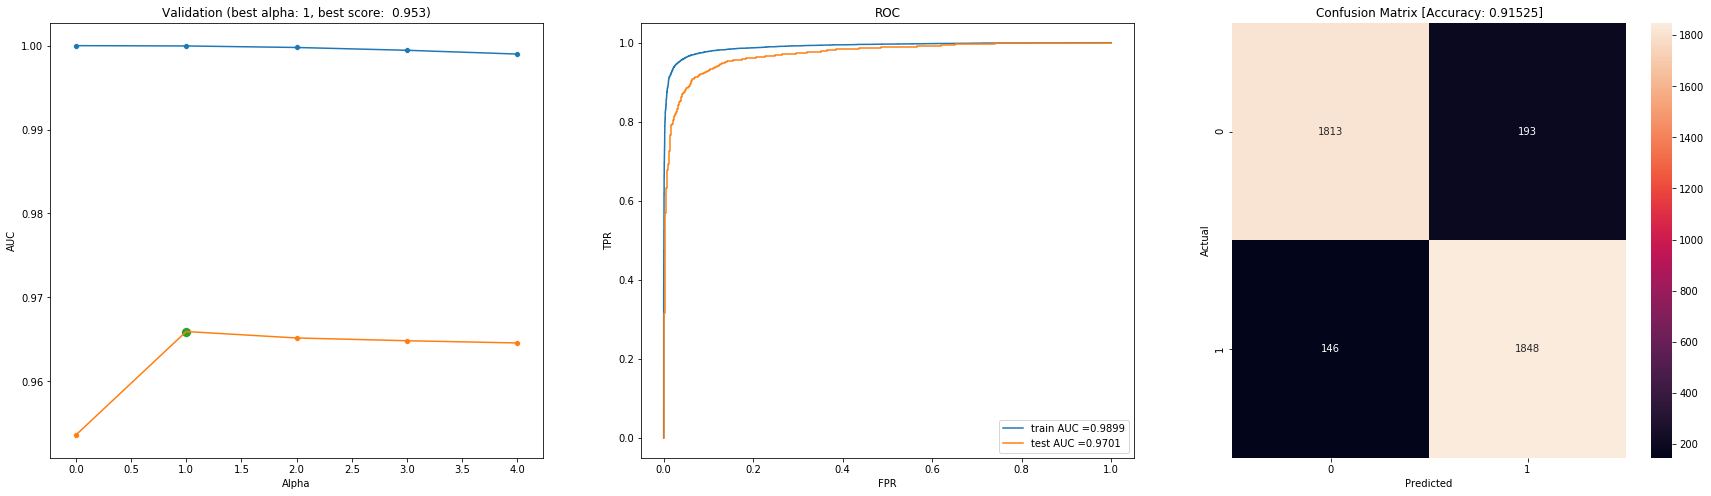

In [27]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__alpha')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"Validation (best alpha: {results.param_model_fit__alpha[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': True,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': 10000,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__alpha': 1}

#### TF-IDF

In [12]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',MultinomialNB())])

In [13]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5,10],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__alpha': list(range(-5,5))}   #[round(0.00001*10**i,6) for i in range(10)]

In [14]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  4.2min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  6.5min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 13.4min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 17.9min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 22.4min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 27.5min
[Parallel(n_jobs=6)]

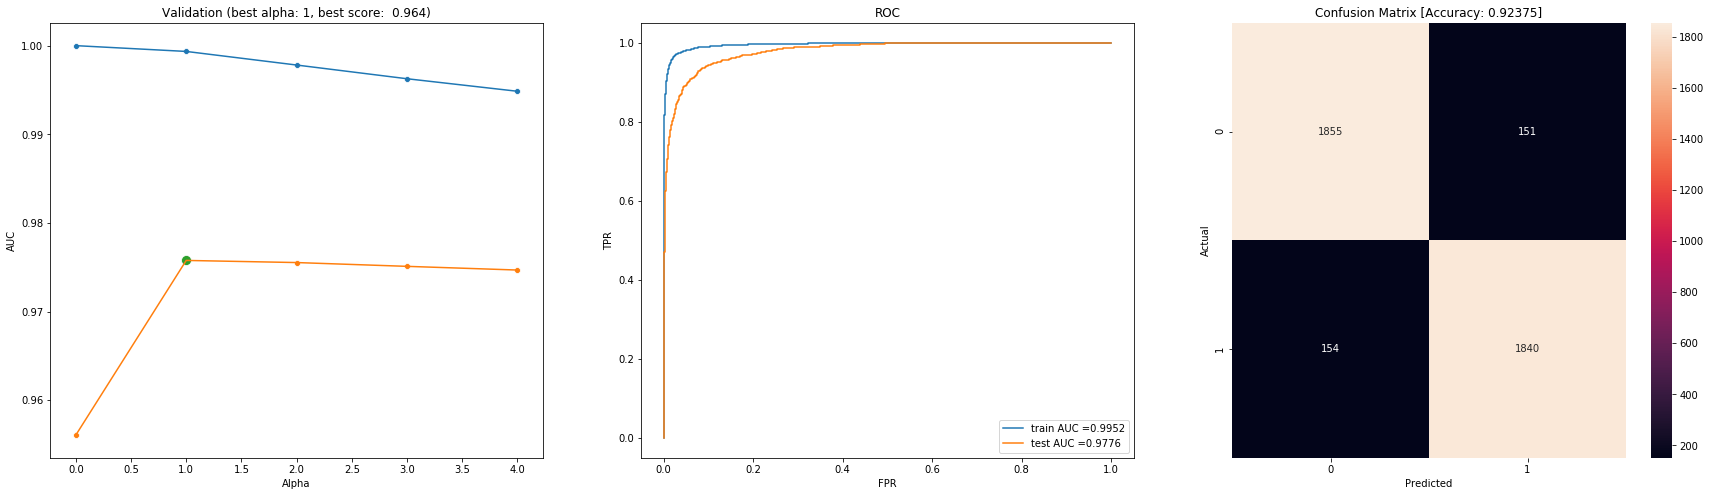

In [23]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__alpha')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"Validation (best alpha: {results.param_model_fit__alpha[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
model.best_params_

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]

## Logistic Regression

### Set - 1 BOW

#### Set - 1 BOW with L2-Reg

In [99]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',LogisticRegression(max_iter=1000))])

In [100]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5,10],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__C': [round(0.001*10**i,6) for i in range(5)]+[1.5,5,10]}   #[round(0.00001*10**i,6) for i in range(10)]

In [101]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 19.6min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 24.5min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 45.3min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 60.1min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 94.0min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 137.6min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 175.3min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 207.9min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 240.5min
[Parallel(n_jobs

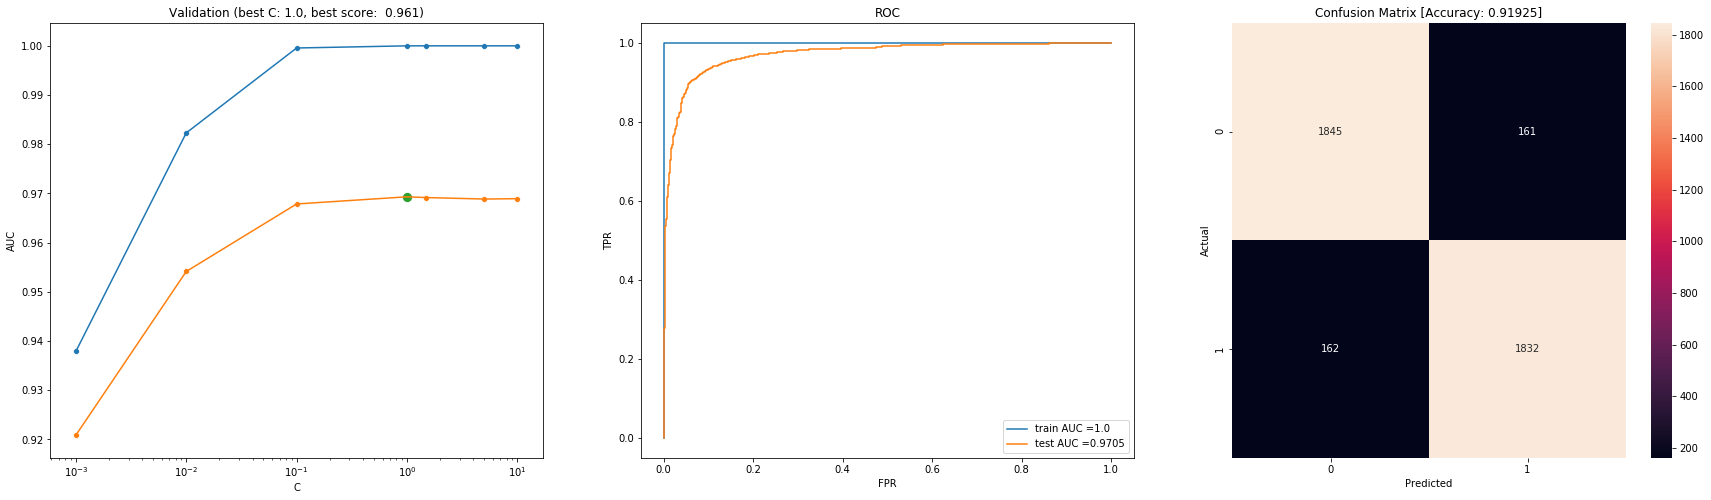

In [102]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [103]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': True,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 5,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__C': 1.0}

#### Set 1 L1- Reg

In [5]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',LogisticRegression(max_iter=1000,penalty = 'l1',solver='liblinear'))])

In [6]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5,10],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__C': [round(0.001*10**i,6) for i in range(5)]+[1.5,5,10]}   #[round(0.00001*10**i,6) for i in range(10)]

In [7]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  4.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 14.8min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 19.4min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 24.4min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 30.2min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 36.8min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 43.4min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 51.4min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 59.2min
[Parallel(n_jobs=10)]: Done 11230 tasks      

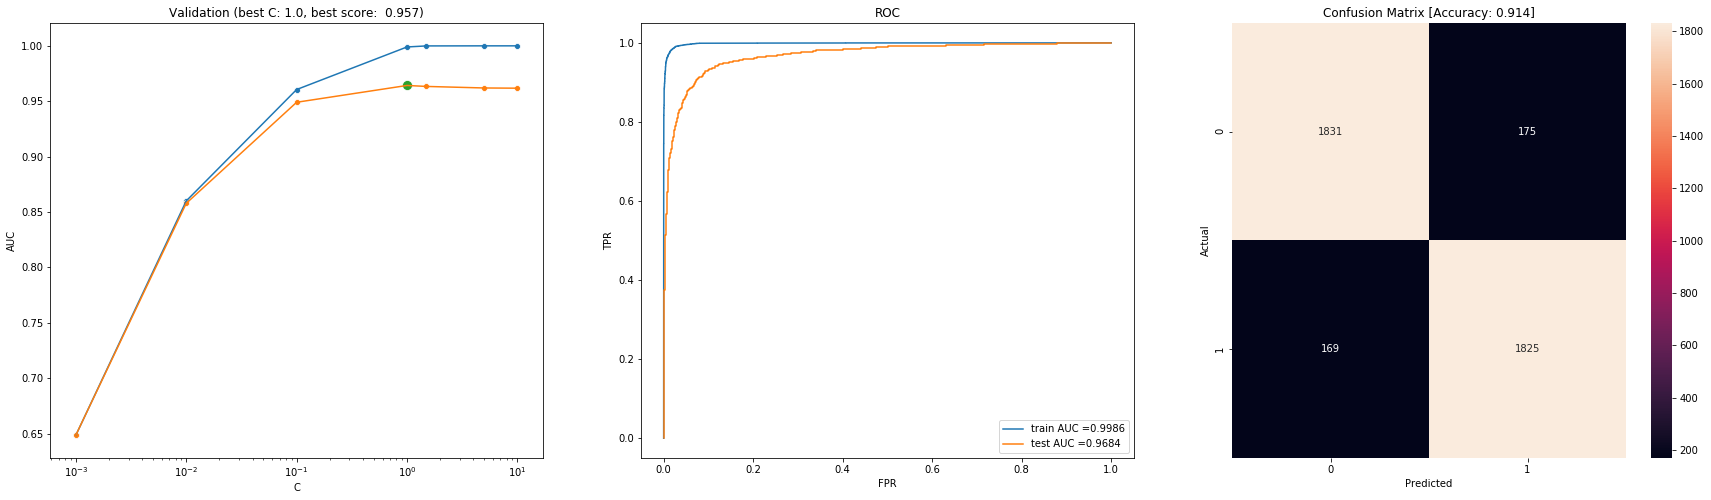

In [8]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': True,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__C': 1.0}

### Set- 2 TF-IDF

#### Set- 2 TF-IDF with L2 reg

In [24]:
X_train.

(16000, 13)

In [29]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',LogisticRegression(max_iter = 1000))])

In [30]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5,10],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__C': [round(0.001*10**i,6) for i in range(5)]+[1.5,5,10]}   #round(0.001*10**i,6) for i in range(5)]+[1.5,5,10]

In [32]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=5,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 14.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 30.4min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 51.0min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed: 72.6min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 95.0min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 132.0min
[Parallel(n_jobs=5)]: Done 2880 out of 2880 | elapsed: 154.3min finished


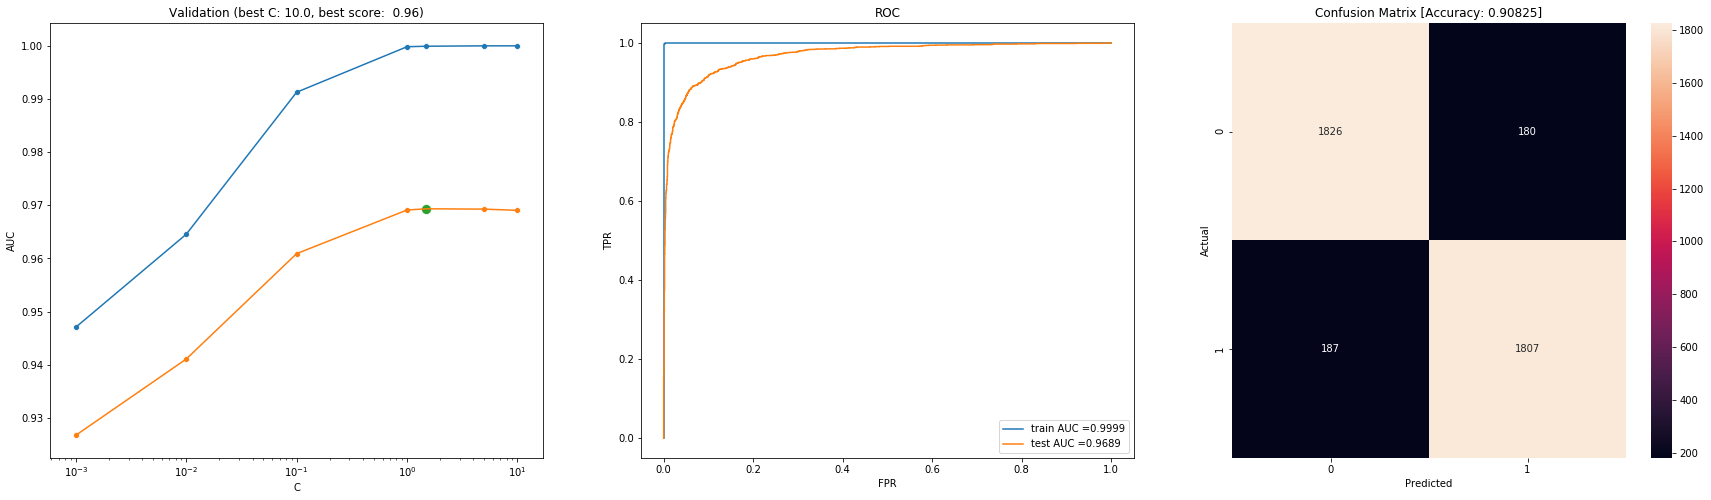

In [28]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': 5000,
 'features__Text_vectorizer__vectorize__min_df': 5,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__C': 5}

#### Set- 2 TF-IDF with L1 reg

In [ ]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',LogisticRegression(max_iter = 1000,penalty='l1', solver='liblinear'))])

In [ ]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5,10],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__C': [round(0.001*10**i,6) for i in range(5)]+[1.5,5,10]}   #[round(0.00001*10**i,6) for i in range(10)]

In [ ]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

In [ ]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
model.best_params_

### Set- 3 Avg - Word2Vec

#### Set- 3 Avg - Word2Vec with L2 reg

In [81]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',LogisticRegression(max_iter = 1000))])

In [90]:
param_grid = {'model_fit__C': [0.01,0.1,0.5,1,1.5,2,5,10,25,50,100]}   #[round(0.00001*10**i,6) for i in range(10)]

In [91]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done  55 out of  55 | elapsed:  2.3min finished


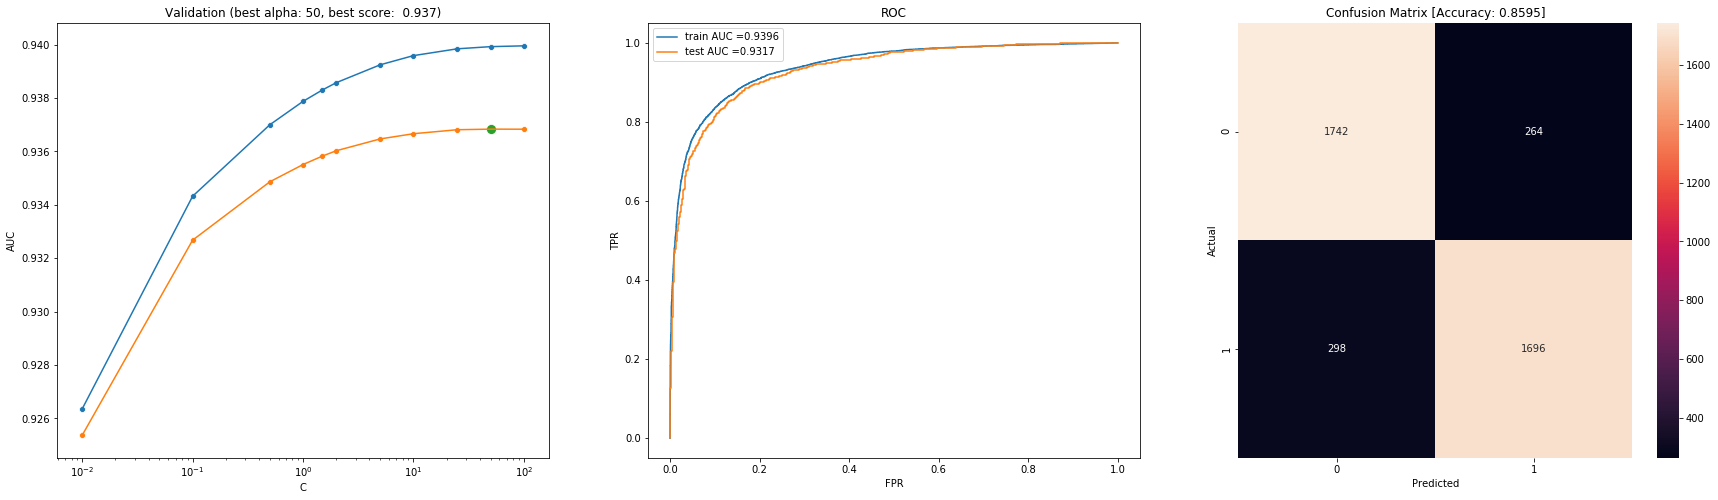

In [92]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)

plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best alpha: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [93]:
model.best_params_

{'model_fit__C': 50}

#### Set- 3 Avg - Word2Vec with L1 reg

In [13]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',LogisticRegression(max_iter = 1000,penalty='l1', solver='liblinear'))])

In [15]:
param_grid = {'model_fit__C': [0.01,0.1,0.5,1,1.5,2,5,10,25,50,100]}   #[round(0.00001*10**i,6) for i in range(10)]

In [16]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done  55 out of  55 | elapsed:  2.7min finished


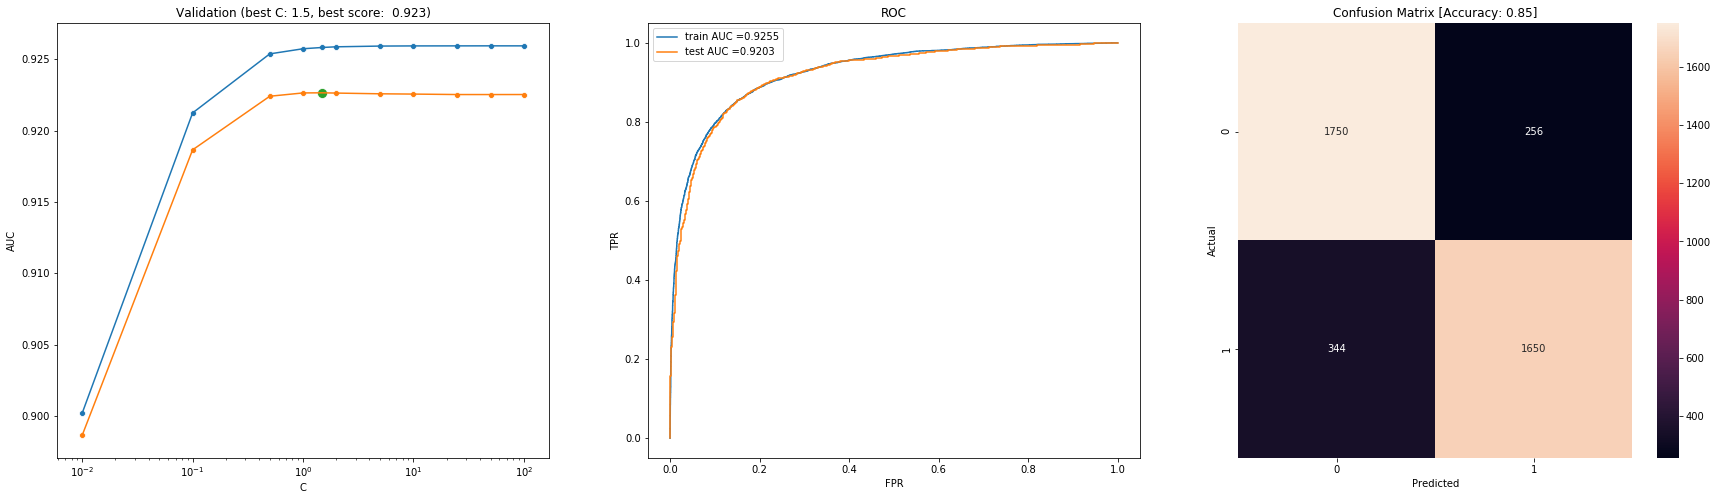

In [17]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)

plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
model.best_params_

{'model_fit__C': 1.5}

### Set4: TF-IDF Word2Vec

#### Set4: TF-IDF Word2Vec with L2 Reg

In [94]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            ('scale',StandardScaler())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            ('scale',StandardScaler())]))
        ]
    )),
    ('model_fit',LogisticRegression(max_iter=1000))])

In [95]:
param_grid = {'model_fit__C': [0.1,0.5,1,1.5,2,5,10,25,50,100]}   #[round(0.00001*10**i,6) for i in range(10)]

In [96]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 16.8min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 26.3min finished


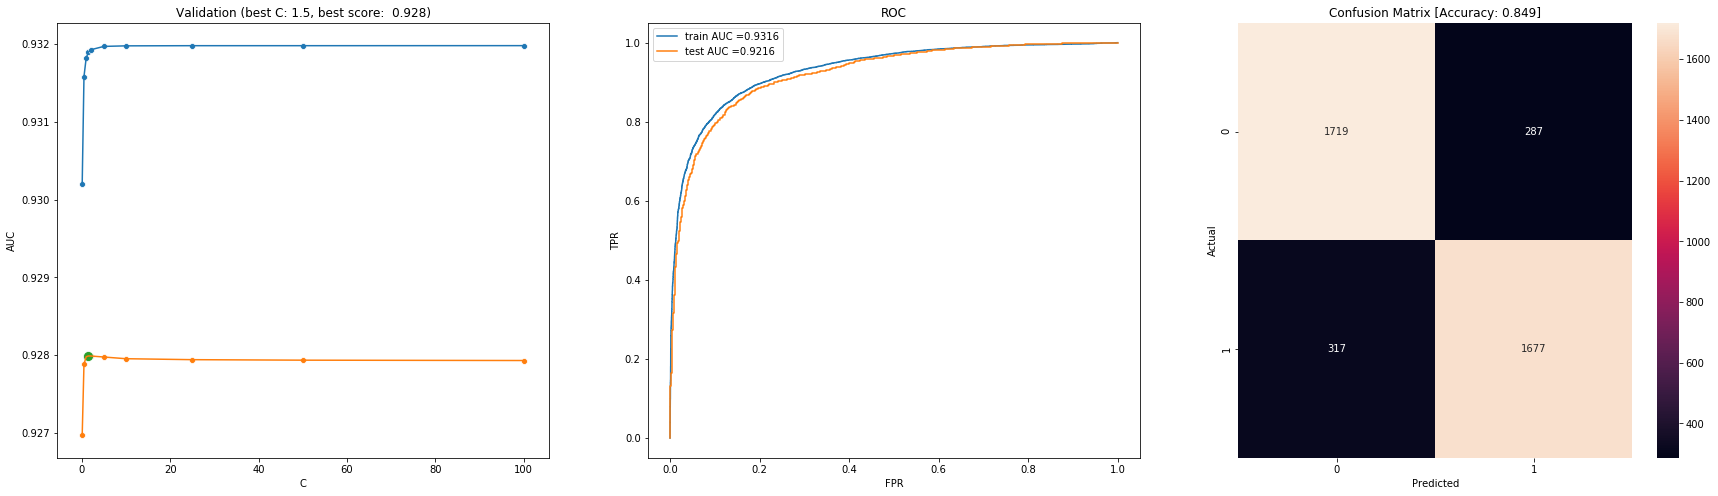

In [97]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [98]:
model.best_params_

{'model_fit__C': 1.5}

#### Set4: TF-IDF Word2Vec with L1 Reg

In [19]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            ('scale',StandardScaler())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            ('scale',StandardScaler())]))
        ]
    )),
    ('model_fit',LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear'))])

In [20]:
param_grid = {'model_fit__C': [0.1,0.5,1,1.5,2,5,10,25,50,100]}   #[round(0.00001*10**i,6) for i in range(10)]

In [21]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 16.0min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 26.1min finished


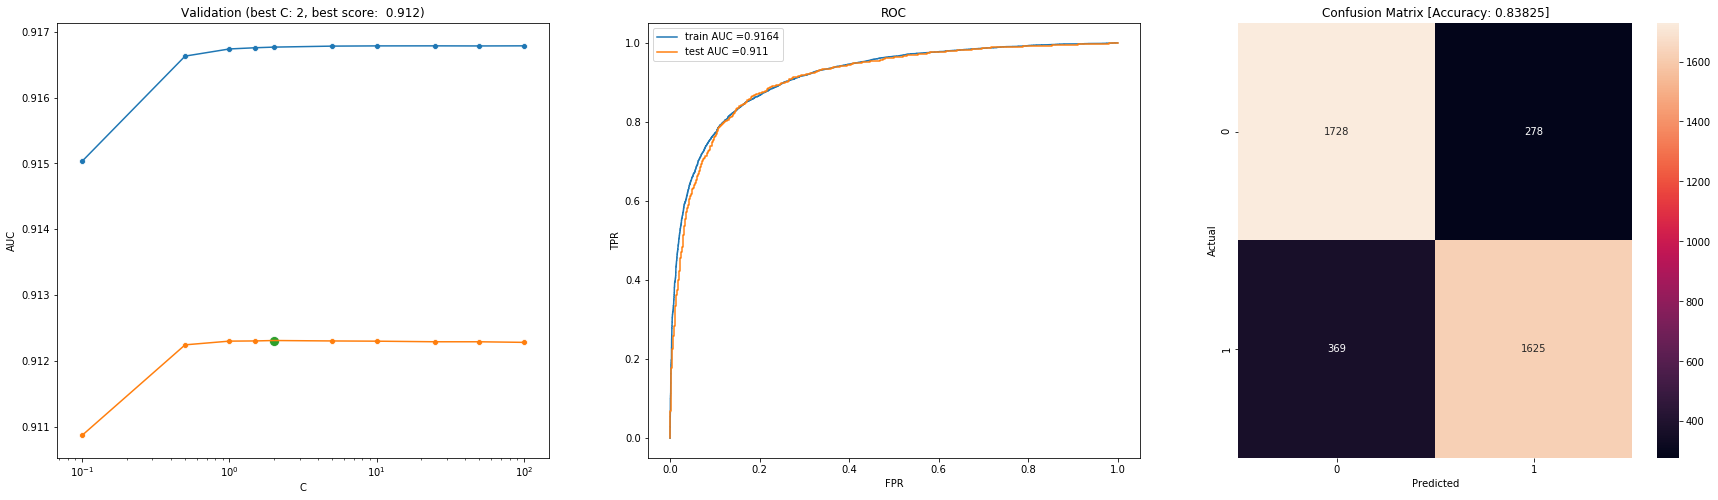

In [22]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,8))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"Validation (best C: {results.param_model_fit__C[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");





## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")

# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
model.best_params_

{'model_fit__C': 2}

## SVM

### Set1 BOW

#### Set1 BOW with Linear kernal

For Computing ROC-AUC we need probabilities which SVM/SGDClassifier don't output by default have to use CalibratedClassifierCV for improved probabilities output. Clibration is done to match correct prediction rate with confindence

* Logistic Regression has good agreement between its prediction rate and confindence (probability estimates) mostly because it otptimaztion focus directly on probabilty estimates (sigmoid output) being closer to class labels.
* In case of SVM It tries to fit data with objective of maximizing margin and it compromises on confindence in the easier cases.
https://www.youtube.com/watch?v=FkfDlOnQVvQ

In [71]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',SGDClassifier(loss='hinge'))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [72]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__alpha': [round(0.00001*10**i,6) for i in range(7)],
              'model_fit__penalty':['l2','l1']}   #[round(0.00001*10**i,6) for i in range(10)]

In [73]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 2688 candidates, totalling 13440 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  4.3min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 10.3min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 14.0min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 18.6min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 23.4min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 28.9min
[Paralle

##### Run Calibration with best paramters

In [74]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [75]:
params = model.best_params_

params['model_fit__base_estimator__alpha'] = params['model_fit__alpha'];del params['model_fit__alpha']
params['model_fit__base_estimator__penalty'] = params['model_fit__penalty'];del params['model_fit__penalty']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numerics',
                                                 Pipeline(memory=None,
                                                          steps=[('extract',
                                                                  ColumnExtractor(cols=['Cleaned_text'])),
                                                                 ('summerize',
                                                                  Text_Summerizer()),
                                                                 ('selected_extract',
                                                                  ColumnExtractor(cols=['count_letters',
                                                                                        'count_word',
                                                                                        'count_unique_word'])),
                    

In [76]:
params

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__alpha': 0.001,
 'model_fit__base_estimator__penalty': 'l2'}

In [77]:
clf_calibrated.fit(X_train,Y_train);

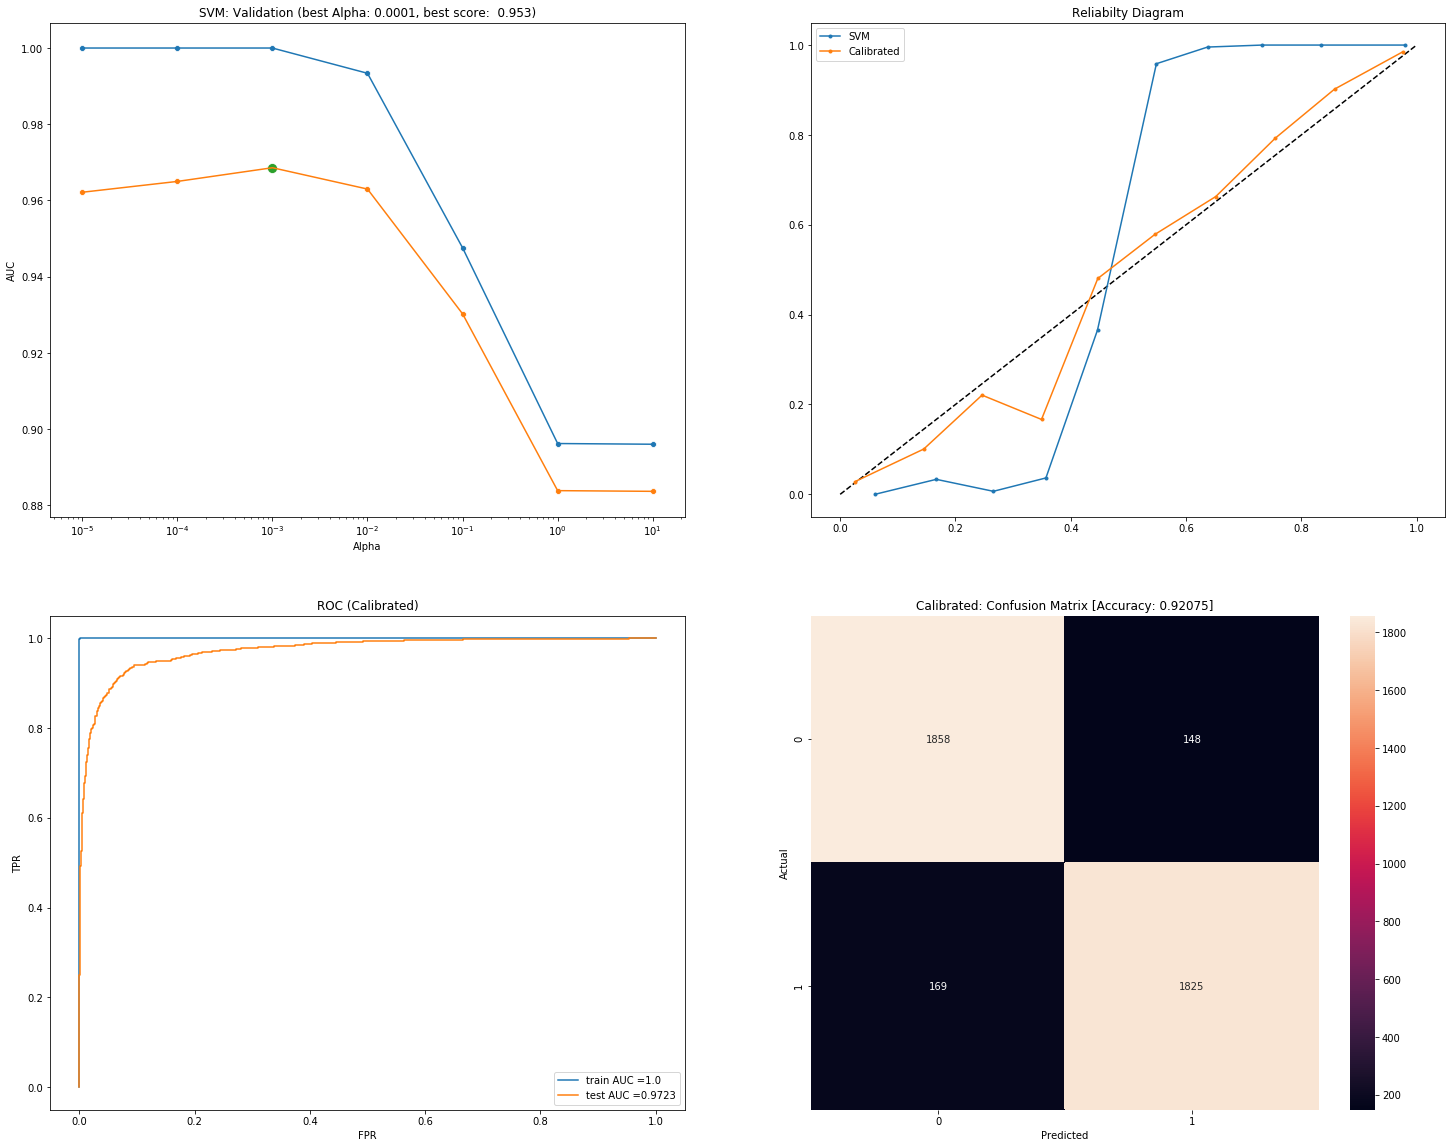

In [91]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__alpha')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best Alpha: {results.param_model_fit__alpha[max_ind]}, best score:  {round(results.mean_test_score[max_ind],3)})");


## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [92]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__alpha': 0.001,
 'model_fit__base_estimator__penalty': 'l2'}

#### Set1 BOW with RBF kernal

It is betterreduce dimesions when working with RBF kernal

min_df = 10, 
max_features = 500
size = 40k points

In [125]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer(min_df=10, max_features=500))])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer(min_df=10, max_features=500))]))
        ]
    )),
    ('model_fit',SVC(kernel='rbf'))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [126]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'model_fit__C': [round(0.01*10**i,6) for i in range(5)],
              'model_fit__gamma': [round(0.001*10**i,6) for i in range(6)]}   #[round(0.00001*10**i,6) for i in range(10)]

In [127]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  5.5min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 33.6min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 80.0min
[Parallel(n_jobs=10)]: Done 600 out of 600 | elapsed: 114.3min finished


In [128]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__C': 10.0,
 'model_fit__gamma': 0.01}

##### Run Calibration with best paramters

In [129]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer(min_df=10, max_features=500))])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer(min_df=10, max_features=500))]))
        ]
    )),
    ('model_fit',CalibratedClassifierCV(base_estimator=SVC(kernel='rbf'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [133]:
params = model.best_params_

params['model_fit__base_estimator__C'] = params['model_fit__C'];del params['model_fit__C']
params['model_fit__base_estimator__gamma'] = params['model_fit__gamma'];del params['model_fit__gamma']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [134]:
params

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__C': 10.0,
 'model_fit__base_estimator__gamma': 0.01}

In [135]:
clf_calibrated.fit(X_train,Y_train);

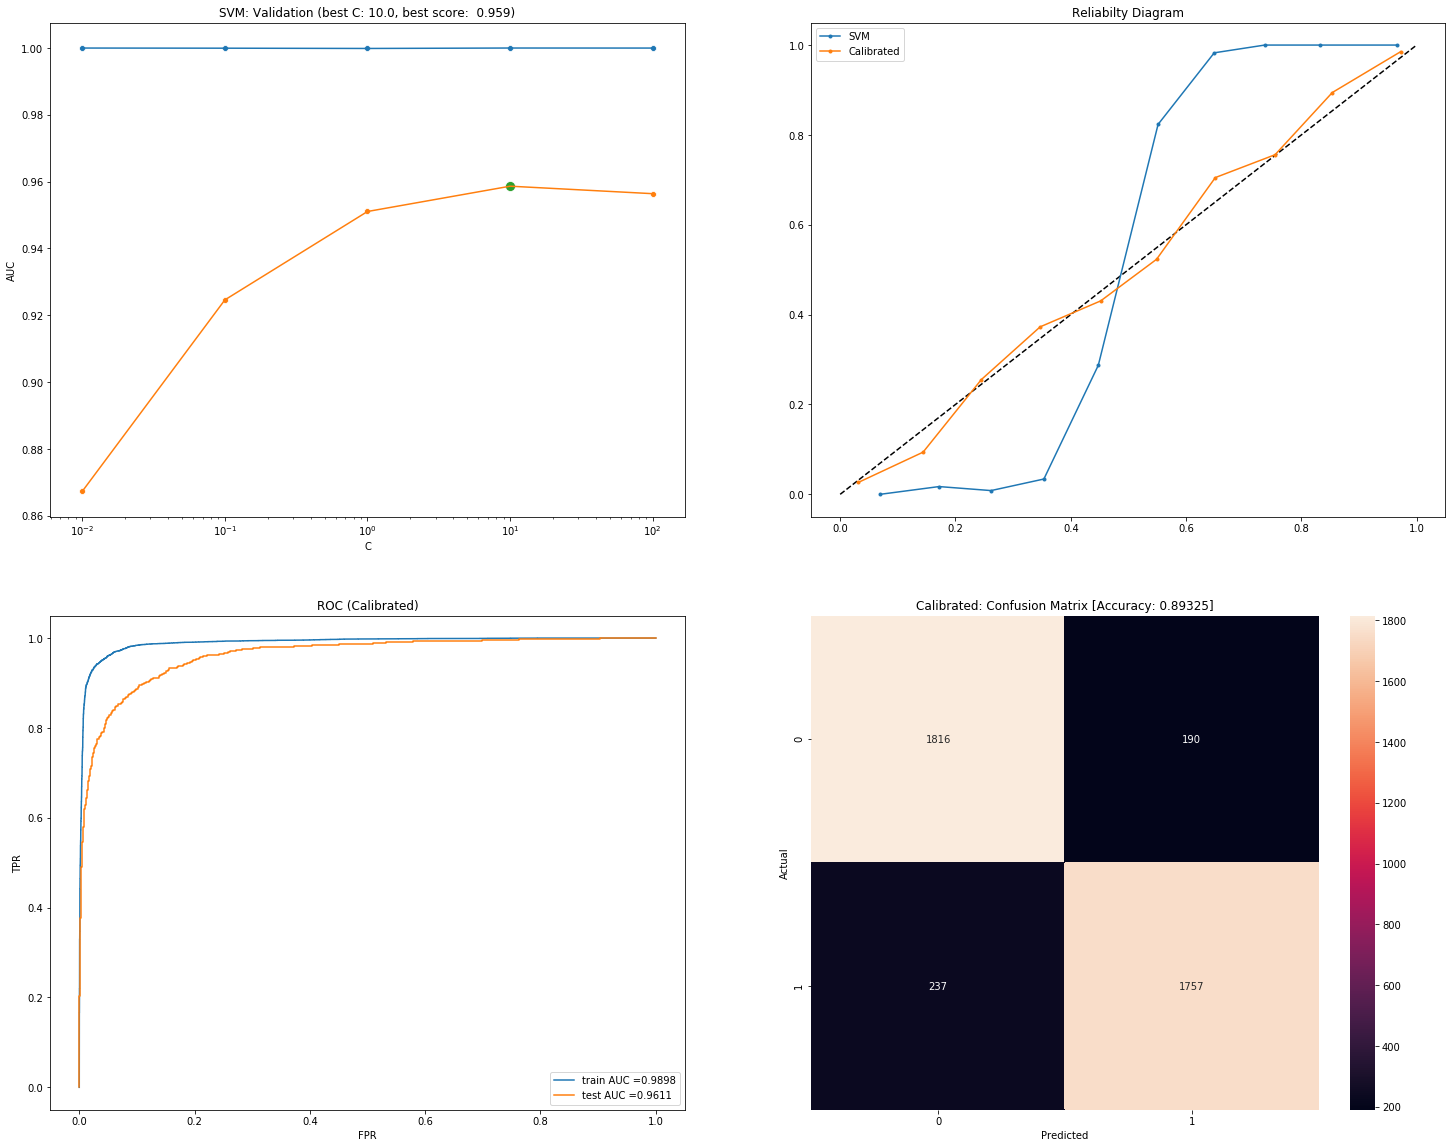

In [149]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best C: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [150]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__C': 10.0,
 'model_fit__base_estimator__gamma': 0.01}

### Set 2 TF-IDF

#### Set 2 TF-IDF with Linear kernal

In [ ]:
clf = Pipeline([
    ('features',FeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',SGDClassifier(loss='hinge'))])

In [155]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000],
              'model_fit__penalty':['l2','l1'],
              'model_fit__alpha': [round(0.00001*10**i,6) for i in range(7)]}   #[round(0.00001*10**i,6) for i in range(10)]

In [157]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   23.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  7.0min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 11.2min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 16.0min
[Parallel(n_jobs=10)]: Done 2240 out of 2240 | elapsed: 20.0min finished


##### Run Calibration with best paramters

In [158]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [159]:
params = model.best_params_

params['model_fit__base_estimator__alpha'] = params['model_fit__alpha'];del params['model_fit__alpha']
params['model_fit__base_estimator__penalty'] = params['model_fit__penalty'];del params['model_fit__penalty']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [160]:
clf_calibrated.fit(X_train,Y_train);

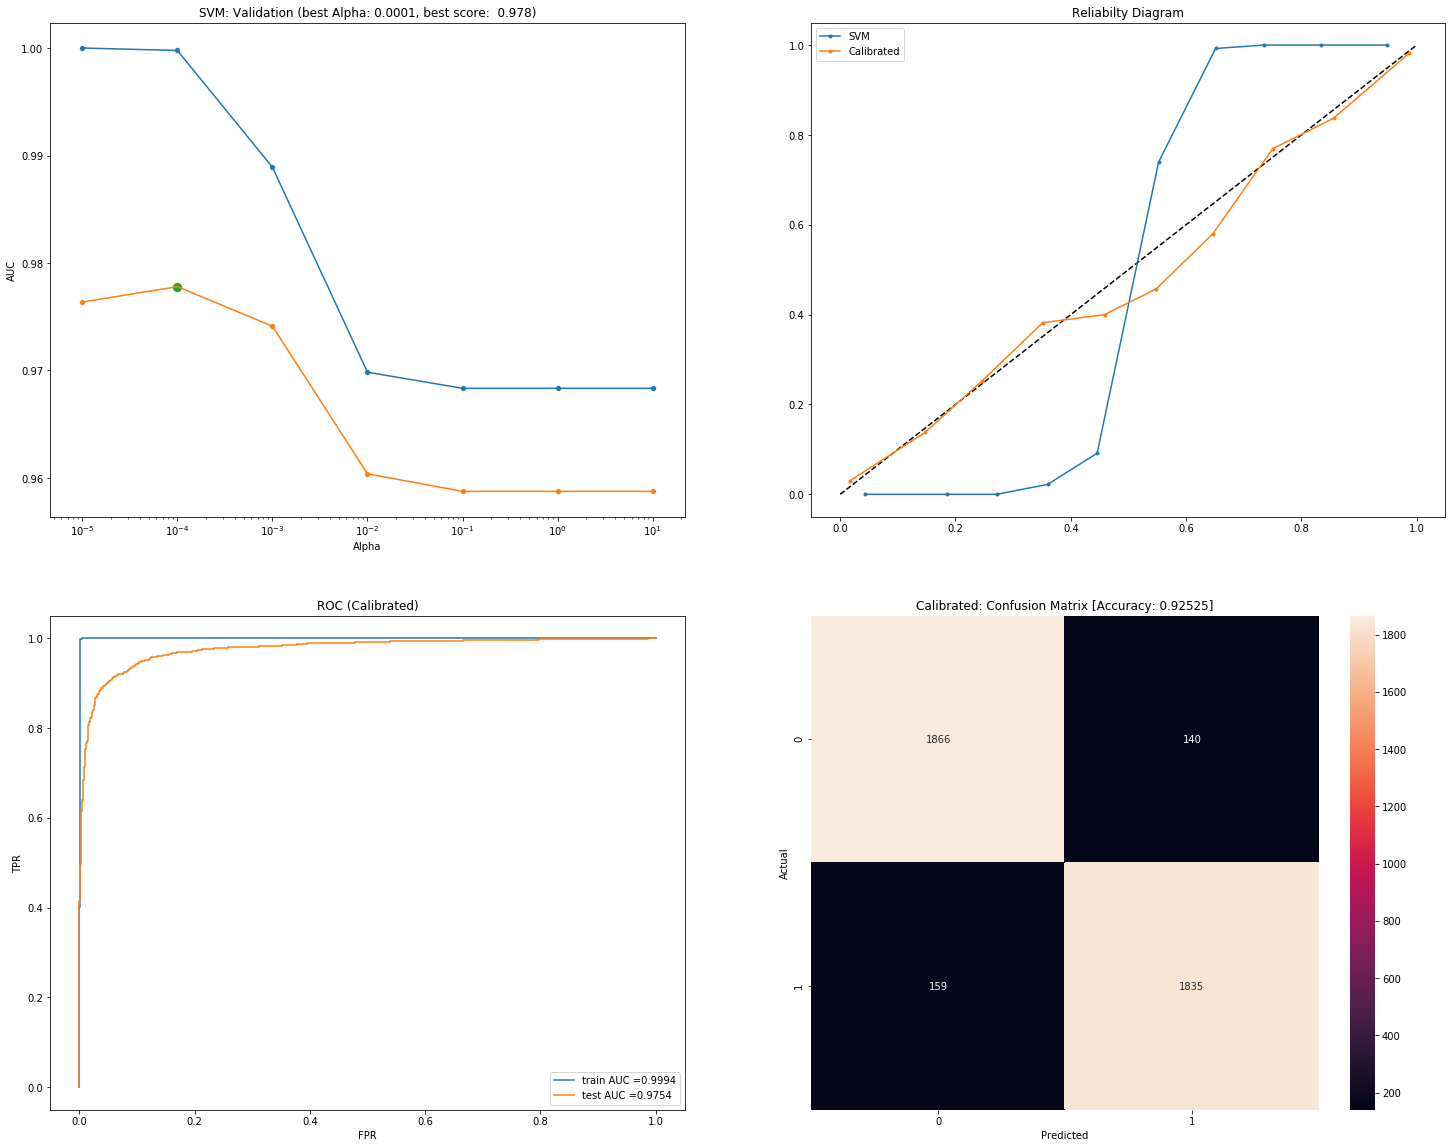

In [161]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__alpha')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best Alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");



## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [162]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__alpha': 0.0001,
 'model_fit__base_estimator__penalty': 'l2'}

#### Set2 TFIDF with RBF kernal

It is betterreduce dimesions when working with RBF kernal

min_df = 10, 
max_features = 500
size = 40k points

In [163]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer(min_df=10, max_features=500))])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer(min_df=10, max_features=500))]))
        ]
    )),
    ('model_fit',SVC(kernel='rbf'))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [164]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'model_fit__C': [round(0.01*10**i,6) for i in range(5)],
              'model_fit__gamma': [round(0.001*10**i,6) for i in range(6)]}   #[round(0.00001*10**i,6) for i in range(10)]

In [165]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  5.5min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 32.4min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 73.4min
[Parallel(n_jobs=10)]: Done 600 out of 600 | elapsed: 102.9min finished


In [128]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__C': 10.0,
 'model_fit__gamma': 0.01}

##### Run Calibration with best paramters

In [166]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer(min_df=10, max_features=500))])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer(min_df=10, max_features=500))]))
        ]
    )),
    ('model_fit',CalibratedClassifierCV(base_estimator=SVC(kernel='rbf'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [167]:
params = model.best_params_

params['model_fit__base_estimator__C'] = params['model_fit__C'];del params['model_fit__C']
params['model_fit__base_estimator__gamma'] = params['model_fit__gamma'];del params['model_fit__gamma']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [134]:
params

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__C': 10.0,
 'model_fit__base_estimator__gamma': 0.01}

In [168]:
clf_calibrated.fit(X_train,Y_train);

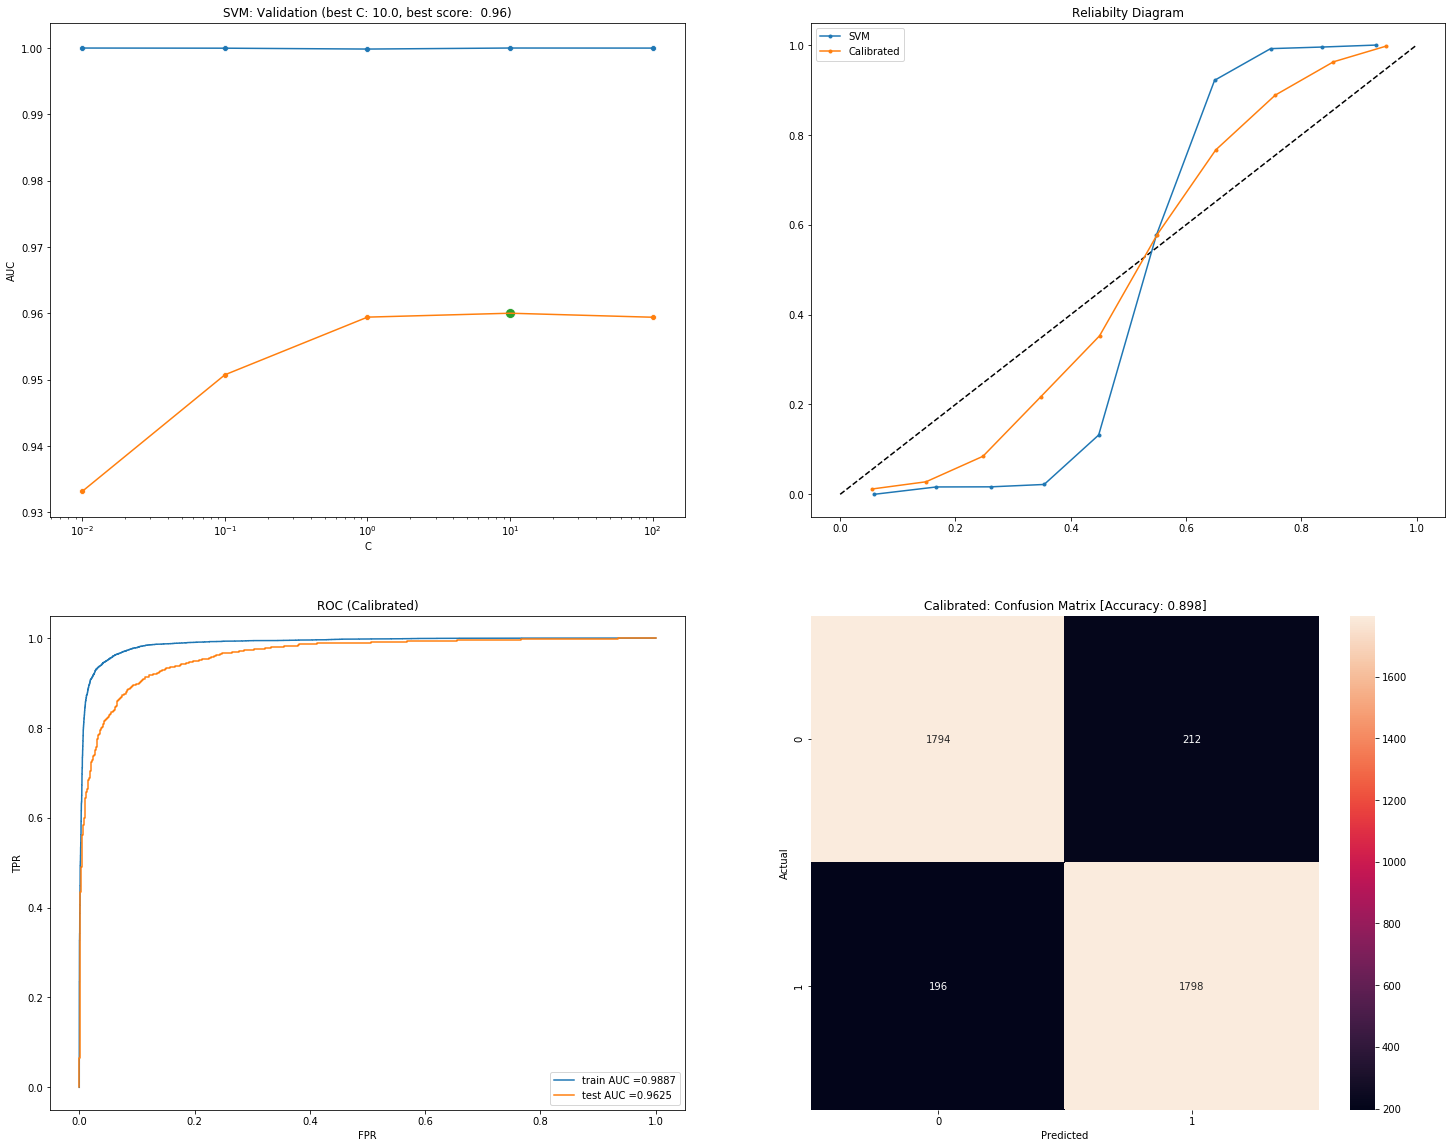

In [169]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best C: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");


## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [170]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__base_estimator__C': 10.0,
 'model_fit__base_estimator__gamma': 0.1}

### Set3 Avg-Word2Vec

In [5]:
X_train.columns

Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary',
       'Text', 'Cleaned_text', 'Cleaned_summary'],
      dtype='object')

In [11]:
i=0

list_of_sentance=[]
for sentance in tqdm(X_train.Text):
    list_of_sentance.append(sentance.split())

In [12]:
# this line of code trains your w2v model on the give list of sentances 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#### Set3 Avg-Word2Vec Linear kernal

In [8]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',SGDClassifier(loss='hinge'))])

In [9]:
param_grid = {'model_fit__penalty':['l2','l1'],
              'model_fit__alpha': [round(0.00001*10**i,6) for i in range(7)]} 

In [10]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  70 out of  70 | elapsed:  2.9min finished


#### Calibrate with best parameter

In [12]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model))])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model))
        ]))])),
    ('model_fit',CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [13]:
params = model.best_params_

params['model_fit__base_estimator__alpha'] = params['model_fit__alpha'];del params['model_fit__alpha']
params['model_fit__base_estimator__penalty'] = params['model_fit__penalty'];del params['model_fit__penalty']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [14]:
clf_calibrated.fit(X_train,Y_train);

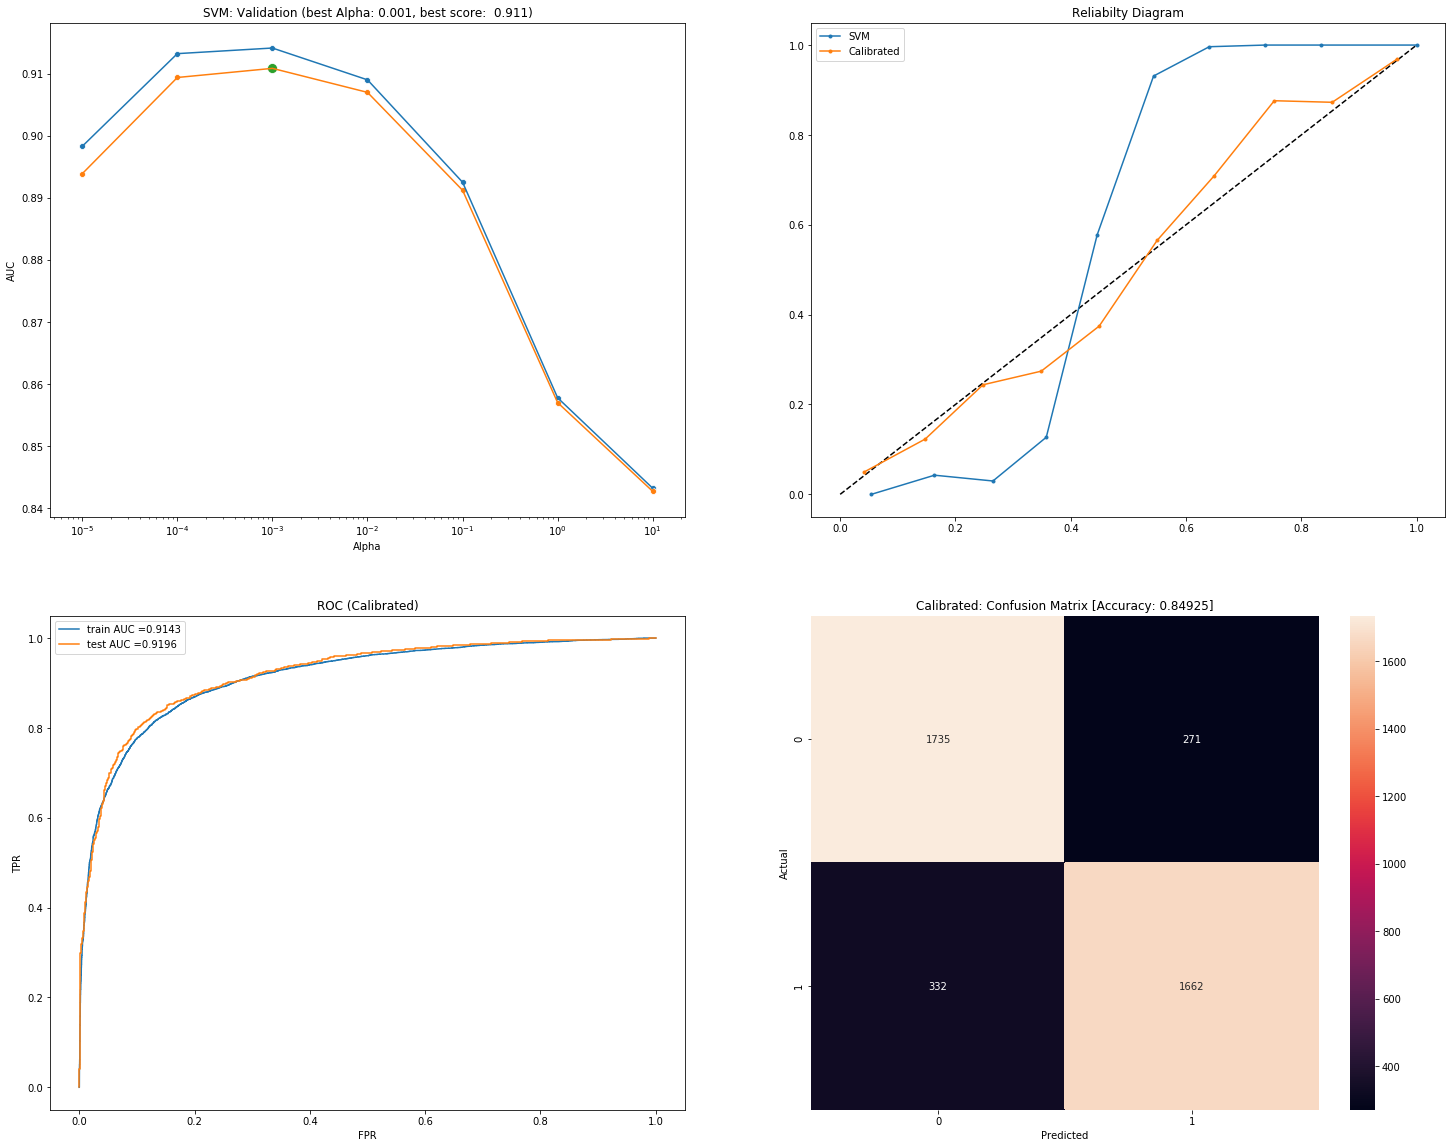

In [15]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__alpha')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best Alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");



## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
model.best_params_

{'model_fit__base_estimator__alpha': 0.001,
 'model_fit__base_estimator__penalty': 'l2'}

#### Set3 Avg-Word2Vec RBF kernal

In [20]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
        ]))]
    )),
    ('model_fit',SVC(kernel='rbf'))])

In [21]:
param_grid = {'model_fit__C': [round(0.01*10**i,6) for i in range(5)],
              'model_fit__gamma': [round(0.001*10**i,6) for i in range(6)]} 

In [22]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 13.0min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed: 68.3min finished


#### Calibrate with best parameter

In [24]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
        ]))]
    )),
    ('model_fit',CalibratedClassifierCV(base_estimator=SVC(kernel='rbf'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [25]:
params = model.best_params_

params['model_fit__base_estimator__C'] = params['model_fit__C'];del params['model_fit__C']
params['model_fit__base_estimator__gamma'] = params['model_fit__gamma'];del params['model_fit__gamma']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [26]:
clf_calibrated.fit(X_train,Y_train);

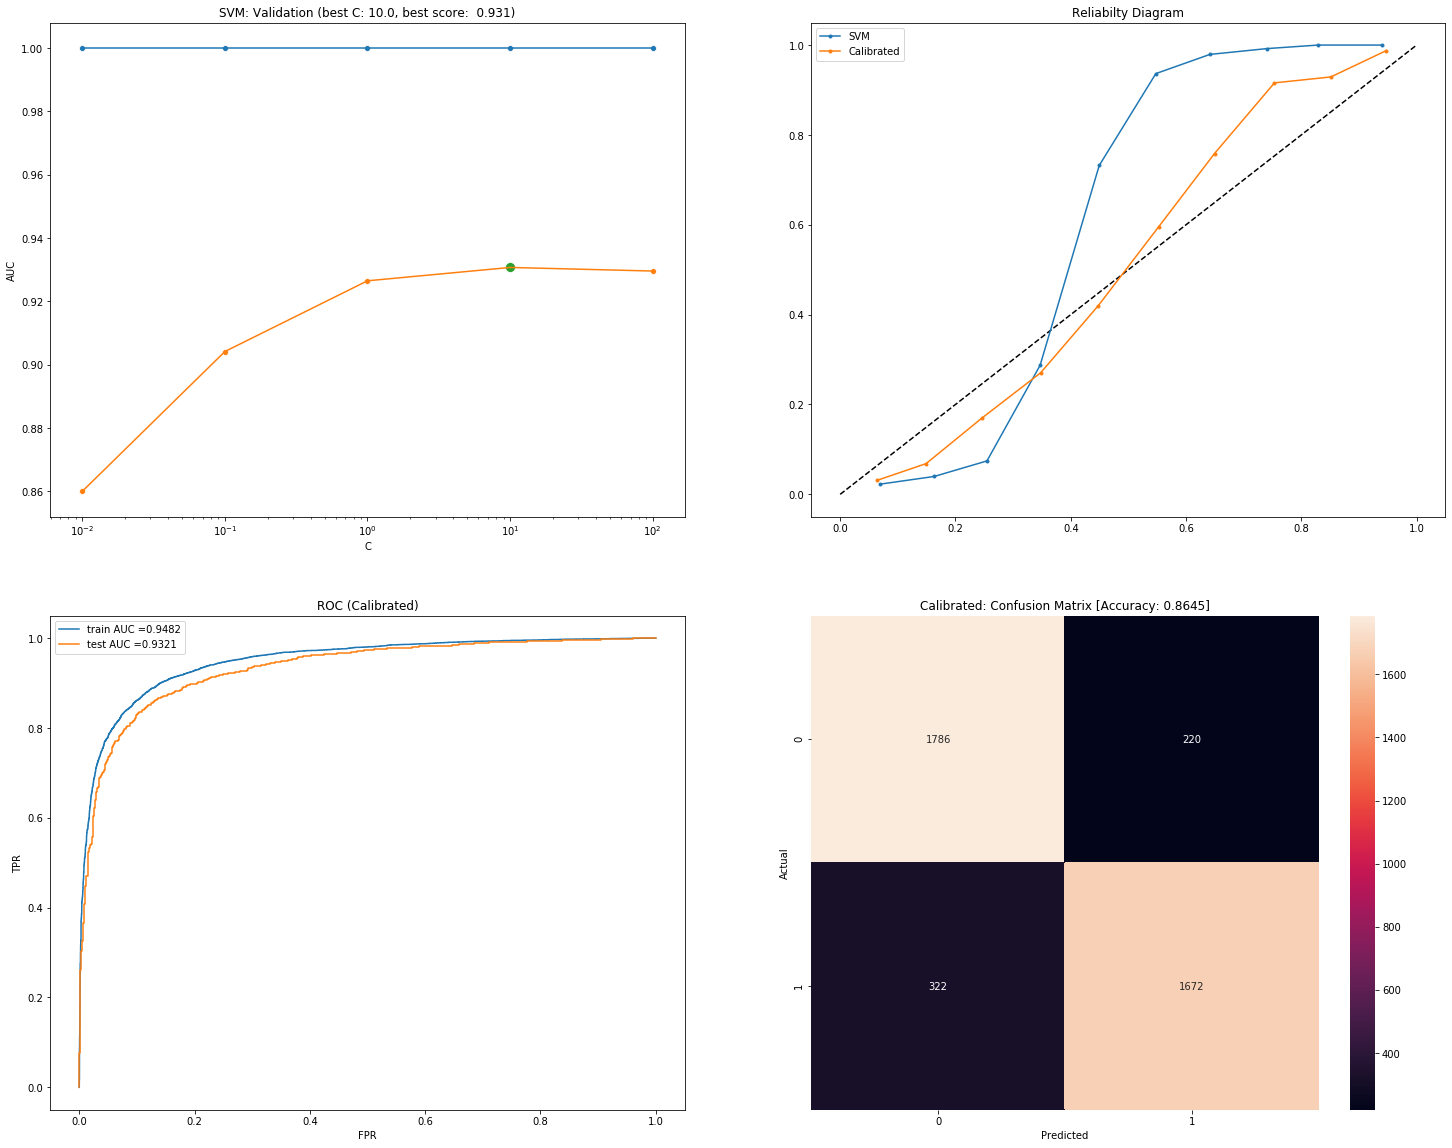

In [27]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best C: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");



## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
model.best_params_

{'model_fit__base_estimator__C': 10.0,
 'model_fit__base_estimator__gamma': 0.01}

### Set4 TFIDF - Word2Vec

#### Set3 TFIDF - Word2Vec Linear kernal

In [29]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',SGDClassifier(loss='hinge'))])

In [32]:
param_grid = {'model_fit__penalty':['l2','l1'],
              'model_fit__alpha': [round(0.00001*10**i,6) for i in range(8)]} 

In [33]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 15.2min
[Parallel(n_jobs=10)]: Done  80 out of  80 | elapsed: 39.6min finished


#### Calibrate with best parameter

In [34]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model))])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model))
        ]))])),
    ('model_fit',CalibratedClassifierCV(base_estimator=SGDClassifier(loss='hinge'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [35]:
params = model.best_params_

params['model_fit__base_estimator__alpha'] = params['model_fit__alpha'];del params['model_fit__alpha']
params['model_fit__base_estimator__penalty'] = params['model_fit__penalty'];del params['model_fit__penalty']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [36]:
clf_calibrated.fit(X_train,Y_train);

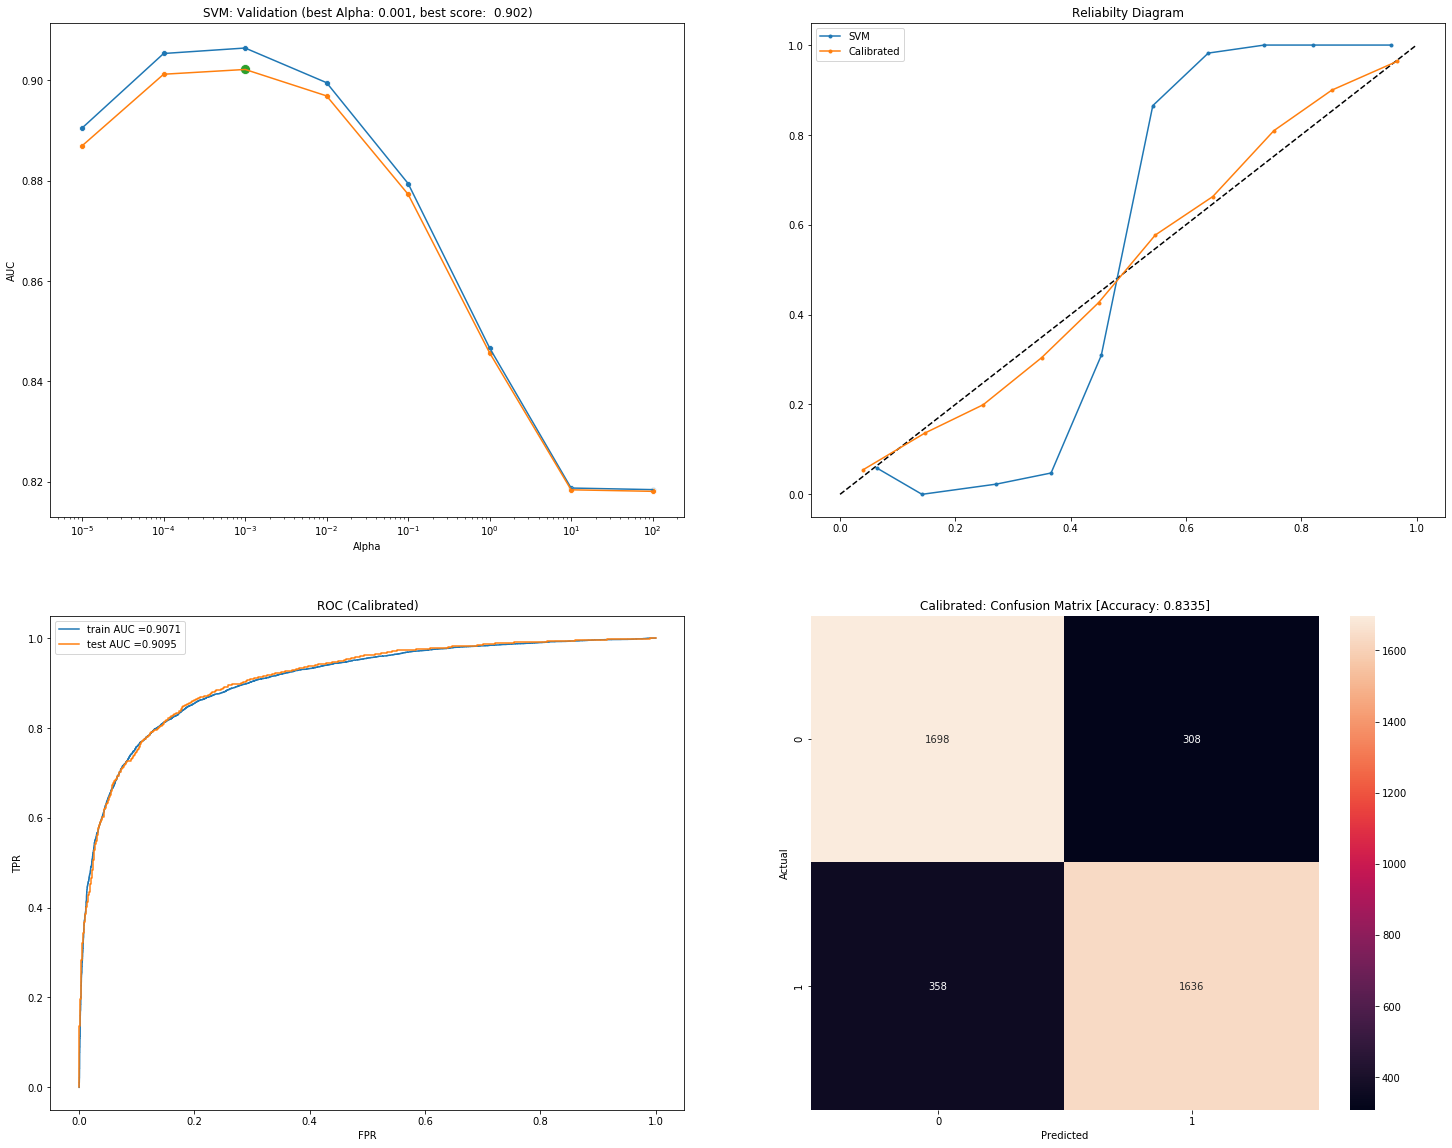

In [37]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__alpha')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__alpha')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best Alpha: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");



## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
model.best_params_

{'model_fit__base_estimator__alpha': 0.001,
 'model_fit__base_estimator__penalty': 'l2'}

#### Set4 TFIDF-Word2Vec RBF kernal

In [39]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
        ]))]
    )),
    ('model_fit',SVC(kernel='rbf'))])

In [40]:
param_grid = {'model_fit__C': [round(0.01*10**i,6) for i in range(5)],
              'model_fit__gamma': [round(0.001*10**i,6) for i in range(6)]} 

In [41]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 21.4min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed: 102.9min finished


#### Calibrate with best parameter

In [42]:
## Calibrated pipeline 
clf_calibrated = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
        ]))]
    )),
    ('model_fit',CalibratedClassifierCV(base_estimator=SVC(kernel='rbf'),cv=5))]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [43]:
params = model.best_params_

params['model_fit__base_estimator__C'] = params['model_fit__C'];del params['model_fit__C']
params['model_fit__base_estimator__gamma'] = params['model_fit__gamma'];del params['model_fit__gamma']

# set best parameters obtained during GridSearch
clf_calibrated.set_params(**params);

In [44]:
clf_calibrated.fit(X_train,Y_train);

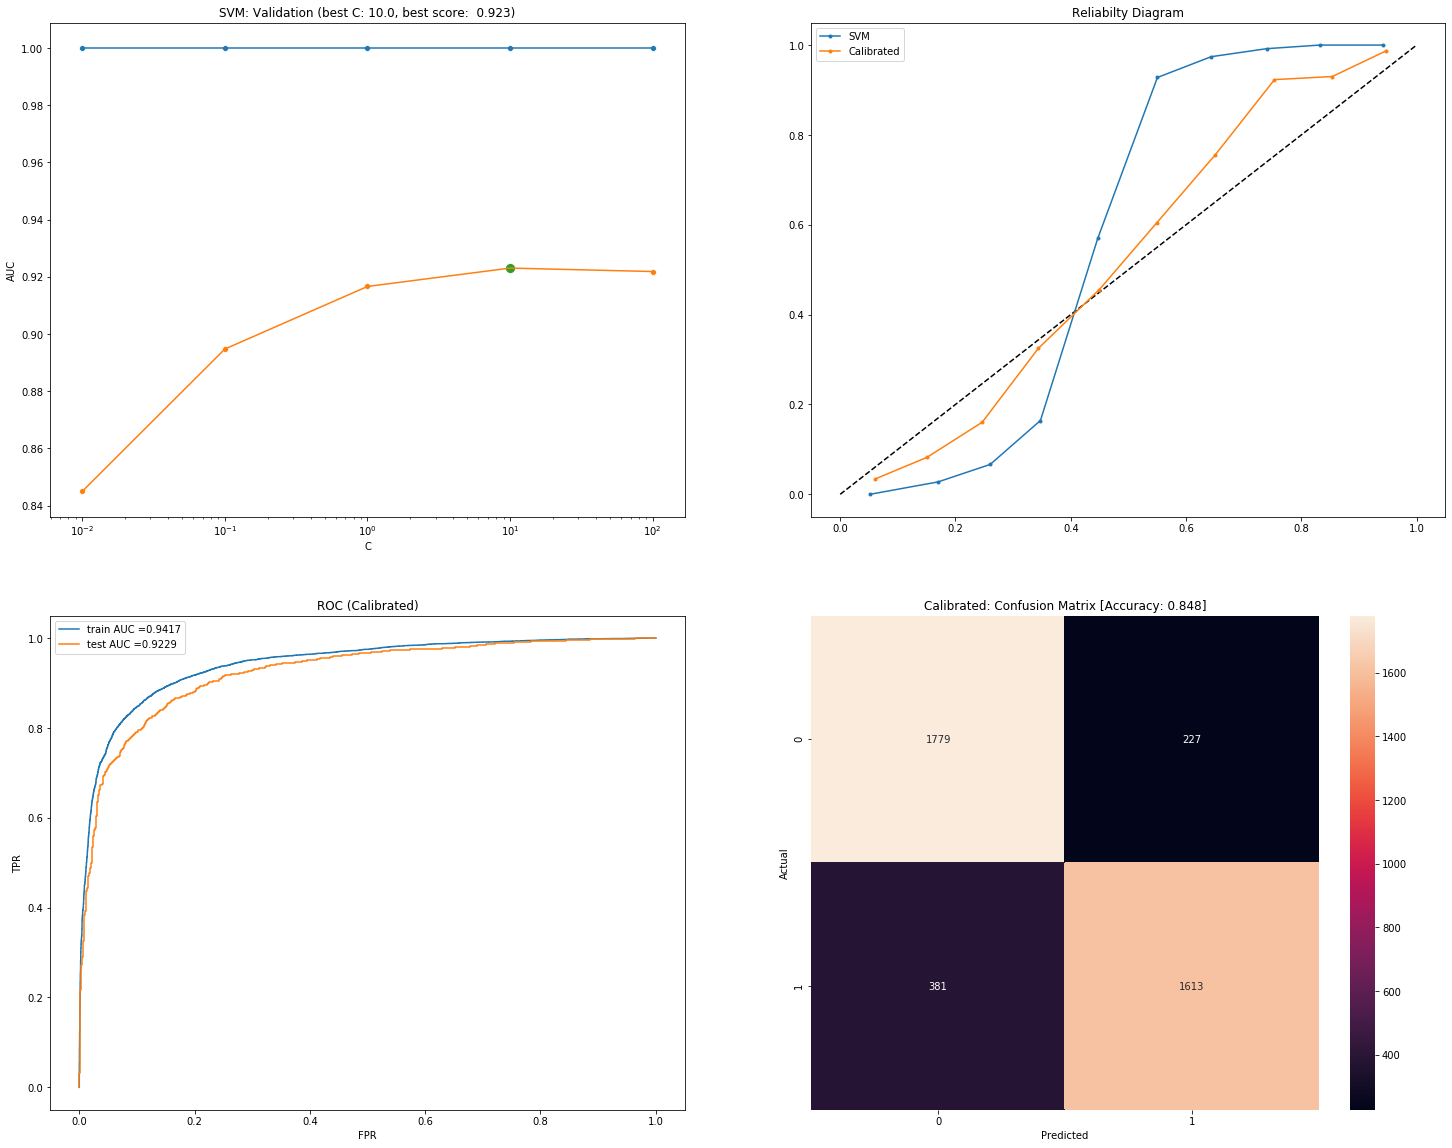

In [45]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(25,20))

mean_train_score = results.groupby('param_model_fit__C')['mean_train_score'].max()
mean_test_score = results.groupby('param_model_fit__C')['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(221)
plt.xscale('log')
sns.lineplot(mean_train_score.index,mean_train_score)
sns.lineplot(mean_test_score.index,mean_test_score)

sns.scatterplot(mean_train_score.index,mean_train_score)
sns.scatterplot(mean_test_score.index,mean_test_score)
max_ind = mean_test_score.argmax()
sns.scatterplot([mean_test_score.index[max_ind]],[mean_test_score.values[max_ind]],s=100)

plt.xlabel("C")
plt.ylabel("AUC")
plt.title(f"SVM: Validation (best C: {mean_test_score.index[max_ind]}, best score:  {round(mean_test_score.values[max_ind],3)})");



## Reliabilty Diagram
plt.subplot(222)

yhat_uncalibrated = model.decision_function(X_test) #uncalibrated predictions
yhat_calibrated = clf_calibrated.predict_proba(X_test)[:, 1] #calibrated predictions
# reliability diagrams
fop_uncalibrated, mpv_uncalibrated = calibration_curve(Y_test, yhat_uncalibrated, n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(Y_test, yhat_calibrated, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.', label="SVM")
plt.plot(mpv_calibrated, fop_calibrated, marker='.', label="Calibrated")
plt.legend()
plt.title('Reliabilty Diagram')

## ROC
plt.subplot(223)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_calibrated.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_calibrated.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(224)
conf_matrix = confusion_matrix(Y_test, clf_calibrated.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, clf_calibrated.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [46]:
model.best_params_

{'model_fit__base_estimator__C': 10.0,
 'model_fit__base_estimator__gamma': 0.01}

## Decision Tree

### Set BOW

In [49]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',DecisionTreeClassifier())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [50]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__min_samples_split': [2,10,20,30,40,50],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [51]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   38.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  8.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 11.9min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 15.8min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 20.2min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 26.7min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 32.1min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 38.5min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 48.1min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 55.4min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 66.1min
[Parallel(n_jobs=10)]: Done 11230 tasks      

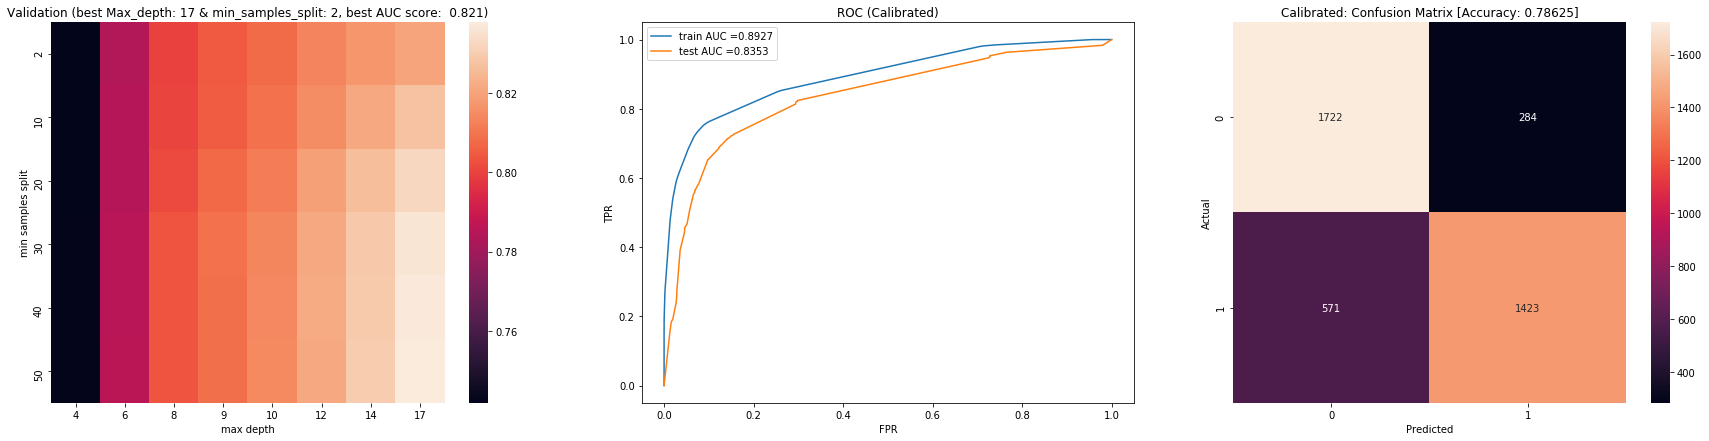

In [83]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__max_depth',index='param_model_fit__min_samples_split',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('max depth')
plt.ylabel('min samples split');mean_train_score.argmax()
plt.title(f"Validation (best Max_depth: {mean_test_score.index[max_ind][0]} & min_samples_split: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [84]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 1),
 'model_fit__max_depth': 17,
 'model_fit__min_samples_split': 50}

In [27]:
!shutdown -h 5

Shutdown scheduled for Thu 2020-05-28 20:39:58 IST, use 'shutdown -c' to cancel.


### Set TFIDF

In [85]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',DecisionTreeClassifier())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [86]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__min_samples_split': [2,10,20,30,40,50],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [88]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=6,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   57.2s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  5.3min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 15.8min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 21.0min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 27.1min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 35.8min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 43.3min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 52.4min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 65.0min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 74.9min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 89.1min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 101.0m

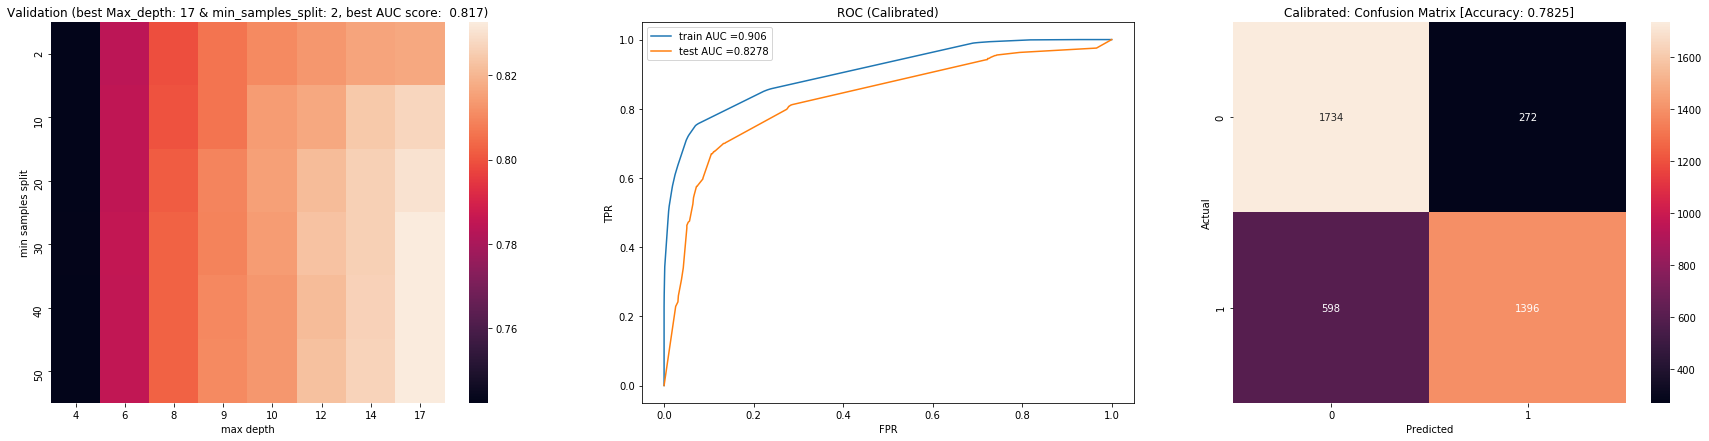

In [89]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__max_depth',index='param_model_fit__min_samples_split',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('max depth')
plt.ylabel('min samples split');mean_train_score.argmax()
plt.title(f"Validation (best Max_depth: {mean_test_score.index[max_ind][0]} & min_samples_split: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [90]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': 5000,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__max_depth': 17,
 'model_fit__min_samples_split': 40}

### Set3 Avg-Word2Vec

In [5]:
i=0

list_of_sentance=[]
for sentance in tqdm(X_train.Text):
    list_of_sentance.append(sentance.split())

In [6]:
# this line of code trains your w2v model on the give list of sentances 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#### Set3 Avg-Word2Vec Linear kernal

In [7]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
                                  ])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',DecisionTreeClassifier())])

In [8]:
param_grid = {'model_fit__min_samples_split': [2,10,20,30,40,50],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [9]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  7.5min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed:  9.8min finished


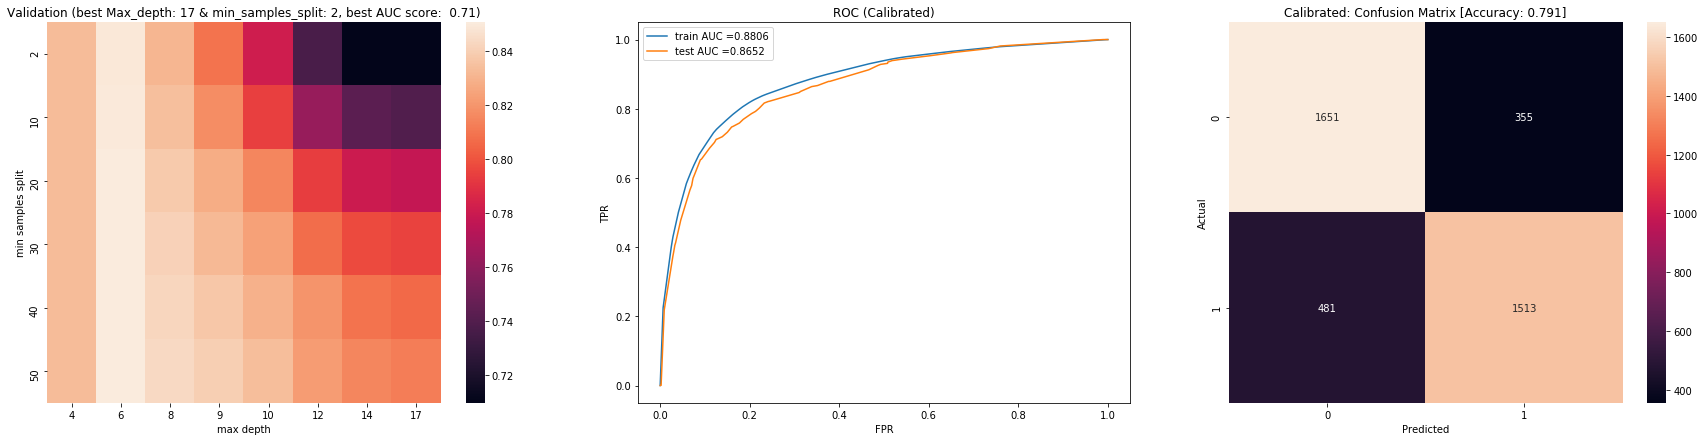

In [10]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__max_depth',index='param_model_fit__min_samples_split',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('max depth')
plt.ylabel('min samples split');mean_train_score.argmax()
plt.title(f"Validation (best Max_depth: {mean_test_score.index[max_ind][0]} & min_samples_split: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [11]:
model.best_params_

{'model_fit__max_depth': 6, 'model_fit__min_samples_split': 50}

#### Set3 TFIDF Word2Vec

In [12]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
                                  ])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',DecisionTreeClassifier())])

In [13]:
param_grid = {'model_fit__min_samples_split': [2,10,20,30,40,50],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [14]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 15.5min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 89.9min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 118.4min finished


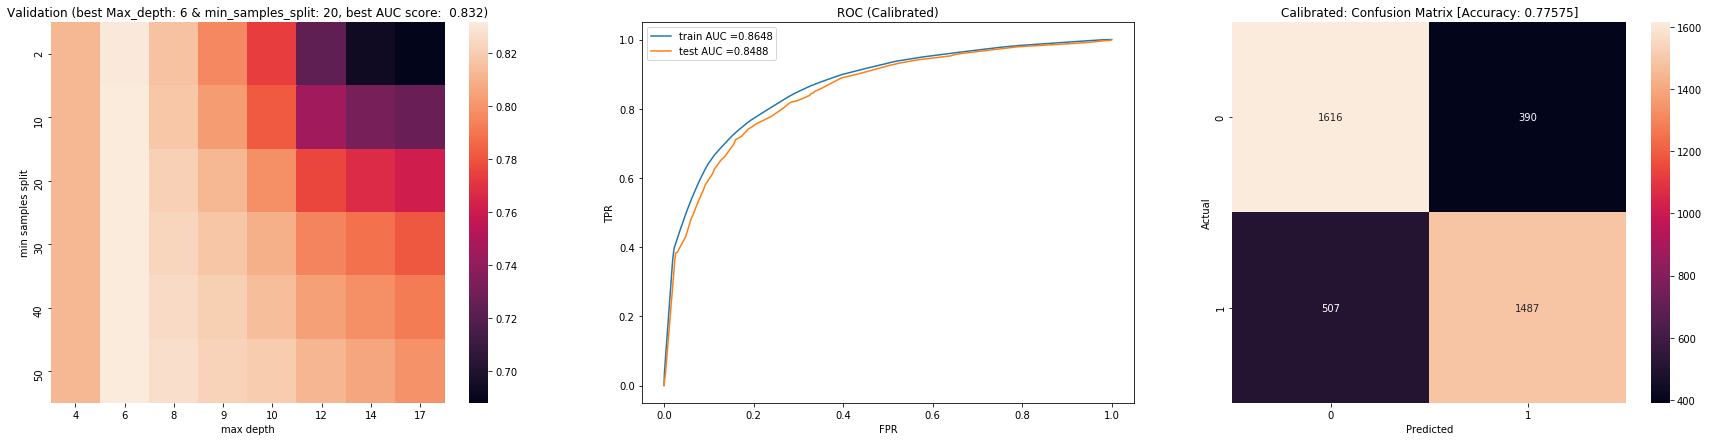

In [19]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__max_depth','param_model_fit__min_samples_split'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_test_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__max_depth',index='param_model_fit__min_samples_split',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('max depth')
plt.ylabel('min samples split');mean_train_score.argmax()
plt.title(f"Validation (best Max_depth: {mean_test_score.index[max_ind][0]} & min_samples_split: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
model.best_params_,model.best_score_

({'model_fit__max_depth': 6, 'model_fit__min_samples_split': 20},
 0.8317929813623557)

## Random Forest

### Set BOW

In [5]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',RandomForestClassifier())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [12]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__n_estimators': [300,500],
              'model_fit__max_depth':[None]}   #[round(0.00001*10**i,6) for i in range(10)]

In [13]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 11.0min
/home/skumar/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 40.1min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 96.7min
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed: 102.7min finished


In [20]:
results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score']

TypeError: 'SeriesGroupBy' object is not callable

ValueError: attempt to get argmax of an empty sequence

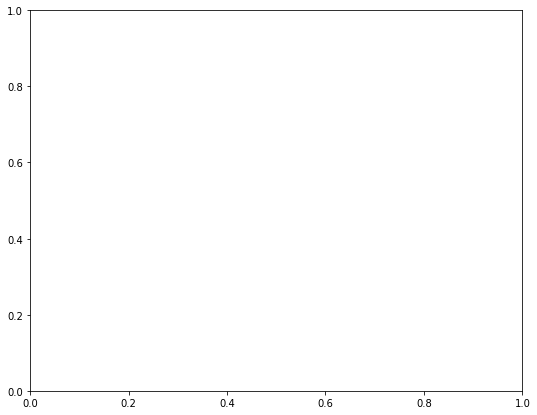

In [14]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': True,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 5,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': False,
 'features__Text_vectorizer__vectorize__max_features': None,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__max_depth': None,
 'model_fit__n_estimators': 500}

### Set TFIDF

In [5]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',RandomForestClassifier())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [6]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 1),(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__n_estimators': [20,40,60,80,100,120],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [7]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 9216 candidates, totalling 46080 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   43.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 11.8min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed: 16.1min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 20.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 26.5min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 32.5min
[Parallel(n_jobs=10)]: Done 6030 tasks      | elapsed: 39.2min
[Parallel(n_jobs=10)]: Done 7180 tasks      | elapsed: 47.9min
[Parallel(n_jobs=10)]: Done 8430 tasks      | elapsed: 55.5min
[Parallel(n_jobs=10)]: Done 9780 tasks      | elapsed: 65.1min
[Parallel(n_jobs=10)]: Done 11230 tasks      

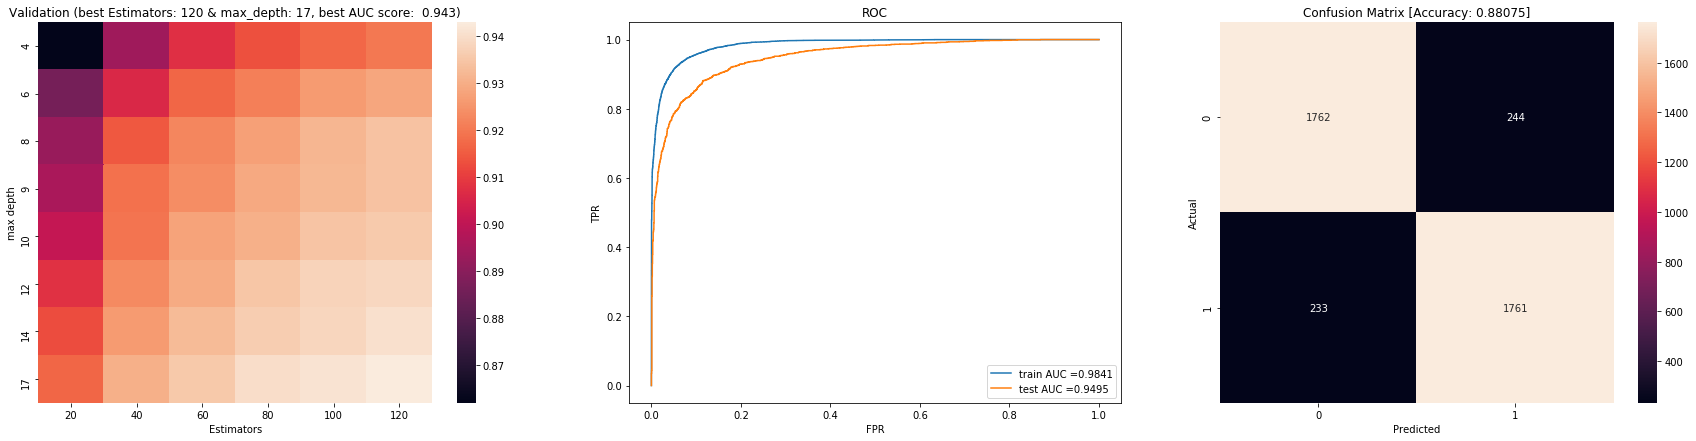

In [8]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': False,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 1,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': False,
 'features__Text_vectorizer__vectorize__max_features': 10000,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__max_depth': 17,
 'model_fit__n_estimators': 120}

### Word2Vec

In [10]:
i=0

list_of_sentance=[]
for sentance in tqdm(X_train.Text):
    list_of_sentance.append(sentance.split())

In [11]:
# this line of code trains your w2v model on the give list of sentances 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#### Set3 Avg-Word2Vec

In [12]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
                                  ])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',RandomForestClassifier())])

In [13]:
param_grid = {'model_fit__n_estimators': [20,40,60,80,100,120],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [14]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  8.0min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 10.6min finished


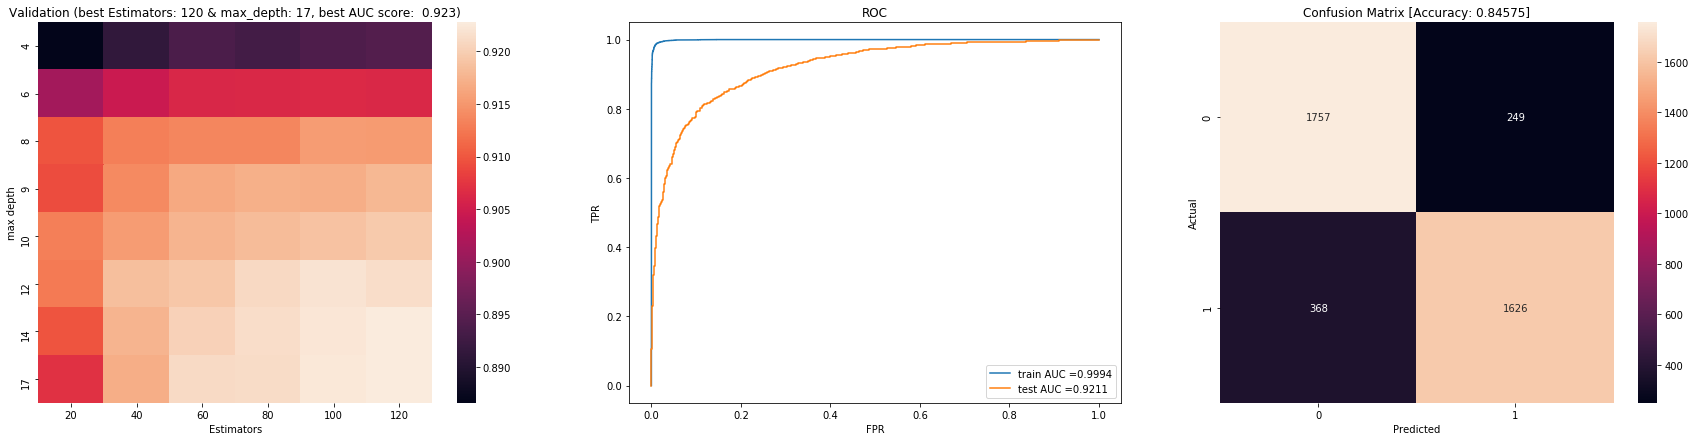

In [15]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
model.best_params_

{'model_fit__max_depth': 14, 'model_fit__n_estimators': 120}

#### Set4 TFIDF Word2Vec

In [17]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
                                  ])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',RandomForestClassifier())])

In [18]:
param_grid = {'model_fit__n_estimators': [20,40,60,80,100,120],
              'model_fit__max_depth':[4,6, 8, 9,10,12,14,17]}   #[round(0.00001*10**i,6) for i in range(10)]

In [19]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 16.1min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 89.2min
[Parallel(n_jobs=10)]: Done 240 out of 240 | elapsed: 116.1min finished


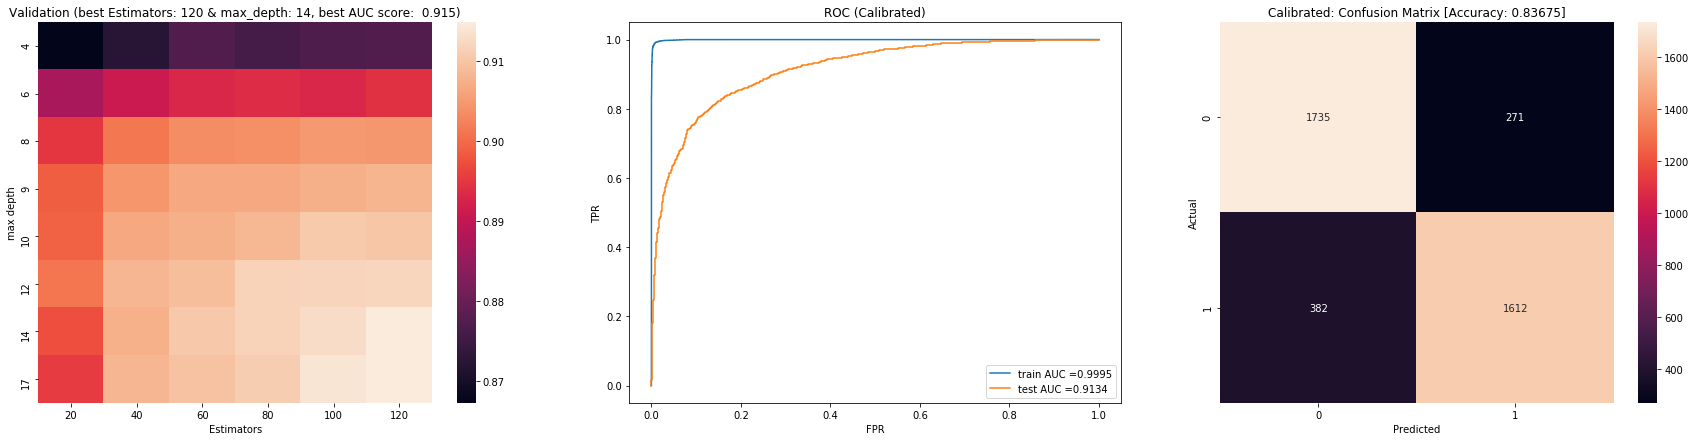

In [20]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_test_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
model.best_params_,model.best_score_

({'model_fit__max_depth': 14, 'model_fit__n_estimators': 120},
 0.914864907379296)

## GBDT

### Set BOW

In [26]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer())]))
        ]
    )),
    ('model_fit',GradientBoostingClassifier())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [29]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1,5],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__n_estimators': [50,100,150,250,500],
             'model_fit__max_depth':[3,5]}   #[round(0.00001*10**i,6) for i in range(10)]

In [30]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 30.2min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 75.0min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 158.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 233.2min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 338.7min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 480.5min
[Parallel(n_jobs=10)]: Done 2400 out of 2400 | elapsed: 615.0min finished


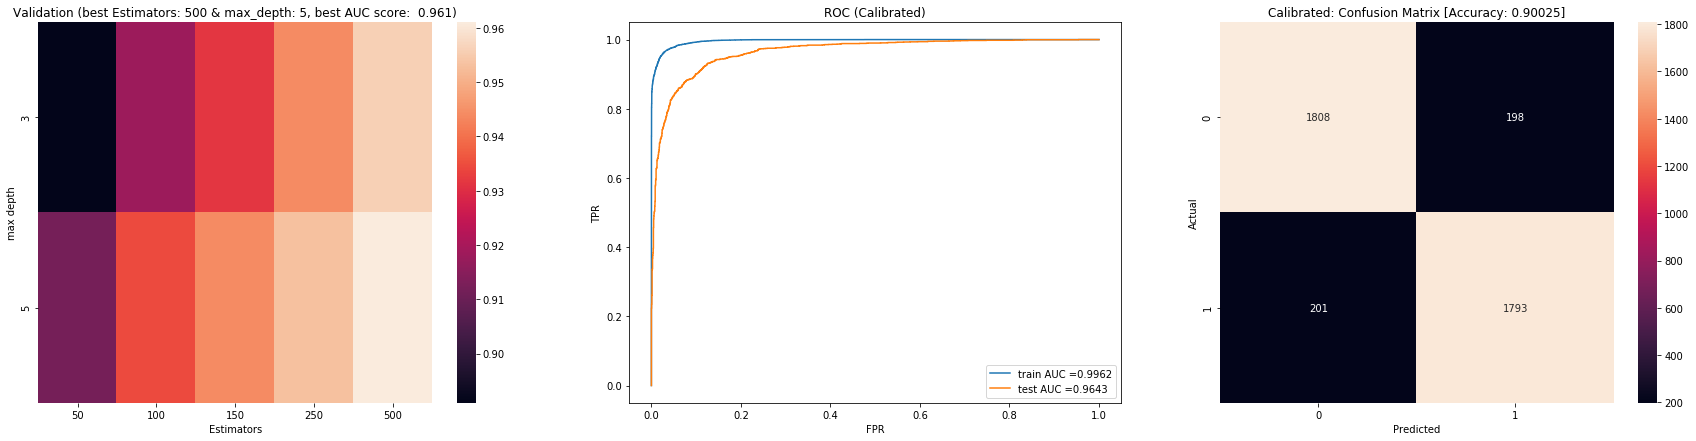

In [31]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
model.best_params_

{'features__Summary_vectorizer__vectorize__binary': True,
 'features__Summary_vectorizer__vectorize__max_features': None,
 'features__Summary_vectorizer__vectorize__min_df': 5,
 'features__Summary_vectorizer__vectorize__ngram_range': (1, 2),
 'features__Text_vectorizer__vectorize__binary': True,
 'features__Text_vectorizer__vectorize__max_features': 5000,
 'features__Text_vectorizer__vectorize__min_df': 1,
 'features__Text_vectorizer__vectorize__ngram_range': (1, 2),
 'model_fit__max_depth': 5,
 'model_fit__n_estimators': 500}

### Set TFIDF

In [6]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word'])),
            ('scale',StandardScaler())])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TfidfVectorizer())]))
        ]
    )),
    ('model_fit',GradientBoostingClassifier())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [10]:
param_grid = {'features__Summary_vectorizer__vectorize__binary' : [True, False],
              'features__Summary_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Summary_vectorizer__vectorize__min_df':[1,5],
              'features__Summary_vectorizer__vectorize__max_features':[None],
              'features__Text_vectorizer__vectorize__binary' : [True, False],
              'features__Text_vectorizer__vectorize__ngram_range': [(1, 2)],
              'features__Text_vectorizer__vectorize__min_df':[1],
              'features__Text_vectorizer__vectorize__max_features':[None,5000,10000],
              'model_fit__n_estimators': [250,500,750],
              'model_fit__max_depth':[3]}   #[round(0.00001*10**i,6) for i in range(10)]

In [11]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

In [9]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
model.best_params_

In [ ]:
!shutdown -h 5

### Word2Vec

In [ ]:
i=0

list_of_sentance=[]
for sentance in tqdm(X_train.Text):
    list_of_sentance.append(sentance.split())

In [ ]:
# this line of code trains your w2v model on the give list of sentances 
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#### Set3 Avg-Word2Vec

In [ ]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
                                  ])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',Avg_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',GradientBoostingClassifier())])

In [ ]:
param_grid = {'model_fit__n_estimators': [50,100,150,250,500],
              'model_fit__max_depth':[3,5]}   #[round(0.00001*10**i,6) for i in range(10)]

In [ ]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

In [ ]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_train_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
model.best_params_

#### Set4 TFIDF Word2Vec

In [ ]:
clf = Pipeline([
    ('features',FeatureUnion([
            ('numerics', Pipeline([('extract',ColumnExtractor(['Cleaned_text'])),
            ('summerize',Text_Summerizer()),
            ('selected_extract',ColumnExtractor(['count_letters', 'count_word', 'count_unique_word']))
                                  ])),
        ('Summary_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_summary'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ])),
        ('Text_vectorizer',Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',TFIDF_WV_transformer(w2v_model=w2v_model)),
            #('scale',StandardScaler())
        ]))]
    )),
    ('model_fit',GradientBoostingClassifier())])

In [ ]:
param_grid = {'model_fit__n_estimators': [50,100,150,250,500],
              'model_fit__max_depth':[3,5]}   #[round(0.00001*10**i,6) for i in range(10)]

In [ ]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5, scoring='roc_auc',return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

In [ ]:
# cv results to dataframe 
results = pd.DataFrame(model.cv_results_)


plt.figure(figsize=(30,7))

mean_train_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_train_score'].max()
mean_test_score = results.groupby(['param_model_fit__n_estimators','param_model_fit__max_depth'])['mean_test_score'].max()

# Hyper parameter plot 
plt.subplot(131)
max_ind = mean_test_score.argmax()

df2 = mean_test_score.to_frame().reset_index().pivot(columns='param_model_fit__n_estimators',index='param_model_fit__max_depth',values='mean_test_score')

sns.heatmap(df2);
plt.xlabel('Estimators')
plt.ylabel('max depth');mean_train_score.argmax()
plt.title(f"Validation (best Estimators: {mean_test_score.index[max_ind][0]} & max_depth: {mean_test_score.index[max_ind][1]}, best AUC score:  {round(mean_test_score.values[max_ind],3)})");

## ROC
plt.subplot(132)
y_train = Y_train.map({'positive':1, 'negative':0})
y_test = Y_test.map({'positive':1, 'negative':0})

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(round(auc(train_fpr, train_tpr),4)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(round(auc(test_fpr, test_tpr),4)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (Calibrated)")


# confusion matrix
plt.subplot(133)
conf_matrix = confusion_matrix(Y_test, model.predict(X_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title(f"Calibrated: Confusion Matrix [Accuracy: {accuracy_score(Y_test, model.predict(X_test))}]")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
model.best_params_,model.best_score_

# Clustering

## K-means

In [20]:
clf = Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer()),
    ('model_fit',KMeans())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [15]:
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(X_train.Cleaned_text).todense()

In [16]:
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,8)
  
for k in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = MiniBatchKMeans(n_clusters=k)
    kmeanModel.fit(X)
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1))/X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

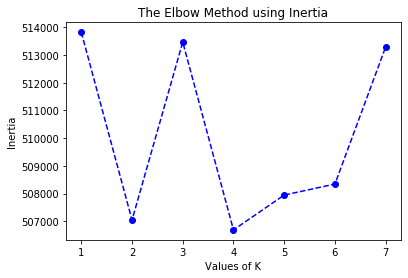

In [17]:
plt.plot(K, inertias, 'bo--') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

3 is the best k

## Agglomerative Clustering

In [20]:
clf = Pipeline([
            ('extract',ColumnExtractor(['Cleaned_text'])),
            ('converter', Converter()),
            ('vectorize',CountVectorizer()),
    ('model_fit',KMeans())]) #CalibratedClassifierCV(base_estimator=SGDClassifier(loss='modified_huber'), cv=5, method='isotonic')

In [23]:
param_grid = {'vectorize__binary' : [True, False],
              'vectorize__ngram_range': [(1,1),(1, 2)],
              'vectorize__min_df':[1,5],
              'vectorize__max_features':[None,5000,10000],
              'model_fit__n_clusters': list(range(1,5))}

In [ ]:
model = GridSearchCV(clf,param_grid = param_grid, cv = 5,return_train_score=True, n_jobs=10,verbose=1)
model.fit(X_train,Y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   50.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  8.4min
